# 1. Introduction


## 1.1 About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
from keras.callbacks import EarlyStopping
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.


The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [2]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Full Value Property Tax Rate|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. At the time regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

## 1.2 Adding more readable column names

In [4]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [5]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [7]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

#### Objective 1: Use descriptive statistics and plots to describe the Boston House Prices Dataset

In the section I will use descriptive statistics and plots to provide a summary of the dataset and describe it's main features. This is of course a compenent of any data analysis project and will also aid in the identifying the steps that need to be taken in the data pre-processing stage of implementing the machine learning model that is shown later in this project.

## 2.1 Basic Information 

Pandas "info()" method can tell us the counts of datapoints in each of the features and also show if there are any missing / null values in the dataset. As we can see below, there are no null values that will have to be dealt with.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2.2 Measures of central tendancy and measures of spread / dispersion

Next we will look at the measures of central tendancy and the spread / dispersion of the data.

1. Measures of Central Tendancy attempt to give one number that best summarises the data. These include the mean/average, median and mode. 
2. Measures of spead / dispersion show the variability within the data. These include the range (max - min), standard deviation, variance, skewness, kurtosis etc.

Pandas "describe()" function quickly gives an overview of some of these key statistics for each of the features in the dataset.

In [9]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking at the means, range, and quartile values in the above tables indicates that some of the features have very unevenly distributed values. Especially the crime rate and number of black people per 1000 people. It is also worth noting that different features are operating on very different scales.

The above table does not give the mode (most commonly occuring value) for each of the features, but the Pandas "mode()" function can be used to get this.

In [10]:
df.mode()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.01501,0.0,18.1,0.0,0.538,5.713,100.0,3.4952,24.0,666.0,20.2,396.9,6.36,50.0
1,14.33370,NaN,NaN,NaN,NaN,6.127,NaN,NaN,NaN,NaN,NaN,NaN,7.79,NaN
2,NaN,NaN,NaN,NaN,NaN,6.167,NaN,NaN,NaN,NaN,NaN,NaN,8.05,NaN
3,NaN,NaN,NaN,NaN,NaN,6.229,NaN,NaN,NaN,NaN,NaN,NaN,14.10,NaN
4,NaN,NaN,NaN,NaN,NaN,6.405,NaN,NaN,NaN,NaN,NaN,NaN,18.13,NaN
5,NaN,NaN,NaN,NaN,NaN,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is worth noting that the most common Median House price is 50,000 which also happens to be the maximum value. This will need to be looked at more closely. Other features where the mode is equal to the max value include:
1. The % of houses in the area built before 1940 - The mode is 100%, but this is believable in an old city like Boston.
2. Number of accessible highways - The mode and max are 24. 
3. Number of Blacks per 1000 - the mode and max are 396.9, but for such a specific number it may only have occured twice to be counted as the mode. 
4. Percentage of industrial land - The max and mode are both 18.1. Again this will need to be looked at more closely to see if it's an error. 

In [11]:
df.median()

Crime_Rate          0.25651
%_Large_Plots       0.00000
%_Indus             9.69000
By_River            0.00000
NOX                 0.53800
Rooms               6.20850
%_Pre_1940         77.50000
Dist_to_Jobs        3.20745
Highway_Access      5.00000
Tax               330.00000
PTRatio            19.05000
Blks_per_1000     391.44000
%_Lower_Status     11.36000
Median_Val         21.20000
dtype: float64

Comparing the above median values of the features to the max and mins again gives the impression of some highly skewed / unevenly distributed data.

## 2.3 Distribution of Variables

Next we will plot the distribution of the values and see if that highlights any issue or outliers. Beginning with the target variable - Median Value of House Prices.

As can be seen from the above KDE and Boxplot, there is a cluster of outliers in the upper range of values. It may be better to remove these later.

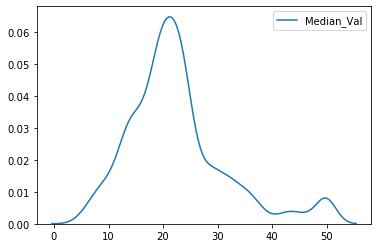

In [12]:
sns.kdeplot(df['Median_Val'])

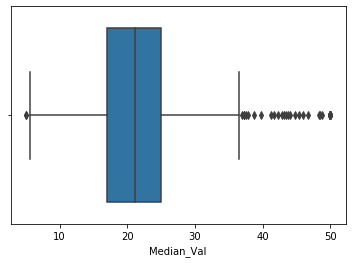

In [13]:
sns.boxplot(df['Median_Val'])

Looking at the all the features side by side, we can see that only Rooms, % of Lower Status people, Median Value are close to being normaly distributed. 

The "By_River" variable is a dummy variable with a boolean value. 

Crime rate, and the % of Large Plots have a large number of values close to zero which is understandable and doesn't set any alarm bells ringing about errors in the data.

The number of black people per 1000 tends towards the 40% mark, which again seems reasonable for a major US city and doesn't give any indication of errors in the data.

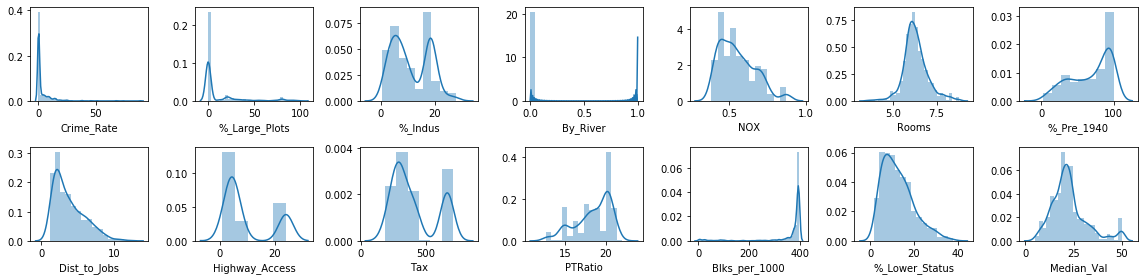

In [14]:
# distributions of the data
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.distplot(df[col[index]], ax = ax[i][j])
        index = index + 1

pyplt.tight_layout()

## 2.4 Relationships between the Variables

This next section will highlight any relationships between the data, beginning with creating a corrolation table.

In [15]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


As we can see from the above there are a number of variables that are strongly positively correlated, for example:

1. Tax and access to highways (0.91) - understandable as highways are paid for out of taxes.
2. NOX and the % of Industrial Land (0.76) - not very suprising that industrial areas would have high levels of NOX. 
2. NOX and the % of Pre 1940 houses (0.73) - possibly older houses would be burning coal.
3. Tax and the % of Industrial Land (0.71) 

There are also some strongly negatively correlated variables:

1. NOX and Distance to Jobs (-0.77) - makes sense as areas of employment are likely to be industrial and have more NOX. The further away you are, the better the air
2. % Pre 1940s houses and Distance to Jobs (-0.75) - makes sense as older areas are more likely to be located in the city centre near areas of employment. 
3. % Industrial and Distance to Jobs (-0.71) - same reasoning as point 1 above

In summary, there isn't anything unusual about the values in the correlation table that requires further investigation. 

Looking more closely at the correlation between the features and the target variable (Median House Prices), we can see that Rooms and % Lower Status are the most strongly corrolated. The rest of the variables are either moderately or weakly corrolated. This would indicate that the percentage of lower status people and the number of rooms are the best predictors of the housing prices. We will investigate this further later in this project.

In [16]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

Looking at below scatterplots of the different features vs the Median Value, Rooms and % of Lower Status People again stand out as having a relationship with it. 

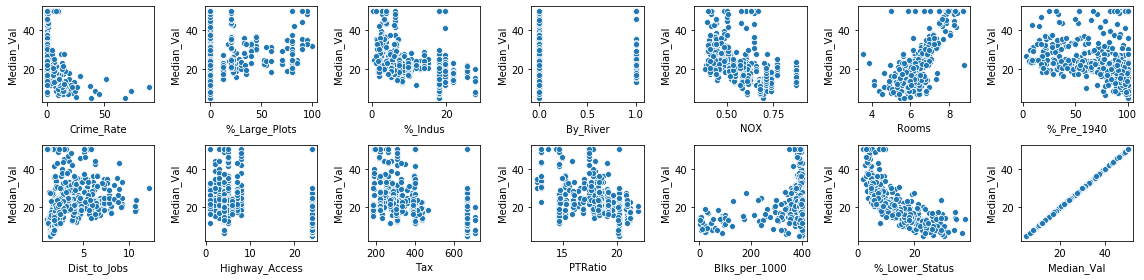

In [17]:
# scatter plots of the variables vs Median Value
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.scatterplot(df[col[index]], y="Median_Val", data=df, ax=ax[i][j])
        index = index + 1
        
        

pyplt.tight_layout()

Looking at the three most strongly corrolated values with the Median Value below, it's clear that the first two variables have a much more obvious relationship, while the Pupil Teacher ratio has much more noise.

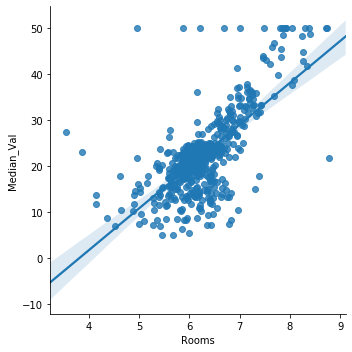

In [18]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

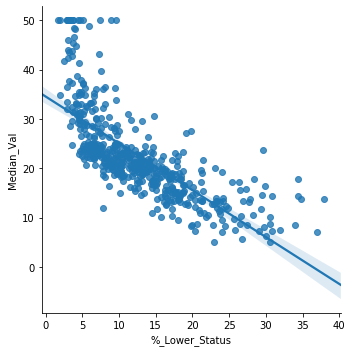

In [19]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

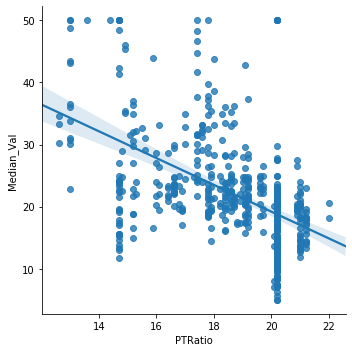

In [20]:
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

## 2.5 Conclusions from the Descriptive Analytics

My main conclusions or items of note from this section are:

1. There are no null values in the data that will need to be dealt with.
2. There are some potential errors / outliers in the Median Values with 14 values being at the max value of $50,000
3. The only other two variables with a normal distribution are also the most strongly corrolated with the Median Value

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below.

## 3.1 Looking more closely at the  "By_River" variable

As we can see from the below histogram, there are significantly more areas in our dataset that are located away from the Charles river than next to the Charles River (35).  (471)

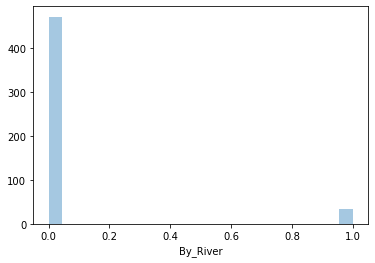

In [21]:
sns.distplot(df['By_River'], kde=False)

In [22]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [23]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

The exact count is:
* 35 next to the river 
* 471 away from the river

Looking at the distribution of the two categories we can see that the houses by the river would seems to have a higher percentage of more expensive houses. In addition, the cheapest house located away from the river.  

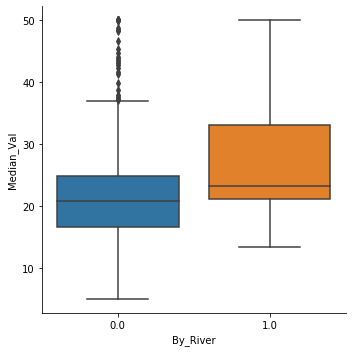

In [24]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

In [25]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]

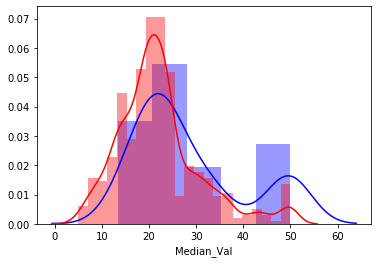

In [26]:
ax = sns.distplot(next_to_river['Median_Val'], color="blue")
ax = sns.distplot(away_from_river['Median_Val'], color="red")
pyplt.rcParams["figure.figsize"] = (20,20)

This is reflected in the descriptive statistics below with the "Next to River" values having a higher mean and mimimum value of than the areas that are located "Away from the River"

In [27]:
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [28]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

## 3.2 T-test

From the above plots and descriptive statistics it would seem that there does indeed to be some difference in the housing prices in areas along the Charles River vs those that aren't. A T-Test can be used to get futher confirmation of this (or indeed disprove this). 

### 3.2.1 Why use a T-Test?

A T-test is used to compare the means of two samples when the parameters of the population as a whole are not known. Using it will allow us to prove or reject the below Null Hypothosis and Alternative Hypothosis [14].

1. The Null Hypothesis is that there is no significant difference between houses along the Charles River and those that aren't.

2. The Alternative Hypothesis is that there is a significant difference between these two groups. 



### 3.2.2 T-Test Requirements

Before we can apply a T-Test, it is first necessary to ensure that our datasets meets the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale of 0-50|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

#### 3.2.2.1 Removing Outliers

As I mentioned earlier in this project, the "Median Val" variable has many outliers. This is clearly displayed in the Boxplot below. 

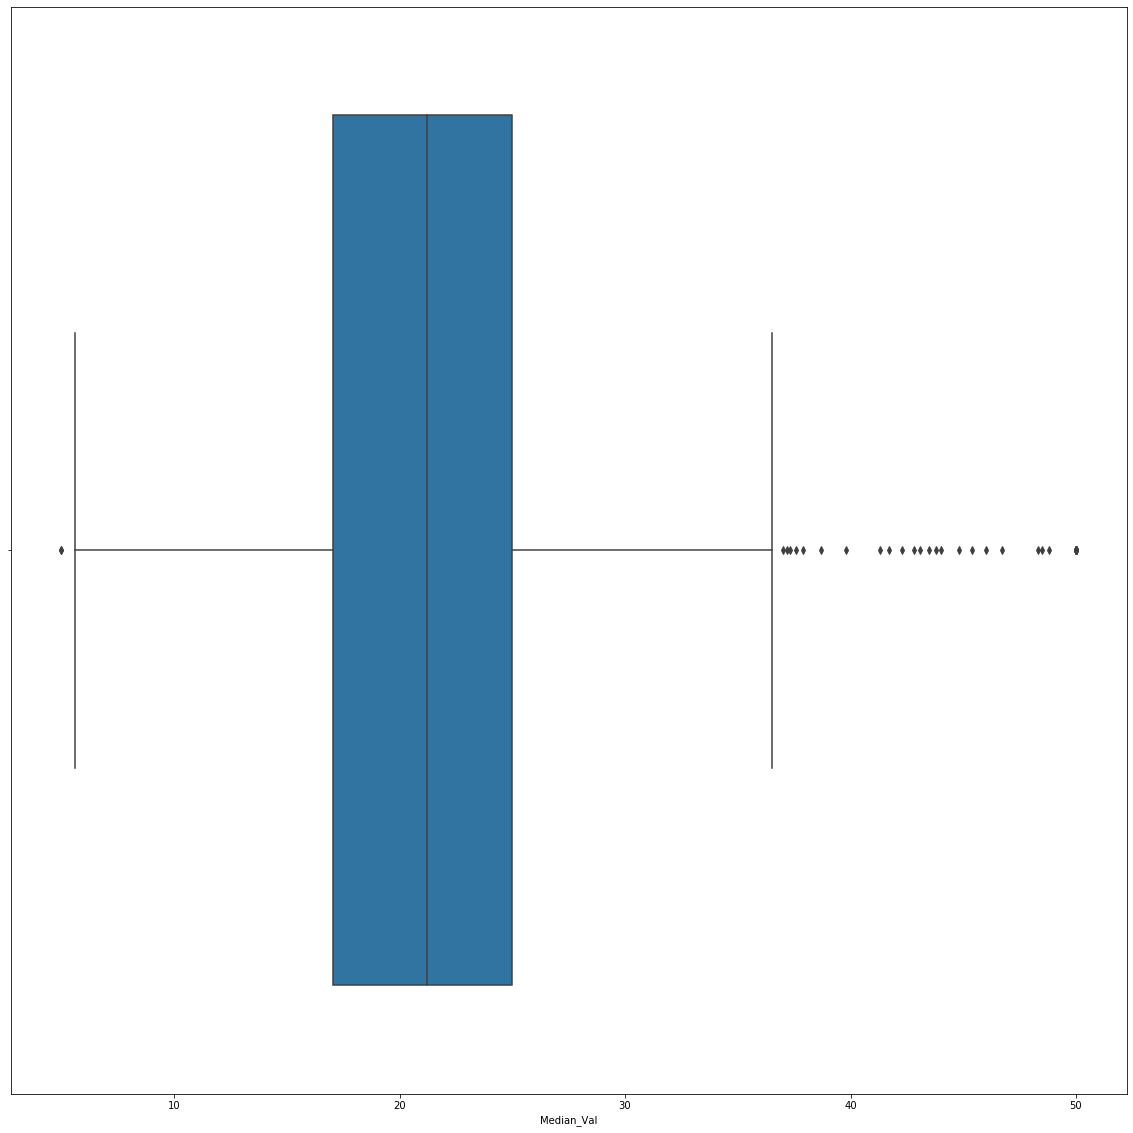

In [29]:
sns.boxplot(df['Median_Val'])

In [30]:
df["Median_Val"][df["Median_Val"] ==50].count()

16

There are also 16 areas where the median value of houses is $50,000, but nothing higher that this value. This could indicate  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers I have assigned a threshold for the Median Value, above or below which i have consider the data point to be an outlier. The most obvious way to do this is to follow the same method as the box-plot and remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [31]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [32]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [33]:
IQR = Q3 - Q1
IQR

7.975000000000001

Having calculated the interquartile range, this was then used find the upper and lower "whisker" values for the box plot which will acts as the "outlier thresholds".

In [34]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [35]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [36]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There were two data points below the lower threshold.

In [37]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [38]:
above["Median_Val"].count()

38

There were 38 datapoints that were higher that the upper threshold. Using these thresholds I created a dataset of data that was within these two thresholds called "no_outliers".

In [39]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Comparing the two groups with the outliers removed shows that the median values of the two groups was now much closer together, but the range of values in the "Away from River" group was still much wider.

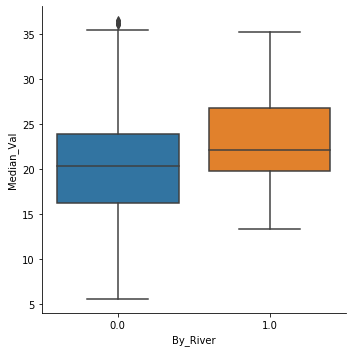

In [40]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

#### 3.2.2.2 Determining if the Dependant Variable is Approxmately Normally Distributed in Each Group.

In order to test this I created two new groups from the "no_outliers" dataset:
1. Next to River
2. Away from River

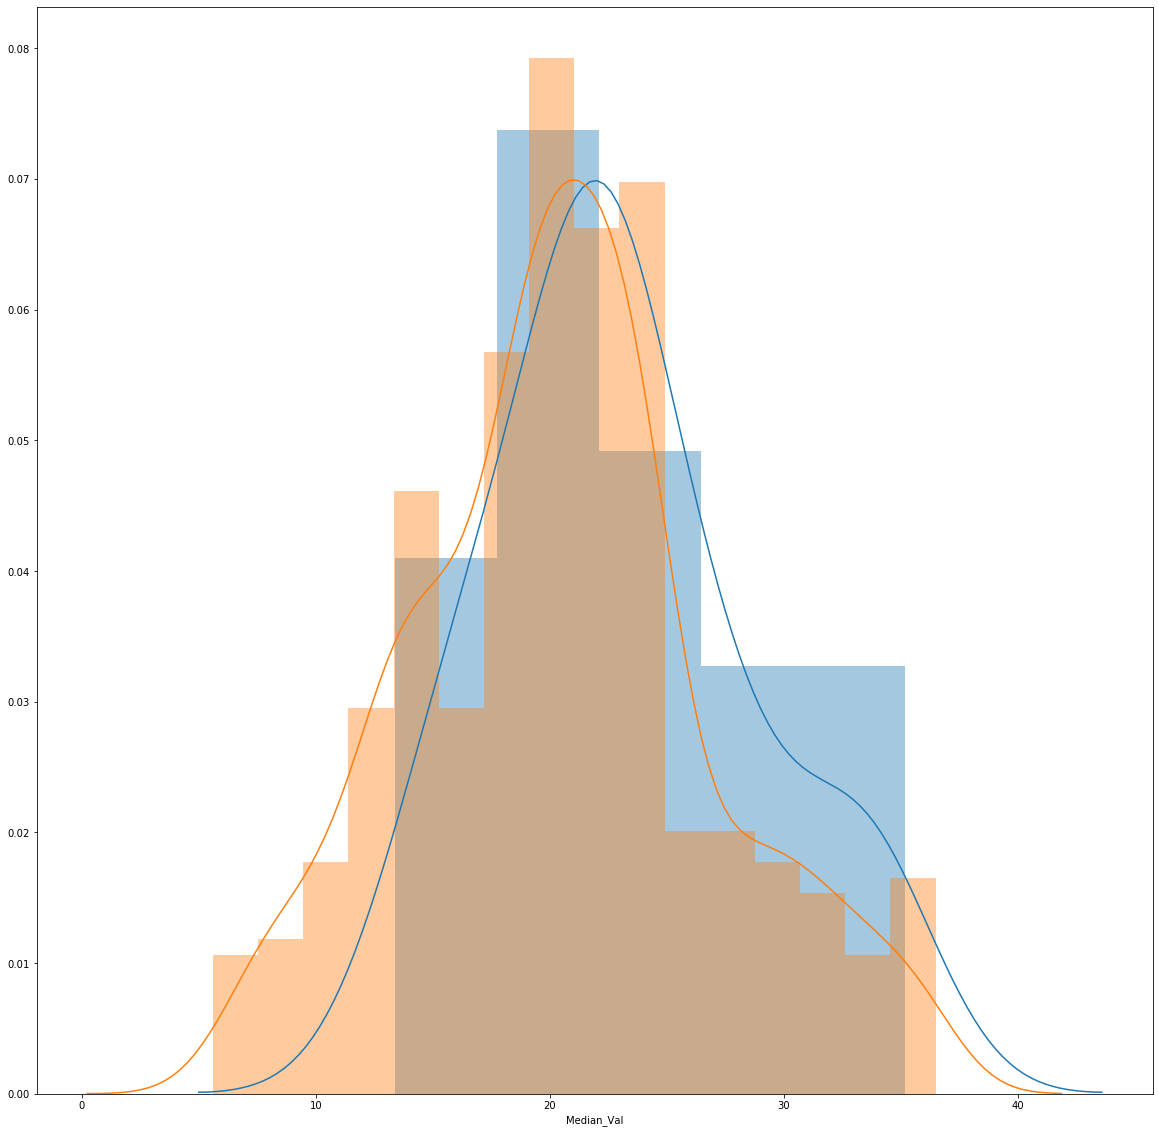

In [41]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" group it can be observed that both are much closer to appearing to be normally distributed than the original dataset with the outliers included.

I performed a further test using Scipys "normaltest" method to confirm this.

In [42]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). I can therefore be said the no significant departure from normality was found [15].

#### 3.2.2.3 Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid t-test it is necessary to check if both samples have similar variances. Levenes test can be used to do this. It tests the null hypothosis that variances are equal. 

In [43]:
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The P-value is greater than the threshold of 0.05 so it can be said that there is no signifcant difference in the variances of both groups.

In [44]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [45]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


#### 3.2.2.4 Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have been removed.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### 3.3 T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [46]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current section was to test if there is a significant difference in the Median Value of House Prices between the house prices in areas by or not by the Charles River in Boston.

In [47]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [48]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference < 0 p value =,0.9819
5,Difference > 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test showed a P-value of 0.0362. This is lower than the 0.05 threshold giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

It can therefore be concluded that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predicting House Prices using a Neural Network


#### Objective 3: Predict the median house price based on the other variables in the dataset using neural network

## 4.0 Overview

In this section, I have built a model for a neural network that has gone through several iterations in order to determine which configuration of the model was delivering the best predictions.

Before creating the model I did several preprocessing steps to prepare the training and test data. Following that I created a "baseline" model to measure subsequent iterations performance against.

I then outlined the different elements of the model that could be adjusted and tested to see if they could improve performance. 

Following that I created and tested several different versions of the model, changing one key element each time e.g. number of epochs, layers size etc with an attempt at further tuning using Principal Component Analysis and Feature Selection.

Finally, I selected the best performing model from the various iteration as my final model.

**NOTE:** *I have commented out the code for several of the model testing functions below. Some of these can take quiet some time to run, so I felt it was safest to comment them out in case someone was to use the "Rull All" option.*

## 4.1 Pre-Processing

Before proceeding with the creation of the model it is necessary to ensure the data is as error free as possible and in the right format for feeding into the model.

In this project I took the following pre-processing steps:

1. Dealt with any Null values
2. Dealt with Categorical Variables
3. Standardised the Data

It should be noted that record with an outlier in the Median Value variable have already been removed during the preperation for the T-Test above. 


### 4.1.1 Null Values

First I checked to see if the cleansed dataset contained any Null values. If there were Null values, the row containing the value will be need to be removed or the value would have needed to be replaced.

In [49]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

However, as can be seen from the table above, there were no null values.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located next to or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore, it was not necessary to have to do any encoding or processing of this variable.

In [50]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise  the Data

Standardisation means transforming all values in a dataset so that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, looking at the below shows that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [51]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before the data was scaled it needed to be split into the independent and dependent variables for the model.

#### 4.1.3.1 Shuffling the Data

Before splitting the data it was also suffled. This is more important in classification tasks where the dataset is sorted by class, but it is also good to ensure all of the data from a particular area didn't end up in just the training dataset and not the test dataset. Following that, the data was split into the input and taget variables for the model.

In [52]:
no_outliers = shuffle(no_outliers)

In [53]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

#### 4.1.3.2 Splitting into Test and Training Sets

The data then needed to be split into the testing and training sets. For this project I have used a 80:20 train:test split. 

Sklearn's model selection tool for can be used to perform the split. 

In [54]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [55]:
x_train.iloc[0] # snapshot of a single row of data

Crime_Rate          4.26131
%_Large_Plots       0.00000
%_Indus            18.10000
By_River            0.00000
NOX                 0.77000
Rooms               6.11200
%_Pre_1940         81.30000
Dist_to_Jobs        2.50910
Highway_Access     24.00000
Tax               666.00000
PTRatio            20.20000
Blks_per_1000     390.74000
%_Lower_Status     12.67000
Name: 359, dtype: float64

#### 4.1.3.3 Standarising the Data

Once the data was split into testing and training sets was standardised / scaled.


In [56]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [57]:
x_train.iloc[0]

Crime_Rate        0.074901
%_Large_Plots    -0.473006
%_Indus           0.983365
By_River         -0.238366
NOX               1.827937
Rooms            -0.053043
%_Pre_1940        0.445030
Dist_to_Jobs     -0.618623
Highway_Access    1.597886
Tax               1.473586
PTRatio           0.771766
Blks_per_1000     0.393892
%_Lower_Status   -0.127787
Name: 0, dtype: float64

In [58]:
x_train.describe().round()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
count,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.0,-0.0,-2.0,-0.0,-1.0,-5.0,-2.0,-1.0,-1.0,-1.0,-3.0,-4.0,-2.0
25%,-0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-1.0,-0.0,0.0,0.0,-0.0
75%,0.0,0.0,1.0,-0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0
max,11.0,4.0,2.0,4.0,3.0,3.0,1.0,4.0,2.0,2.0,2.0,0.0,4.0


##  4.2 Baseline prediction test

After the data processing was complete, it was possible to proceed with the creation of a baseline model. For the baseline model I added:
1. An input layer with a number of units equal to the number of input features in the dataset.
2. An output layer with one unit as the model is only supposed to produce one output value.
3. 100 epochs - number chosen at random
4. A batch size of 5 - number chosen at random

In [59]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [60]:
m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 1s 3ms/step - loss: 438.5677
Epoch 2/100
372/372 [==============================] - 0s 202us/step - loss: 393.2144
Epoch 3/100
372/372 [==============================] - 0s 224us/step - loss: 339.8955
Epoch 4/100
372/372 [==============================] - 0s 212us/step - loss: 281.0736
Epoch 5/100
372/372 [==============================] - 0s 201us/step - loss: 221.9035
Epoch 6/100
372/372 [==============================] - 0s 225us/step - loss: 167.5863
Epoch 7/100
372/372 [==============================] - 0s 204us/step - loss: 124.3195
Epoch 8/100
372/372 [==============================] - 0s 206us/step - loss: 93.4982
Epoch 9/100
372/372 [==============================] - 0s 201us/step - loss: 73.2427
Epoch 10/100
372/372 [==============================] - 0s 311us/step - loss: 60.0656
Epoch 11/100
372/372 [==============================] - 0s 343us/step - loss: 51.2053
Epoch 12/100
372/372 [==============================] - 0s

372/372 [==============================] - 0s 188us/step - loss: 5.9558
Epoch 97/100
372/372 [==============================] - 0s 177us/step - loss: 5.9359
Epoch 98/100
372/372 [==============================] - 0s 181us/step - loss: 5.9339
Epoch 99/100
372/372 [==============================] - 0s 197us/step - loss: 5.9605
Epoch 100/100
372/372 [==============================] - 0s 228us/step - loss: 5.8564


In [61]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[14.976948, 18.897902, 30.653492, 16.514652, 21.962103, 11.06825 ,
        20.22656 , 22.875275, 17.47519 , 26.483358, 19.59356 , 11.602667,
         9.088746, 26.004192, 24.331589, 24.32567 , 30.059118, 24.08105 ,
        32.229595, 27.782356, 12.953043, 17.1165  , 36.675632, 30.69486 ,
        28.675606, 22.767715, 21.54743 , 25.219784, 11.814427,  7.251917,
        19.268661, 16.713514, 22.977205, 19.312727, 29.998001, 26.495188,
        19.024645, 14.697862, 25.393599, 21.778135, 29.304321, 31.305128,
        16.555254, 18.492966, 17.942657, 25.192694, 23.724321, 32.330734,
        26.229427, 33.51344 , 23.633556, 14.786364, 15.029094, 13.469605,
        20.88909 , 24.46839 , 12.527711, 22.941463, 14.679114, 22.697403,
        22.631714, 17.147152, 19.10627 , 20.306965, 31.88167 , 34.614643,
        16.962847, 21.503836, 18.94574 , 24.731516, 26.564714, 28.090208,
        23.564005, 18.528603, 25.86246 , 19.604311, 19.701616, 19.310932,
        18.10576 , 16.105534, 12.94081

In [62]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([14.3, 17. , 34.7, 14.2, 24.4,  6.3, 20.5, 24.1, 12.5, 23.9, 21.5,
       14.4,  8.8, 24.1, 25. , 23.2, 31.6, 21.6, 36.4, 28.6, 12.8, 27.9,
       21.9, 30.1, 27.9, 23.8, 23.3, 28.1,  8.3,  8.4, 22.5, 19.6, 22.3,
       19.2, 29.9, 27.5, 17.5, 15.2, 26.2, 19.3, 23.6, 29. , 18.1, 20. ,
       15. , 22.8, 22.4, 32.7, 26.6, 36.1, 25. , 13.6, 16.6, 11.7, 16.6,
       23.3, 16.3, 24. , 14.5, 23. , 21.9, 16.4, 19.3, 20.1, 32.9, 33.3,
       15.2, 22. , 21.9, 24.7, 23.7, 29.8, 22.9, 18.3, 23.3, 21. , 21.8,
       18.6, 20.4, 13.3, 11.3, 29. , 16.8, 22.2, 28. , 21.7, 14. , 31. ,
       19.4, 24.8, 33.4, 13.5, 34.6, 11.5], dtype=float32)

In [63]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,14.976948,14.300000,4.519930
1,18.897902,17.000000,10.042922
2,30.653492,34.700001,13.200809
3,16.514652,14.200000,14.015751
4,21.962103,24.400000,11.100471
...,...,...,...
89,24.405272,24.799999,1.617387
90,30.265669,33.400002,10.356067
91,14.038880,13.500000,3.838485
92,33.647827,34.599998,2.829815


In [64]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

9.34684

In [65]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 244us/step


7.8320446978224085

The initial baseline test I performed showed an average of a 10.7% diffence between the real and predicted test values and an MSE value of 7.3. As can be seen in the following iteration, I found it very difficult to improve this value significantly. 

## 4.3 Factors Considered When Creating Subsequent Models

Before progressing further with project and creating new models, I looked at the main elements that make up a model, what role they perform, and the potential effects of changing them.

### 4.3.1 Model Selection

I used the Sequential Model for all models in ths project. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary for the purposes of this project.

### 4.3.2 Density

This is the layer type. In this type all nodes/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). I saw no reason to change this for the different models in this project.

### 4.3.3 Number of Layers

For the baseline I have added 1 input later and 1 output layer. This is the absolute minimum number a model can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models, having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I have added additional layers in later iterations of the model.

### 4.3.4 Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this projects dataset there are 13 input variables with 1 output required. This is what was entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively, reducing accuracy. 

There are some rules of thumb such for layer sizes such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

However, these fail to take account of size of the training dataset and other considerations [3]. 

I have experimented with different layer sizes in the models below.



### 4.3.5 Activation Functions

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This was obviously not suitable for this project's dataset, but there were several others that were worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scaled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers activated by the ReLU function. 
* ReLu should only be used in hidden layers and not the output layer.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left as the default linear function.




### 4.3.6 Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error", which is what was used in the various models in this project [6].

### 4.3.7 Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I did not think there would be much value in using other optimizers.

### 4.3.8 Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In the Baseline Model I set the model to perform 100 epochs. I tried larger numbers of epochs in later iterations. 

### 4.3.9 Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore, each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 

I have tried several different batch sized in the models below.


## 4.4 Model Tuning

In this section I tested changes to the model based on some of the possible improvements discussed above:

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I did not be change:
1. Activation functions
2. Loss function
3. Optimizer

I attempted to test this in an empirical fashion, changing one parameter at a time and testing to see if it resulted in any improvements vs the Baseline.

### 4.4.1 Batch Sizes

In this section I tested various batch sizes while keeping all other model parameters the same as the Baseline Model.

###### Test 1-  Increasing Batch Size to 32


In [66]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=32)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch1 = m.evaluate(x_test, y_test)

In [67]:
# result_batch1

**Result:** Rejected - MSE increased to 26.539871296984085

###### Test 2 - Batch Size to 16

In [68]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=16)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch2 = m.evaluate(x_test, y_test)

In [69]:
# result_batch2

**Result:** Rejected - MSE increased to 12.633492307460054

###### Test 3 - Batch Size to 4

In [70]:
# Test 3
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=4)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch3 = m.evaluate(x_test, y_test)

In [71]:
# result_batch3

**Result:** Possible candidate. MSE of 7.892184135761667 is closer to the baseline

###### Test 4 - Batch Size to 2

In [72]:
# Test 4
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=2)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch4 = m.evaluate(x_test, y_test)

In [73]:
# result_batch4

**Result:** Possible candidate. MSE of 8.877476955981965 is slightly worse than the baseline.

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [74]:
# function to test batch sizes with 10 test and average of results

# def batchsize_test(tests, b_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")

#         m.fit(x_train, y_train, epochs=100, batch_size=b_size)

#         batch_test1_prediction = m.predict(x_test).T

#         MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_batch3 = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_batch3)
#     avg_result = sum(resultslist) / tests
#     return avg_result

#print(batchsize_test(5, 2))

In [75]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seemed to perform marginally better. Given that this project  dealt with a relatively small dataset memory wasn't an issue so  there was no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

In this section I tested different epoch sizes.

###### Test 1 - 500 Epochs

In [76]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

history = m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 743us/step - loss: 435.2861
Epoch 2/500
372/372 [==============================] - 0s 764us/step - loss: 367.0976
Epoch 3/500
372/372 [==============================] - 0s 520us/step - loss: 267.0071
Epoch 4/500
372/372 [==============================] - 0s 536us/step - loss: 155.3686
Epoch 5/500
372/372 [==============================] - 0s 547us/step - loss: 69.1431
Epoch 6/500
372/372 [==============================] - 0s 495us/step - loss: 32.2393
Epoch 7/500
372/372 [==============================] - 0s 651us/step - loss: 23.5462
Epoch 8/500
372/372 [==============================] - 0s 1ms/step - loss: 20.8469
Epoch 9/500
372/372 [==============================] - 0s 762us/step - loss: 19.0394
Epoch 10/500
372/372 [==============================] - 0s 678us/step - loss: 17.5950
Epoch 11/500
372/372 [==============================] - 0s 662us/step - loss: 16.2381
Epoch 12/500
372/372 [==============================] - 0s 50

Epoch 97/500
372/372 [==============================] - 0s 472us/step - loss: 5.1744
Epoch 98/500
372/372 [==============================] - 0s 450us/step - loss: 5.1676
Epoch 99/500
372/372 [==============================] - 0s 490us/step - loss: 5.1930
Epoch 100/500
372/372 [==============================] - 0s 563us/step - loss: 5.1945
Epoch 101/500
372/372 [==============================] - 0s 652us/step - loss: 5.1302
Epoch 102/500
372/372 [==============================] - 0s 517us/step - loss: 5.1764
Epoch 103/500
372/372 [==============================] - 0s 496us/step - loss: 5.0760
Epoch 104/500
372/372 [==============================] - 0s 533us/step - loss: 5.1355
Epoch 105/500
372/372 [==============================] - 0s 655us/step - loss: 5.1028
Epoch 106/500
372/372 [==============================] - 0s 514us/step - loss: 5.0520
Epoch 107/500
372/372 [==============================] - 0s 539us/step - loss: 5.0396
Epoch 108/500
372/372 [==============================] - 

372/372 [==============================] - 0s 489us/step - loss: 4.5593
Epoch 193/500
372/372 [==============================] - 0s 527us/step - loss: 4.6109
Epoch 194/500
372/372 [==============================] - 0s 516us/step - loss: 4.5239
Epoch 195/500
372/372 [==============================] - 0s 467us/step - loss: 4.5320
Epoch 196/500
372/372 [==============================] - 0s 587us/step - loss: 4.5266
Epoch 197/500
372/372 [==============================] - 0s 475us/step - loss: 4.5455
Epoch 198/500
372/372 [==============================] - 0s 550us/step - loss: 4.5426
Epoch 199/500
372/372 [==============================] - 0s 478us/step - loss: 4.4934
Epoch 200/500
372/372 [==============================] - 0s 834us/step - loss: 4.5504
Epoch 201/500
372/372 [==============================] - 0s 644us/step - loss: 4.4836
Epoch 202/500
372/372 [==============================] - 0s 751us/step - loss: 4.5832
Epoch 203/500
372/372 [==============================] - 0s 560us/st

372/372 [==============================] - 0s 683us/step - loss: 4.2169
Epoch 288/500
372/372 [==============================] - 0s 546us/step - loss: 4.2260
Epoch 289/500
372/372 [==============================] - 0s 444us/step - loss: 4.1497
Epoch 290/500
372/372 [==============================] - 0s 426us/step - loss: 4.2127
Epoch 291/500
372/372 [==============================] - 0s 462us/step - loss: 4.1669
Epoch 292/500
372/372 [==============================] - 0s 512us/step - loss: 4.1947
Epoch 293/500
372/372 [==============================] - 0s 482us/step - loss: 4.1580
Epoch 294/500
372/372 [==============================] - 0s 684us/step - loss: 4.1433
Epoch 295/500
372/372 [==============================] - 0s 802us/step - loss: 4.2269
Epoch 296/500
372/372 [==============================] - 0s 608us/step - loss: 4.1943
Epoch 297/500
372/372 [==============================] - 0s 593us/step - loss: 4.1956
Epoch 298/500
372/372 [==============================] - 0s 641us/st

372/372 [==============================] - 0s 614us/step - loss: 3.8925
Epoch 382/500
372/372 [==============================] - 0s 484us/step - loss: 3.9332
Epoch 383/500
372/372 [==============================] - 0s 519us/step - loss: 3.9571
Epoch 384/500
372/372 [==============================] - 0s 660us/step - loss: 3.9297
Epoch 385/500
372/372 [==============================] - 0s 536us/step - loss: 3.8519
Epoch 386/500
372/372 [==============================] - 0s 439us/step - loss: 3.9554
Epoch 387/500
372/372 [==============================] - 0s 600us/step - loss: 3.9263
Epoch 388/500
372/372 [==============================] - 0s 648us/step - loss: 3.9169
Epoch 389/500
372/372 [==============================] - 0s 664us/step - loss: 3.9232
Epoch 390/500
372/372 [==============================] - 0s 577us/step - loss: 3.8896
Epoch 391/500
372/372 [==============================] - 0s 509us/step - loss: 3.9148
Epoch 392/500
372/372 [==============================] - 0s 758us/st

372/372 [==============================] - 0s 479us/step - loss: 3.6838
Epoch 476/500
372/372 [==============================] - 0s 534us/step - loss: 3.6163
Epoch 477/500
372/372 [==============================] - 0s 517us/step - loss: 3.6198
Epoch 478/500
372/372 [==============================] - 0s 409us/step - loss: 3.7292
Epoch 479/500
372/372 [==============================] - 0s 440us/step - loss: 3.6806
Epoch 480/500
372/372 [==============================] - 0s 462us/step - loss: 3.6776
Epoch 481/500
372/372 [==============================] - 0s 479us/step - loss: 3.6534
Epoch 482/500
372/372 [==============================] - 0s 487us/step - loss: 3.7122
Epoch 483/500
372/372 [==============================] - 0s 497us/step - loss: 3.7172
Epoch 484/500
372/372 [==============================] - 0s 478us/step - loss: 3.7485
Epoch 485/500
372/372 [==============================] - 0s 470us/step - loss: 3.6613
Epoch 486/500
372/372 [==============================] - 0s 467us/st

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [77]:
print(history.history.keys())

dict_keys(['loss'])


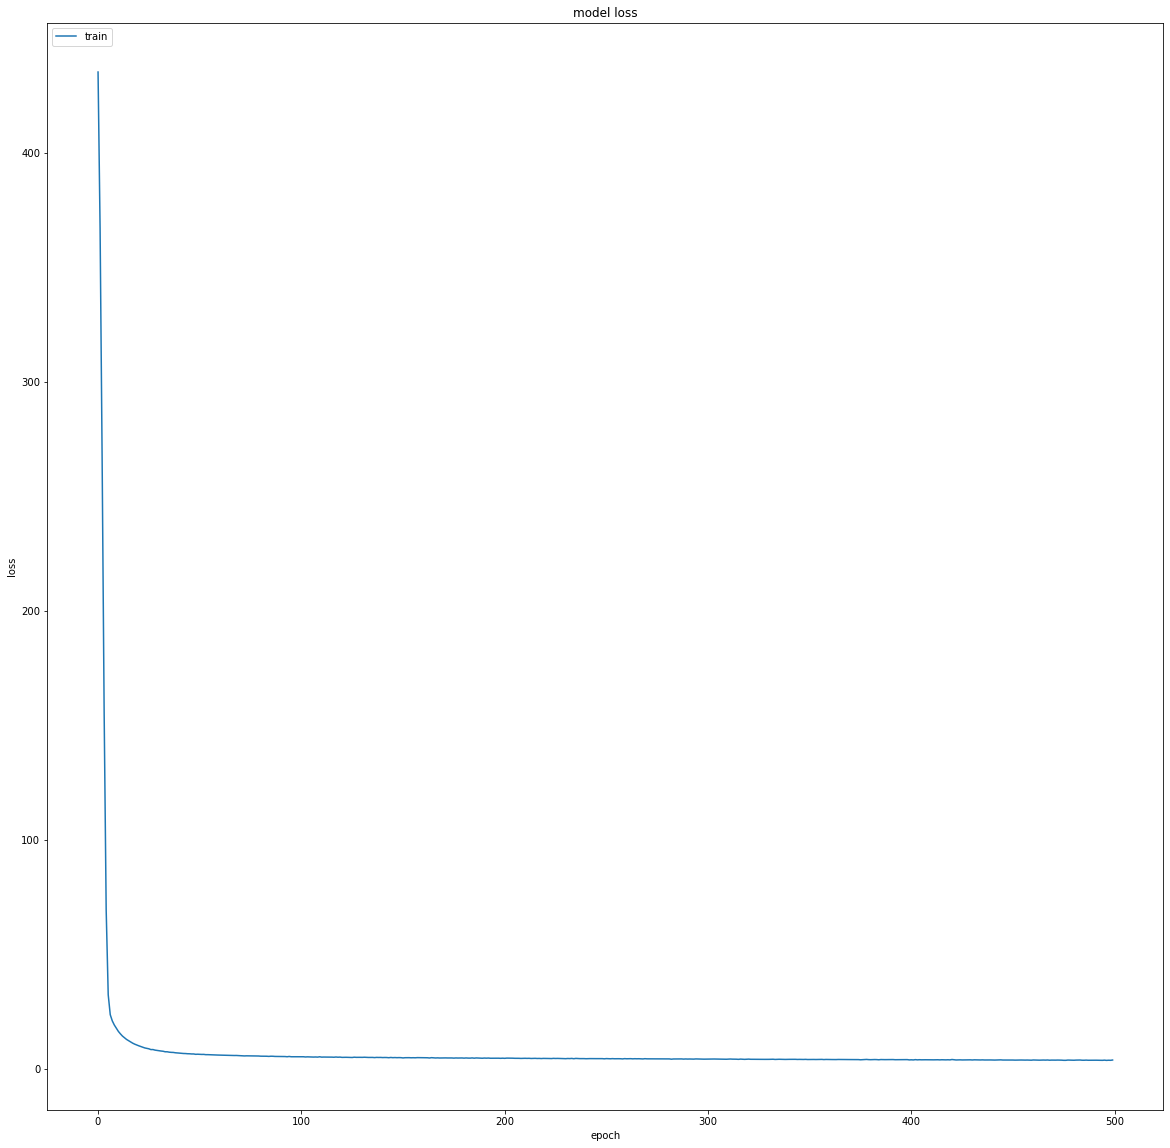

In [78]:
pyplt.plot(history.history['loss'])
pyplt.title('model loss')
pyplt.ylabel('loss')
pyplt.xlabel('epoch')
pyplt.legend(['train', 'test'], loc='upper left')
pyplt.show()

In [79]:
result_epochv1

10.923144000641843

**Result:** The MSE for this model was 5.679925218541571, but I had varying results with several test.

From looking at the above results there definitely seemed to be deminishing returns or even signs of overfitting after the 300 epoch mark. I therefore decided to introduce early stopping in the remaining models.

###### Test 2 - 500 Epochs with Early Stopping

In [80]:
# Test 2
# 
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

# ES_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_ES = m.evaluate(x_test, y_test)

In [81]:
# result_ES

**Result:** MSE was 8.051695742505663

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most tests. This was even when the test was set to only stop when the loss value had not descreased for the previous 10 epochs.

I decided that 250-300 epochs was enough for any further tests.

### 4.4.3 Number of Units per Layer

In this section I adjusted the number of units in the single hidden layer. I used some of the heuristics discussed early as guidelines for selecting the layer sizes.

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. I tested this configuration first.

In [82]:
14*(2/3)


9.333333333333332

In [83]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize9_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN9 = m.evaluate(x_test, y_test)

In [84]:
# result_layerN9

**Result:** The MSE was 8.323373987319622

###### Test 2 - Twice the number of Inputs

The next heuristics I tested was that the number of units in the hidden layer should not be over twice the number of inputs.

In [85]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize26_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN26 = m.evaluate(x_test, y_test)

In [86]:
# result_layerN26

**Result:** This gave MSE results comparable to the Baseline model: 7.729459732136828

###### Test 3 - Quadrupel the Input

In [87]:
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize52_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN52 = m.evaluate(x_test, y_test)

In [88]:
# result_layerN52

**Result:** This configuration gave the best MSE score so far at 5.981633308085989

#### 4.4.3.1 Commentary

Results for diffent layer sizes again appeared to be inconclusive. I therefore decided to test the different model configurations several times and get the average of the results.

In [89]:
# function to test different batch sizes
# def unitsize_test(tests, batchsize, unit_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         #unit_prediction = m.predict(x_test).T

#         #MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_units = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_units)
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [90]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

**Result:** was 8.461502002147919

In [91]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

**Result:** was 7.670181302821382

In [92]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

**Result:** was 8.024365358149751

In [93]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

**Result:** was 7.862417864292226

In [94]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

**Result:** was 8.067290689590129

In [95]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

**Result:** was 7.880062107329673

The best result seemed to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seemed to consistently perform better. I therefore decided to change to a batch size of 4 in the subsequent tests.

### 4.4.4 Number of Layers

Next I tested adding additional layers of neurons to the model. Again, I tested each model configuration 5 times and got the average of the MSE results.

In [96]:
# function to test different amounts of layers
# def layer_count_test(tests, batchsize, unit_size1, unit_size2):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(unit_size2, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         result_units = m.evaluate(x_test, y_test)
        
#         counter += 1
        
#         resultslist.append(result_units)
#         #print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [97]:
# layers_test_results = [
#     layer_count_test(5, 4, 13, 13),
#     layer_count_test(5, 4, 26, 26),
#     layer_count_test(5, 4, 26, 13),
#     layer_count_test(5, 4, 52, 26),
#     layer_count_test(5, 4, 64, 13),
# ]

In [98]:
# labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [99]:
# layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [100]:
# layerresults_df

|Test|Results|
|:------------------------|:---------|
|13 -> 13|7.155485|
|26 -> 26|7.930675|
|26 -> 13|7.613028|
|52 -> 26|8.173526|
|64 -> 13|7.872510|

**Result:** The best results were achieved using two layers of 13 units giving an MSE of 7.155485.

##### Test with 3 Layers 

In [101]:
def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(unit_size3, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
   
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [102]:
three_layers_test_results = [
    three_layer_count_test(5, 4, 13, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 9),
    three_layer_count_test(5, 4, 52, 26, 13),
    three_layer_count_test(5, 4, 64, 26, 13)
]

Epoch 1/300
372/372 [==============================] - 0s 570us/step - loss: 395.7250
Epoch 2/300
372/372 [==============================] - 0s 298us/step - loss: 173.5652
Epoch 3/300
372/372 [==============================] - 0s 327us/step - loss: 59.7844
Epoch 4/300
372/372 [==============================] - 0s 295us/step - loss: 40.7077
Epoch 5/300
372/372 [==============================] - 0s 311us/step - loss: 29.3839
Epoch 6/300
372/372 [==============================] - 0s 292us/step - loss: 22.5467
Epoch 7/300
372/372 [==============================] - 0s 255us/step - loss: 18.0207
Epoch 8/300
372/372 [==============================] - 0s 293us/step - loss: 14.7150
Epoch 9/300
372/372 [==============================] - 0s 303us/step - loss: 12.7301
Epoch 10/300
372/372 [==============================] - 0s 322us/step - loss: 11.0569
Epoch 11/300
372/372 [==============================] - 0s 287us/step - loss: 10.2947
Epoch 12/300
372/372 [==============================] - 0s 25

372/372 [==============================] - 0s 421us/step - loss: 4.3630
Epoch 98/300
372/372 [==============================] - 0s 402us/step - loss: 4.3479
Epoch 99/300
372/372 [==============================] - 0s 279us/step - loss: 4.2175
Epoch 100/300
372/372 [==============================] - 0s 324us/step - loss: 4.3077
Epoch 101/300
372/372 [==============================] - 0s 394us/step - loss: 4.3761
Epoch 102/300
372/372 [==============================] - 0s 417us/step - loss: 4.2843
Epoch 103/300
372/372 [==============================] - 0s 273us/step - loss: 4.3062
Epoch 104/300
372/372 [==============================] - 0s 354us/step - loss: 4.3799
Epoch 105/300
372/372 [==============================] - 0s 435us/step - loss: 4.2904
Epoch 106/300
372/372 [==============================] - 0s 332us/step - loss: 4.2497
Epoch 107/300
372/372 [==============================] - 0s 412us/step - loss: 4.2908
Epoch 108/300
372/372 [==============================] - 0s 432us/step

372/372 [==============================] - 0s 290us/step - loss: 5.4525
Epoch 55/300
372/372 [==============================] - 0s 257us/step - loss: 5.3133
Epoch 56/300
372/372 [==============================] - 0s 278us/step - loss: 5.6329
Epoch 57/300
372/372 [==============================] - 0s 274us/step - loss: 5.2016
Epoch 58/300
372/372 [==============================] - 0s 242us/step - loss: 5.4801
Epoch 59/300
372/372 [==============================] - 0s 283us/step - loss: 5.3917
Epoch 60/300
372/372 [==============================] - 0s 274us/step - loss: 5.2488
Epoch 61/300
372/372 [==============================] - 0s 248us/step - loss: 5.2185
Epoch 62/300
372/372 [==============================] - 0s 273us/step - loss: 5.3309
Epoch 63/300
372/372 [==============================] - 0s 267us/step - loss: 5.2735
Epoch 64/300
372/372 [==============================] - 0s 272us/step - loss: 5.1377
Epoch 65/300
372/372 [==============================] - 0s 282us/step - loss: 

372/372 [==============================] - 0s 258us/step - loss: 3.6601
Epoch 150/300
372/372 [==============================] - 0s 273us/step - loss: 3.6682
Epoch 151/300
372/372 [==============================] - 0s 297us/step - loss: 3.6739
Epoch 152/300
372/372 [==============================] - 0s 412us/step - loss: 3.6434
Epoch 153/300
372/372 [==============================] - 0s 363us/step - loss: 3.7687
Epoch 154/300
372/372 [==============================] - 0s 403us/step - loss: 3.5808
Epoch 155/300
372/372 [==============================] - 0s 367us/step - loss: 3.6164
Epoch 156/300
372/372 [==============================] - 0s 343us/step - loss: 3.6607
Epoch 157/300
372/372 [==============================] - 0s 346us/step - loss: 3.6080
Epoch 158/300
372/372 [==============================] - 0s 357us/step - loss: 3.6177
Epoch 159/300
372/372 [==============================] - 0s 324us/step - loss: 3.7254 0s - loss: 4.90
Epoch 160/300
372/372 [=============================

372/372 [==============================] - 0s 253us/step - loss: 6.6761
Epoch 25/300
372/372 [==============================] - 0s 345us/step - loss: 6.3527
Epoch 26/300
372/372 [==============================] - 0s 380us/step - loss: 6.5266
Epoch 27/300
372/372 [==============================] - 0s 398us/step - loss: 6.2129
Epoch 28/300
372/372 [==============================] - 0s 382us/step - loss: 6.3341
Epoch 29/300
372/372 [==============================] - 0s 398us/step - loss: 6.1396
Epoch 30/300
372/372 [==============================] - 0s 418us/step - loss: 6.3526
Epoch 31/300
372/372 [==============================] - 0s 329us/step - loss: 5.7828
Epoch 32/300
372/372 [==============================] - 0s 410us/step - loss: 5.8558
Epoch 33/300
372/372 [==============================] - 0s 303us/step - loss: 5.7487
Epoch 34/300
372/372 [==============================] - 0s 354us/step - loss: 5.6582
Epoch 35/300
372/372 [==============================] - 0s 376us/step - loss: 

372/372 [==============================] - 0s 333us/step - loss: 4.1011
Epoch 121/300
372/372 [==============================] - 0s 295us/step - loss: 4.1367
Epoch 122/300
372/372 [==============================] - 0s 253us/step - loss: 4.1262
Epoch 123/300
372/372 [==============================] - 0s 230us/step - loss: 4.0936
Epoch 124/300
372/372 [==============================] - 0s 268us/step - loss: 4.1947
Epoch 125/300
372/372 [==============================] - 0s 257us/step - loss: 4.1127
Epoch 126/300
372/372 [==============================] - 0s 247us/step - loss: 3.9762
Epoch 127/300
372/372 [==============================] - 0s 263us/step - loss: 3.9305
Epoch 128/300
372/372 [==============================] - 0s 273us/step - loss: 3.9652
Epoch 129/300
372/372 [==============================] - 0s 257us/step - loss: 3.9613
Epoch 130/300
372/372 [==============================] - 0s 266us/step - loss: 3.9529
Epoch 131/300
372/372 [==============================] - 0s 244us/st

372/372 [==============================] - 0s 248us/step - loss: 2.9864
Epoch 216/300
372/372 [==============================] - 0s 274us/step - loss: 2.9124
Epoch 217/300
372/372 [==============================] - 0s 283us/step - loss: 2.8667
Epoch 218/300
372/372 [==============================] - 0s 272us/step - loss: 2.8390
Epoch 219/300
372/372 [==============================] - 0s 315us/step - loss: 2.8438
Epoch 220/300
372/372 [==============================] - 0s 345us/step - loss: 2.9040
Epoch 221/300
372/372 [==============================] - 0s 324us/step - loss: 2.8597
Epoch 222/300
372/372 [==============================] - 0s 266us/step - loss: 2.8848
Epoch 223/300
372/372 [==============================] - 0s 227us/step - loss: 2.7487
Epoch 224/300
372/372 [==============================] - 0s 294us/step - loss: 2.8562
Epoch 225/300
372/372 [==============================] - 0s 266us/step - loss: 2.8521
Epoch 226/300
372/372 [==============================] - 0s 255us/st

372/372 [==============================] - 0s 339us/step - loss: 5.4500
Epoch 56/300
372/372 [==============================] - 0s 276us/step - loss: 5.4147
Epoch 57/300
372/372 [==============================] - 0s 248us/step - loss: 5.4481
Epoch 58/300
372/372 [==============================] - 0s 276us/step - loss: 5.3851
Epoch 59/300
372/372 [==============================] - 0s 267us/step - loss: 5.4576
Epoch 60/300
372/372 [==============================] - 0s 255us/step - loss: 5.3654
Epoch 61/300
372/372 [==============================] - 0s 302us/step - loss: 5.3460
Epoch 62/300
372/372 [==============================] - 0s 379us/step - loss: 5.2869
Epoch 63/300
372/372 [==============================] - 0s 397us/step - loss: 5.4848
Epoch 64/300
372/372 [==============================] - 0s 265us/step - loss: 5.2676
Epoch 65/300
372/372 [==============================] - 0s 308us/step - loss: 5.3259
Epoch 66/300
372/372 [==============================] - 0s 294us/step - loss: 

372/372 [==============================] - 0s 284us/step - loss: 3.7159
Epoch 151/300
372/372 [==============================] - 0s 260us/step - loss: 3.7266
Epoch 152/300
372/372 [==============================] - 0s 243us/step - loss: 3.8159
Epoch 153/300
372/372 [==============================] - 0s 314us/step - loss: 3.8342
Epoch 154/300
372/372 [==============================] - 0s 300us/step - loss: 3.7376
Epoch 155/300
372/372 [==============================] - 0s 249us/step - loss: 3.8148
Epoch 156/300
372/372 [==============================] - 0s 245us/step - loss: 3.8031
Epoch 157/300
372/372 [==============================] - 0s 285us/step - loss: 3.6748
Epoch 158/300
372/372 [==============================] - 0s 252us/step - loss: 3.7392
Epoch 159/300
372/372 [==============================] - 0s 268us/step - loss: 3.6992
Epoch 160/300
372/372 [==============================] - 0s 273us/step - loss: 3.7159
Epoch 161/300
372/372 [==============================] - 0s 271us/st

372/372 [==============================] - 0s 311us/step - loss: 5.6379
Epoch 34/300
372/372 [==============================] - 0s 257us/step - loss: 5.6062
Epoch 35/300
372/372 [==============================] - 0s 326us/step - loss: 5.6032
Epoch 36/300
372/372 [==============================] - 0s 257us/step - loss: 5.4971
Epoch 37/300
372/372 [==============================] - 0s 287us/step - loss: 5.4870
Epoch 38/300
372/372 [==============================] - 0s 287us/step - loss: 5.3403
Epoch 39/300
372/372 [==============================] - 0s 259us/step - loss: 5.2679
Epoch 40/300
372/372 [==============================] - 0s 258us/step - loss: 5.2664
Epoch 41/300
372/372 [==============================] - 0s 263us/step - loss: 5.2097
Epoch 42/300
372/372 [==============================] - 0s 253us/step - loss: 5.1394
Epoch 43/300
372/372 [==============================] - 0s 250us/step - loss: 5.1812
Epoch 44/300
372/372 [==============================] - 0s 274us/step - loss: 

372/372 [==============================] - 0s 268us/step - loss: 11.2764
Epoch 7/300
372/372 [==============================] - 0s 314us/step - loss: 10.3407
Epoch 8/300
372/372 [==============================] - 0s 281us/step - loss: 9.4498
Epoch 9/300
372/372 [==============================] - 0s 267us/step - loss: 8.9262
Epoch 10/300
372/372 [==============================] - 0s 277us/step - loss: 8.3358
Epoch 11/300
372/372 [==============================] - 0s 268us/step - loss: 7.9487
Epoch 12/300
372/372 [==============================] - 0s 265us/step - loss: 7.6284
Epoch 13/300
372/372 [==============================] - 0s 262us/step - loss: 7.1453
Epoch 14/300
372/372 [==============================] - 0s 271us/step - loss: 6.8801
Epoch 15/300
372/372 [==============================] - 0s 274us/step - loss: 6.7781
Epoch 16/300
372/372 [==============================] - 0s 263us/step - loss: 6.4288
Epoch 17/300
372/372 [==============================] - 0s 289us/step - loss: 6

372/372 [==============================] - 0s 260us/step - loss: 2.8882
Epoch 103/300
372/372 [==============================] - 0s 263us/step - loss: 2.9054
Epoch 104/300
372/372 [==============================] - 0s 301us/step - loss: 2.8740
Epoch 105/300
372/372 [==============================] - 0s 443us/step - loss: 2.8418
Epoch 106/300
372/372 [==============================] - 0s 300us/step - loss: 2.8277
Epoch 107/300
372/372 [==============================] - 0s 257us/step - loss: 2.7150
Epoch 108/300
372/372 [==============================] - 0s 259us/step - loss: 2.8715
Epoch 109/300
372/372 [==============================] - 0s 303us/step - loss: 3.0315
Epoch 110/300
372/372 [==============================] - 0s 255us/step - loss: 2.8628
Epoch 111/300
372/372 [==============================] - 0s 304us/step - loss: 2.8614
Epoch 112/300
372/372 [==============================] - 0s 268us/step - loss: 2.8901
Epoch 113/300
372/372 [==============================] - 0s 262us/st

372/372 [==============================] - 0s 268us/step - loss: 4.8768
Epoch 59/300
372/372 [==============================] - 0s 363us/step - loss: 4.7253
Epoch 60/300
372/372 [==============================] - 0s 327us/step - loss: 4.7042
Epoch 61/300
372/372 [==============================] - 0s 433us/step - loss: 4.6933
Epoch 62/300
372/372 [==============================] - 0s 769us/step - loss: 4.6267
Epoch 63/300
372/372 [==============================] - 0s 531us/step - loss: 4.7745
Epoch 64/300
372/372 [==============================] - 0s 300us/step - loss: 4.6905
Epoch 65/300
372/372 [==============================] - 0s 249us/step - loss: 4.7974
Epoch 66/300
372/372 [==============================] - 0s 260us/step - loss: 4.6245
Epoch 67/300
372/372 [==============================] - 0s 263us/step - loss: 4.7480
Epoch 68/300
372/372 [==============================] - 0s 270us/step - loss: 4.4189
Epoch 69/300
372/372 [==============================] - 0s 405us/step - loss: 

372/372 [==============================] - 0s 298us/step - loss: 2.7781
Epoch 154/300
372/372 [==============================] - 0s 345us/step - loss: 2.8734
Epoch 155/300
372/372 [==============================] - 0s 477us/step - loss: 2.8351
Epoch 156/300
372/372 [==============================] - 0s 399us/step - loss: 2.7528
Epoch 157/300
372/372 [==============================] - 0s 391us/step - loss: 2.6620
Epoch 158/300
372/372 [==============================] - 0s 273us/step - loss: 2.7620
Epoch 159/300
372/372 [==============================] - 0s 300us/step - loss: 2.7587
Epoch 160/300
372/372 [==============================] - 0s 290us/step - loss: 2.9610
Epoch 161/300
372/372 [==============================] - 0s 244us/step - loss: 2.6529
Epoch 162/300
372/372 [==============================] - 0s 249us/step - loss: 2.5615
Epoch 163/300
372/372 [==============================] - 0s 277us/step - loss: 2.7371
Epoch 164/300
372/372 [==============================] - 0s 260us/st

372/372 [==============================] - 0s 335us/step - loss: 4.1448
Epoch 56/300
372/372 [==============================] - 0s 339us/step - loss: 4.0834
Epoch 57/300
372/372 [==============================] - 0s 521us/step - loss: 4.1183
Epoch 58/300
372/372 [==============================] - 0s 453us/step - loss: 3.9484
Epoch 59/300
372/372 [==============================] - 0s 274us/step - loss: 3.9077
Epoch 60/300
372/372 [==============================] - 0s 266us/step - loss: 3.7806
Epoch 61/300
372/372 [==============================] - 0s 287us/step - loss: 3.7828
Epoch 62/300
372/372 [==============================] - 0s 258us/step - loss: 3.8433
Epoch 63/300
372/372 [==============================] - 0s 258us/step - loss: 3.8597
Epoch 64/300
372/372 [==============================] - 0s 403us/step - loss: 3.8889
Epoch 65/300
372/372 [==============================] - 0s 484us/step - loss: 3.7610
Epoch 66/300
372/372 [==============================] - 0s 388us/step - loss: 

Epoch 151/300
372/372 [==============================] - 0s 290us/step - loss: 2.4269
Epoch 152/300
372/372 [==============================] - 0s 263us/step - loss: 2.5413
Epoch 153/300
372/372 [==============================] - 0s 268us/step - loss: 2.4679
Epoch 154/300
372/372 [==============================] - 0s 268us/step - loss: 2.3006
Epoch 155/300
372/372 [==============================] - 0s 384us/step - loss: 2.4044
Epoch 156/300
372/372 [==============================] - 0s 376us/step - loss: 2.4033
Epoch 157/300
372/372 [==============================] - 0s 397us/step - loss: 2.4375
Epoch 158/300
372/372 [==============================] - 0s 271us/step - loss: 2.3773
Epoch 159/300
372/372 [==============================] - 0s 236us/step - loss: 2.4660
Epoch 160/300
372/372 [==============================] - 0s 302us/step - loss: 2.3634
Epoch 161/300
372/372 [==============================] - 0s 288us/step - loss: 2.5094
Epoch 162/300
372/372 [==============================]

372/372 [==============================] - 0s 290us/step - loss: 3.2392
Epoch 83/300
372/372 [==============================] - 0s 254us/step - loss: 3.2636
Epoch 84/300
372/372 [==============================] - 0s 253us/step - loss: 3.1565
Epoch 85/300
372/372 [==============================] - 0s 311us/step - loss: 3.1246
Epoch 86/300
372/372 [==============================] - 0s 284us/step - loss: 3.2505
Epoch 87/300
372/372 [==============================] - 0s 243us/step - loss: 3.1465
Epoch 88/300
372/372 [==============================] - 0s 265us/step - loss: 3.2788
Epoch 89/300
372/372 [==============================] - 0s 268us/step - loss: 3.0199
Epoch 90/300
372/372 [==============================] - 0s 307us/step - loss: 3.0182
Epoch 91/300
372/372 [==============================] - 0s 237us/step - loss: 3.0666
Epoch 92/300
372/372 [==============================] - 0s 250us/step - loss: 3.1305
Epoch 93/300
372/372 [==============================] - 0s 280us/step - loss: 

372/372 [==============================] - 0s 256us/step - loss: 1.9618
Epoch 178/300
372/372 [==============================] - 0s 314us/step - loss: 2.0988
Epoch 179/300
372/372 [==============================] - 0s 346us/step - loss: 1.9348
Epoch 180/300
372/372 [==============================] - 0s 314us/step - loss: 2.0370
Epoch 181/300
372/372 [==============================] - 0s 295us/step - loss: 2.0880
Epoch 182/300
372/372 [==============================] - 0s 269us/step - loss: 1.9773
Epoch 183/300
372/372 [==============================] - 0s 251us/step - loss: 1.9882
Epoch 184/300
372/372 [==============================] - 0s 250us/step - loss: 2.0318
Epoch 185/300
372/372 [==============================] - 0s 314us/step - loss: 2.0551
Epoch 186/300
372/372 [==============================] - 0s 272us/step - loss: 1.9166
Epoch 187/300
372/372 [==============================] - 0s 257us/step - loss: 1.9514
Epoch 188/300
372/372 [==============================] - 0s 370us/st

372/372 [==============================] - 0s 258us/step - loss: 3.9391
Epoch 62/300
372/372 [==============================] - 0s 245us/step - loss: 3.8619
Epoch 63/300
372/372 [==============================] - 0s 271us/step - loss: 3.7929
Epoch 64/300
372/372 [==============================] - 0s 242us/step - loss: 3.7863
Epoch 65/300
372/372 [==============================] - 0s 252us/step - loss: 3.7830
Epoch 66/300
372/372 [==============================] - 0s 273us/step - loss: 3.6538
Epoch 67/300
372/372 [==============================] - 0s 256us/step - loss: 3.6956
Epoch 68/300
372/372 [==============================] - 0s 270us/step - loss: 3.8745
Epoch 69/300
372/372 [==============================] - 0s 276us/step - loss: 3.6174
Epoch 70/300
372/372 [==============================] - 0s 268us/step - loss: 3.6067
Epoch 71/300
372/372 [==============================] - 0s 262us/step - loss: 3.7359
Epoch 72/300
372/372 [==============================] - 0s 265us/step - loss: 

Epoch 8/300
372/372 [==============================] - 0s 303us/step - loss: 10.6767
Epoch 9/300
372/372 [==============================] - 0s 311us/step - loss: 9.9970
Epoch 10/300
372/372 [==============================] - 0s 338us/step - loss: 9.4276
Epoch 11/300
372/372 [==============================] - 0s 338us/step - loss: 8.9747
Epoch 12/300
372/372 [==============================] - 0s 314us/step - loss: 8.5291
Epoch 13/300
372/372 [==============================] - 0s 332us/step - loss: 8.2053
Epoch 14/300
372/372 [==============================] - 0s 316us/step - loss: 7.9083
Epoch 15/300
372/372 [==============================] - 0s 265us/step - loss: 7.6165
Epoch 16/300
372/372 [==============================] - 0s 273us/step - loss: 7.4019
Epoch 17/300
372/372 [==============================] - 0s 253us/step - loss: 7.1750
Epoch 18/300
372/372 [==============================] - 0s 281us/step - loss: 7.0791
Epoch 19/300
372/372 [==============================] - 0s 343us/s

372/372 [==============================] - 0s 303us/step - loss: 3.4467
Epoch 104/300
372/372 [==============================] - 0s 316us/step - loss: 3.5180
Epoch 105/300
372/372 [==============================] - 0s 343us/step - loss: 3.4245
Epoch 106/300
372/372 [==============================] - 0s 274us/step - loss: 3.3468
Epoch 107/300
372/372 [==============================] - 0s 298us/step - loss: 3.4587
Epoch 108/300
372/372 [==============================] - 0s 306us/step - loss: 3.3438
Epoch 109/300
372/372 [==============================] - 0s 308us/step - loss: 3.3855
Epoch 110/300
372/372 [==============================] - 0s 295us/step - loss: 3.4964
Epoch 111/300
372/372 [==============================] - 0s 300us/step - loss: 3.4323
Epoch 112/300
372/372 [==============================] - 0s 319us/step - loss: 3.4270
Epoch 113/300
372/372 [==============================] - 0s 290us/step - loss: 3.3483
Epoch 114/300
372/372 [==============================] - 0s 287us/st

372/372 [==============================] - 0s 314us/step - loss: 10.3184
Epoch 8/300
372/372 [==============================] - 0s 327us/step - loss: 9.5249
Epoch 9/300
372/372 [==============================] - 0s 311us/step - loss: 9.0791
Epoch 10/300
372/372 [==============================] - 0s 330us/step - loss: 8.5978
Epoch 11/300
372/372 [==============================] - 0s 284us/step - loss: 8.3577
Epoch 12/300
372/372 [==============================] - 0s 276us/step - loss: 7.9937
Epoch 13/300
372/372 [==============================] - 0s 281us/step - loss: 7.6809
Epoch 14/300
372/372 [==============================] - 0s 232us/step - loss: 7.3700
Epoch 15/300
372/372 [==============================] - 0s 284us/step - loss: 7.2782
Epoch 16/300
372/372 [==============================] - 0s 300us/step - loss: 6.9882
Epoch 17/300
372/372 [==============================] - 0s 295us/step - loss: 6.8951
Epoch 18/300
372/372 [==============================] - 0s 232us/step - loss: 6

372/372 [==============================] - 0s 306us/step - loss: 6.2957
Epoch 24/300
372/372 [==============================] - 0s 284us/step - loss: 6.2490
Epoch 25/300
372/372 [==============================] - 0s 226us/step - loss: 6.0975
Epoch 26/300
372/372 [==============================] - 0s 314us/step - loss: 6.0775
Epoch 27/300
372/372 [==============================] - 0s 319us/step - loss: 5.9549
Epoch 28/300
372/372 [==============================] - 0s 340us/step - loss: 5.9181
Epoch 29/300
372/372 [==============================] - 0s 338us/step - loss: 5.8934
Epoch 30/300
372/372 [==============================] - 0s 330us/step - loss: 5.6536
Epoch 31/300
372/372 [==============================] - 0s 298us/step - loss: 5.6551
Epoch 32/300
372/372 [==============================] - 0s 311us/step - loss: 5.6011
Epoch 33/300
372/372 [==============================] - 0s 300us/step - loss: 5.5211
Epoch 34/300
372/372 [==============================] - 0s 308us/step - loss: 

372/372 [==============================] - 0s 241us/step - loss: 3.0942
Epoch 120/300
372/372 [==============================] - 0s 265us/step - loss: 3.1698
Epoch 121/300
372/372 [==============================] - 0s 268us/step - loss: 2.9595
Epoch 122/300
372/372 [==============================] - 0s 300us/step - loss: 2.9466
Epoch 123/300
372/372 [==============================] - 0s 316us/step - loss: 2.9337
Epoch 124/300
372/372 [==============================] - 0s 295us/step - loss: 2.8984
Epoch 125/300
372/372 [==============================] - 0s 306us/step - loss: 2.8223
Epoch 126/300
372/372 [==============================] - 0s 306us/step - loss: 2.9078
Epoch 127/300
372/372 [==============================] - 0s 300us/step - loss: 2.9144
Epoch 128/300
372/372 [==============================] - 0s 246us/step - loss: 2.8916
Epoch 129/300
372/372 [==============================] - 0s 254us/step - loss: 2.8551
Epoch 130/300
372/372 [==============================] - 0s 245us/st

Epoch 47/300
372/372 [==============================] - 0s 279us/step - loss: 5.0195
Epoch 48/300
372/372 [==============================] - 0s 292us/step - loss: 5.0471
Epoch 49/300
372/372 [==============================] - 0s 306us/step - loss: 4.8679
Epoch 50/300
372/372 [==============================] - 0s 281us/step - loss: 4.8988
Epoch 51/300
372/372 [==============================] - 0s 308us/step - loss: 4.9308
Epoch 52/300
372/372 [==============================] - 0s 308us/step - loss: 4.7936
Epoch 53/300
372/372 [==============================] - 0s 300us/step - loss: 4.6768
Epoch 54/300
372/372 [==============================] - 0s 253us/step - loss: 4.8209
Epoch 55/300
372/372 [==============================] - 0s 251us/step - loss: 4.7214
Epoch 56/300
372/372 [==============================] - 0s 292us/step - loss: 4.6474
Epoch 57/300
372/372 [==============================] - 0s 253us/step - loss: 4.6140
Epoch 58/300
372/372 [==============================] - 0s 258us/

372/372 [==============================] - 0s 271us/step - loss: 6.6876
Epoch 22/300
372/372 [==============================] - 0s 317us/step - loss: 6.7442
Epoch 23/300
372/372 [==============================] - 0s 288us/step - loss: 6.5075
Epoch 24/300
372/372 [==============================] - 0s 306us/step - loss: 6.5084
Epoch 25/300
372/372 [==============================] - 0s 319us/step - loss: 6.3526
Epoch 26/300
372/372 [==============================] - 0s 327us/step - loss: 6.2964
Epoch 27/300
372/372 [==============================] - 0s 333us/step - loss: 6.2316
Epoch 28/300
372/372 [==============================] - 0s 304us/step - loss: 5.9337
Epoch 29/300
372/372 [==============================] - 0s 327us/step - loss: 6.0831
Epoch 30/300
372/372 [==============================] - 0s 292us/step - loss: 5.7983
Epoch 31/300
372/372 [==============================] - 0s 303us/step - loss: 6.0436
Epoch 32/300
372/372 [==============================] - 0s 290us/step - loss: 

372/372 [==============================] - 0s 290us/step - loss: 6.5122
Epoch 16/300
372/372 [==============================] - 0s 322us/step - loss: 6.2990
Epoch 17/300
372/372 [==============================] - 0s 268us/step - loss: 5.8922
Epoch 18/300
372/372 [==============================] - 0s 292us/step - loss: 5.8601
Epoch 19/300
372/372 [==============================] - 0s 268us/step - loss: 6.1080
Epoch 20/300
372/372 [==============================] - 0s 258us/step - loss: 5.5076
Epoch 21/300
372/372 [==============================] - 0s 272us/step - loss: 5.5742
Epoch 22/300
372/372 [==============================] - 0s 279us/step - loss: 5.4163
Epoch 23/300
372/372 [==============================] - 0s 285us/step - loss: 5.3700
Epoch 24/300
372/372 [==============================] - 0s 268us/step - loss: 5.1291
Epoch 25/300
372/372 [==============================] - 0s 311us/step - loss: 5.3800
Epoch 26/300
372/372 [==============================] - 0s 300us/step - loss: 

372/372 [==============================] - 0s 271us/step - loss: 2.1108
Epoch 112/300
372/372 [==============================] - 0s 282us/step - loss: 2.2475
Epoch 113/300
372/372 [==============================] - 0s 252us/step - loss: 2.0713
Epoch 114/300
372/372 [==============================] - 0s 314us/step - loss: 2.2373
Epoch 115/300
372/372 [==============================] - 0s 300us/step - loss: 2.0879
Epoch 116/300
372/372 [==============================] - 0s 289us/step - loss: 2.0189
Epoch 117/300
372/372 [==============================] - 0s 250us/step - loss: 1.9747
Epoch 118/300
372/372 [==============================] - 0s 260us/step - loss: 1.9763
Epoch 119/300
372/372 [==============================] - 0s 290us/step - loss: 2.1542
Epoch 120/300
372/372 [==============================] - 0s 253us/step - loss: 1.9661
Epoch 121/300
372/372 [==============================] - 0s 273us/step - loss: 1.9916
Epoch 122/300
372/372 [==============================] - 0s 267us/st

372/372 [==============================] - 0s 266us/step - loss: 2.5333
Epoch 74/300
372/372 [==============================] - 0s 289us/step - loss: 2.7132
Epoch 75/300
372/372 [==============================] - 0s 252us/step - loss: 2.2326
Epoch 76/300
372/372 [==============================] - 0s 292us/step - loss: 2.3237
Epoch 77/300
372/372 [==============================] - 0s 311us/step - loss: 2.4438
Epoch 78/300
372/372 [==============================] - 0s 333us/step - loss: 2.2534
Epoch 79/300
372/372 [==============================] - 0s 319us/step - loss: 2.1770
Epoch 80/300
372/372 [==============================] - 0s 362us/step - loss: 2.2482
Epoch 81/300
372/372 [==============================] - 0s 298us/step - loss: 2.0568
Epoch 82/300
372/372 [==============================] - 0s 268us/step - loss: 1.9294
Epoch 83/300
372/372 [==============================] - 0s 292us/step - loss: 2.0295
Epoch 84/300
372/372 [==============================] - 0s 239us/step - loss: 

372/372 [==============================] - 0s 265us/step - loss: 4.1954
Epoch 40/300
372/372 [==============================] - 0s 298us/step - loss: 4.1956
Epoch 41/300
372/372 [==============================] - 0s 327us/step - loss: 3.9861
Epoch 42/300
372/372 [==============================] - 0s 306us/step - loss: 4.0638
Epoch 43/300
372/372 [==============================] - 0s 348us/step - loss: 3.9895
Epoch 44/300
372/372 [==============================] - 0s 362us/step - loss: 3.9955
Epoch 45/300
372/372 [==============================] - 0s 394us/step - loss: 4.1000
Epoch 46/300
372/372 [==============================] - 0s 357us/step - loss: 3.9646
Epoch 47/300
372/372 [==============================] - 0s 292us/step - loss: 3.7528
Epoch 48/300
372/372 [==============================] - 0s 314us/step - loss: 3.7273
Epoch 49/300
372/372 [==============================] - 0s 306us/step - loss: 3.5520
Epoch 50/300
372/372 [==============================] - 0s 290us/step - loss: 

372/372 [==============================] - 0s 302us/step - loss: 5.9500
Epoch 21/300
372/372 [==============================] - 0s 314us/step - loss: 5.9714
Epoch 22/300
372/372 [==============================] - 0s 295us/step - loss: 5.6738
Epoch 23/300
372/372 [==============================] - 0s 259us/step - loss: 5.6558
Epoch 24/300
372/372 [==============================] - 0s 254us/step - loss: 5.4112
Epoch 25/300
372/372 [==============================] - 0s 265us/step - loss: 5.6075
Epoch 26/300
372/372 [==============================] - 0s 248us/step - loss: 5.2636
Epoch 27/300
372/372 [==============================] - 0s 268us/step - loss: 5.6285
Epoch 28/300
372/372 [==============================] - 0s 287us/step - loss: 5.3340
Epoch 29/300
372/372 [==============================] - 0s 287us/step - loss: 5.0890
Epoch 30/300
372/372 [==============================] - 0s 300us/step - loss: 4.9621
Epoch 31/300
372/372 [==============================] - 0s 272us/step - loss: 

372/372 [==============================] - 0s 526us/step - loss: 248.5184
Epoch 2/300
372/372 [==============================] - 0s 316us/step - loss: 31.7788
Epoch 3/300
372/372 [==============================] - 0s 306us/step - loss: 14.8081
Epoch 4/300
372/372 [==============================] - 0s 338us/step - loss: 11.1231
Epoch 5/300
372/372 [==============================] - 0s 297us/step - loss: 9.3312
Epoch 6/300
372/372 [==============================] - 0s 236us/step - loss: 8.5851
Epoch 7/300
372/372 [==============================] - 0s 304us/step - loss: 7.9615
Epoch 8/300
372/372 [==============================] - 0s 288us/step - loss: 7.3646
Epoch 9/300
372/372 [==============================] - 0s 292us/step - loss: 7.1031
Epoch 10/300
372/372 [==============================] - 0s 286us/step - loss: 6.7781
Epoch 11/300
372/372 [==============================] - 0s 295us/step - loss: 6.4500
Epoch 12/300
372/372 [==============================] - 0s 276us/step - loss: 6.6

372/372 [==============================] - 0s 257us/step - loss: 2.6295
Epoch 98/300
372/372 [==============================] - 0s 241us/step - loss: 2.4499
Epoch 99/300
372/372 [==============================] - 0s 271us/step - loss: 2.4046
Epoch 100/300
372/372 [==============================] - 0s 273us/step - loss: 2.5824
Epoch 101/300
372/372 [==============================] - 0s 246us/step - loss: 2.3382
Epoch 102/300
372/372 [==============================] - 0s 260us/step - loss: 2.4156
Epoch 00102: early stopping
94/94 [==============================] - 0s 159us/step
Epoch 1/300
372/372 [==============================] - 0s 507us/step - loss: 308.5204
Epoch 2/300
372/372 [==============================] - 0s 306us/step - loss: 31.7018
Epoch 3/300
372/372 [==============================] - 0s 298us/step - loss: 16.1512
Epoch 4/300
372/372 [==============================] - 0s 267us/step - loss: 11.9220
Epoch 5/300
372/372 [==============================] - 0s 277us/step - loss:

372/372 [==============================] - 0s 268us/step - loss: 2.3337
Epoch 91/300
372/372 [==============================] - 0s 271us/step - loss: 2.2804
Epoch 92/300
372/372 [==============================] - 0s 288us/step - loss: 2.1355
Epoch 93/300
372/372 [==============================] - 0s 289us/step - loss: 2.1321
Epoch 94/300
372/372 [==============================] - 0s 276us/step - loss: 2.0945
Epoch 95/300
372/372 [==============================] - 0s 268us/step - loss: 2.1423
Epoch 96/300
372/372 [==============================] - 0s 260us/step - loss: 2.1366
Epoch 97/300
372/372 [==============================] - 0s 298us/step - loss: 2.3250
Epoch 98/300
372/372 [==============================] - 0s 327us/step - loss: 1.9917
Epoch 99/300
372/372 [==============================] - 0s 316us/step - loss: 2.0035
Epoch 100/300
372/372 [==============================] - 0s 314us/step - loss: 1.9875
Epoch 101/300
372/372 [==============================] - 0s 300us/step - loss

372/372 [==============================] - 0s 271us/step - loss: 5.7393
Epoch 20/300
372/372 [==============================] - 0s 284us/step - loss: 5.5015
Epoch 21/300
372/372 [==============================] - 0s 239us/step - loss: 5.6587
Epoch 22/300
372/372 [==============================] - 0s 258us/step - loss: 5.4544
Epoch 23/300
372/372 [==============================] - 0s 271us/step - loss: 5.4304
Epoch 24/300
372/372 [==============================] - 0s 458us/step - loss: 5.3867
Epoch 25/300
372/372 [==============================] - 0s 279us/step - loss: 5.5187
Epoch 26/300
372/372 [==============================] - 0s 286us/step - loss: 5.2853
Epoch 27/300
372/372 [==============================] - 0s 298us/step - loss: 5.1805
Epoch 28/300
372/372 [==============================] - 0s 250us/step - loss: 5.2505
Epoch 29/300
372/372 [==============================] - 0s 276us/step - loss: 4.9813
Epoch 30/300
372/372 [==============================] - 0s 260us/step - loss: 

372/372 [==============================] - 0s 228us/step - loss: 1.8924
Epoch 115/300
372/372 [==============================] - 0s 248us/step - loss: 2.1719
Epoch 116/300
372/372 [==============================] - 0s 250us/step - loss: 2.0309
Epoch 117/300
372/372 [==============================] - 0s 231us/step - loss: 1.8824
Epoch 118/300
372/372 [==============================] - 0s 262us/step - loss: 1.8136
Epoch 119/300
372/372 [==============================] - 0s 239us/step - loss: 1.7982
Epoch 120/300
372/372 [==============================] - 0s 238us/step - loss: 1.8892
Epoch 121/300
372/372 [==============================] - 0s 244us/step - loss: 2.1286
Epoch 122/300
372/372 [==============================] - 0s 249us/step - loss: 1.9078
Epoch 123/300
372/372 [==============================] - 0s 241us/step - loss: 1.7806
Epoch 124/300
372/372 [==============================] - 0s 238us/step - loss: 1.7722
Epoch 125/300
372/372 [==============================] - 0s 234us/st

372/372 [==============================] - 0s 341us/step - loss: 3.1494
Epoch 59/300
372/372 [==============================] - 0s 334us/step - loss: 3.1939
Epoch 60/300
372/372 [==============================] - 0s 299us/step - loss: 3.0124
Epoch 61/300
372/372 [==============================] - 0s 251us/step - loss: 2.9573
Epoch 62/300
372/372 [==============================] - 0s 234us/step - loss: 3.0488
Epoch 63/300
372/372 [==============================] - 0s 304us/step - loss: 3.2123
Epoch 64/300
372/372 [==============================] - 0s 282us/step - loss: 2.9209
Epoch 65/300
372/372 [==============================] - 0s 261us/step - loss: 3.0711
Epoch 66/300
372/372 [==============================] - 0s 266us/step - loss: 2.8293
Epoch 67/300
372/372 [==============================] - 0s 251us/step - loss: 3.0222
Epoch 68/300
372/372 [==============================] - 0s 262us/step - loss: 3.0672
Epoch 69/300
372/372 [==============================] - 0s 294us/step - loss: 

372/372 [==============================] - 0s 349us/step - loss: 1.5927
Epoch 154/300
372/372 [==============================] - 0s 405us/step - loss: 1.6203
Epoch 155/300
372/372 [==============================] - 0s 221us/step - loss: 1.4148
Epoch 156/300
372/372 [==============================] - 0s 263us/step - loss: 1.5165
Epoch 157/300
372/372 [==============================] - 0s 252us/step - loss: 1.4310
Epoch 158/300
372/372 [==============================] - 0s 284us/step - loss: 1.6436
Epoch 159/300
372/372 [==============================] - 0s 306us/step - loss: 1.8048
Epoch 160/300
372/372 [==============================] - 0s 327us/step - loss: 1.3656
Epoch 161/300
372/372 [==============================] - 0s 303us/step - loss: 1.5450
Epoch 162/300
372/372 [==============================] - 0s 300us/step - loss: 1.4332
Epoch 163/300
372/372 [==============================] - 0s 327us/step - loss: 1.4702
Epoch 164/300
372/372 [==============================] - 0s 255us/st

372/372 [==============================] - 0s 316us/step - loss: 4.5456
Epoch 32/300
372/372 [==============================] - 0s 295us/step - loss: 4.6481
Epoch 33/300
372/372 [==============================] - 0s 252us/step - loss: 4.3634
Epoch 34/300
372/372 [==============================] - 0s 260us/step - loss: 4.4139
Epoch 35/300
372/372 [==============================] - 0s 287us/step - loss: 4.1583
Epoch 36/300
372/372 [==============================] - 0s 280us/step - loss: 4.1440
Epoch 37/300
372/372 [==============================] - 0s 316us/step - loss: 4.5263
Epoch 38/300
372/372 [==============================] - 0s 229us/step - loss: 4.0590
Epoch 39/300
372/372 [==============================] - 0s 284us/step - loss: 4.1165
Epoch 40/300
372/372 [==============================] - 0s 284us/step - loss: 4.0873
Epoch 41/300
372/372 [==============================] - 0s 322us/step - loss: 4.1539
Epoch 42/300
372/372 [==============================] - 0s 314us/step - loss: 

94/94 [==============================] - 0s 127us/step
Epoch 1/300
372/372 [==============================] - 0s 505us/step - loss: 426.9287
Epoch 2/300
372/372 [==============================] - 0s 340us/step - loss: 124.2366
Epoch 3/300
372/372 [==============================] - 0s 330us/step - loss: 21.9947
Epoch 4/300
372/372 [==============================] - 0s 346us/step - loss: 14.8096
Epoch 5/300
372/372 [==============================] - 0s 338us/step - loss: 11.8814
Epoch 6/300
372/372 [==============================] - 0s 311us/step - loss: 10.4293
Epoch 7/300
372/372 [==============================] - 0s 298us/step - loss: 9.7603
Epoch 8/300
372/372 [==============================] - 0s 297us/step - loss: 8.6541
Epoch 9/300
372/372 [==============================] - 0s 296us/step - loss: 8.2284
Epoch 10/300
372/372 [==============================] - 0s 322us/step - loss: 7.6480
Epoch 11/300
372/372 [==============================] - 0s 316us/step - loss: 7.3995
Epoch 12/30

372/372 [==============================] - 0s 300us/step - loss: 2.9058
Epoch 97/300
372/372 [==============================] - 0s 321us/step - loss: 2.7608
Epoch 98/300
372/372 [==============================] - 0s 290us/step - loss: 2.9499
Epoch 99/300
372/372 [==============================] - 0s 237us/step - loss: 2.8783
Epoch 100/300
372/372 [==============================] - 0s 296us/step - loss: 2.7050
Epoch 00100: early stopping
94/94 [==============================] - 0s 138us/step


In [103]:
labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [104]:
three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
three_layerresults_df

,Tests,Results
0,13 -> 13 -> 13,8.578548
1,26 -> 13 - > 13,10.501969
2,26 -> 13 -> 9,10.687143
3,52 -> 26 -> 13,11.699801
4,64 -> 26 -> 13,12.927721


**3 Layer Test Results:**

|Test|Results|
|:------------------------|:---------|
|13 -> 13 -> 13||
|26 -> 13 - > 13||
|26 -> 13 -> 9||
|52 -> 26 -> 13||
|64 -> 26 -> 13||

**Result:** Adding further layers did not lead to improvements in the performance of the model.

## 4.5 Further Tuning

In an attempt to further tune the model and achieve better results I tried two approaches for improving the data being fed into the model.

1. Whitening / Dimenstionality Reduction
2. Feature Selection


### 4.5.1 Whitening / Dimensionality Reduction

PCA attempts to summarise datasets and remove dedundancy by "merging" corrolated features or variables. If two features are telling us the same thing or not really adding to the ability of a model to predict a value [13].

Before applying PCA it is a good idea to standardise the data.

In [105]:
w_inputs = no_outliers.iloc[:, 0:13]
w_inputs.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
126,0.38735,0.0,25.65,0.0,0.581,5.613,95.6,1.7572,2.0,188.0,19.1,359.29,27.26
339,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74
449,7.52601,0.0,18.10,0.0,0.713,6.417,98.3,2.1850,24.0,666.0,20.2,304.21,19.31
300,0.04417,70.0,2.24,0.0,0.400,6.871,47.4,7.8278,5.0,358.0,14.8,390.86,6.07
192,0.08664,45.0,3.44,0.0,0.437,7.178,26.3,6.4798,5.0,398.0,15.2,390.49,2.87


In [106]:
w_outputs = no_outliers[['Median_Val']]
w_outputs.head()

,Median_Val
126,15.7
339,19.0
449,13.0
300,24.8
192,36.4


In [107]:
wx_train, wx_test, wy_train, wy_test = mod.train_test_split(w_inputs, w_outputs, test_size=0.2)

In [108]:
# Normalise the training data first before PCA
w_scaler = pre.StandardScaler()
wx_train_scaled = pd.DataFrame(w_scaler.fit_transform(wx_train), columns=w_inputs.columns)
wx_test_scaled = pd.DataFrame(w_scaler.transform(wx_test), columns=w_inputs.columns)

In [109]:
wx_train_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.440958,0.067532,-0.775156,-0.250713,-1.253983,-0.570517,-1.707552,1.245424,-0.653441,-0.403567,0.129558,0.446088,-0.744297
1,-0.438381,1.491173,-1.165419,-0.250713,-1.017835,1.042914,-1.001190,-0.022856,-0.540380,-0.089939,-1.664445,0.421830,-0.952278
2,0.006159,-0.480023,1.009962,-0.250713,1.790634,-1.491458,0.974472,-0.811611,1.607768,1.495948,0.759884,0.286236,-0.438184
3,4.680821,-0.480023,1.009962,-0.250713,1.141228,-1.189832,0.587228,-1.043884,1.607768,1.495948,0.759884,-0.245878,2.079559
4,-0.440436,1.272151,-1.490390,-0.250713,-1.085306,0.521762,-0.882866,2.319300,-0.992622,-0.462741,0.517451,0.453241,-1.054804


In [110]:
wx_test_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.426964,-0.480023,-0.405668,-0.250713,-0.317827,-0.645477,0.820291,-0.761336,-0.540380,-0.172784,1.099290,0.440490,0.802379
1,0.509307,-0.480023,1.009962,-0.250713,1.309905,0.184441,0.526273,-0.493534,1.607768,1.495948,0.759884,-0.839363,0.446468
2,-0.430780,0.483673,-0.806318,-0.250713,-1.068438,0.516408,-2.008742,1.666108,-0.314259,-0.492329,0.226531,0.446814,-1.066521
3,-0.441137,1.272151,-0.724704,3.988620,-0.933497,1.000080,-1.295209,0.112426,-0.653441,-0.942058,-0.500767,0.453241,-1.413644
4,1.201851,-0.480023,1.009962,-0.250713,1.141228,-0.554454,0.920688,-0.962106,1.607768,1.495948,0.759884,0.453241,0.464044


Once the data was scaled it was appropriate to apply PCA. Looking back the descriptive statistics section above there was high corrolation between Tax and Access to Highways, and NOX and the % of land devoted to industrial use. 

I used this as guide using PCA to reduce the number of variables by 2 and test to see if it improved performance. 

In [111]:
# perform PCA on standardised training set
pca = dec.PCA(n_components=11, whiten=True)
pca.fit(wx_train_scaled)


w_train_whitened = pd.DataFrame(pca.transform(wx_train_scaled))
w_test_whitened = pd.DataFrame(pca.transform(wx_test_scaled))



In [112]:
w_train_whitened.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.938734,0.294329,-1.078759,-0.401453,0.714675,0.135055,-0.178537,1.484235,-0.393513,-0.406445,0.310582
1,-1.066785,0.542183,0.901159,0.918657,-0.574584,-0.728787,0.058315,0.164010,-0.303348,-0.492765,-1.898357
2,1.156832,-0.061695,-0.267695,-0.473879,-0.056143,-1.470262,-1.538698,0.786669,-0.925093,3.259426,0.684850
3,1.873953,1.359573,-0.661517,0.864097,1.414216,-1.545285,3.836106,0.571191,0.956657,-0.405206,-0.228009
4,-1.315733,0.944760,-0.541914,-0.460409,0.728482,0.176829,-0.186476,-0.994465,-0.127858,1.037679,1.536613


In [113]:
# test with scaled and whitened data
def whitened_tester(unit1, unit2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit1, input_dim=11, activation="relu"))
        m.add(ks.layers.Dense(unit2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=10, verbose=1)

        m.fit(w_train_whitened, wy_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(w_test_whitened, wy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

Note that I reduced the numbers units per layer to correspond with the reduced number of input features.

In [114]:
# whitened_tests = [
#     whitened_tester(11, 11),
#     whitened_tester(22, 11),
#     whitened_tester(44, 11),
#     whitened_tester(44, 22),
#     whitened_tester(55, 11)    
# ]


In [115]:
# white_labels = ["11 -> 11", "22 -> 11", "44 -> 11", "44 -> 22", "55 -> 11"]

In [116]:
# whitened_results_df = pd.DataFrame({'Tests': white_labels, 'Results': whitened_tests})
# whitened_results_df

**Whitened Test Results:**

|Test|Results|
|:------------------------|:---------|
|11 -> 11|14.224302|
|22 -> 11|13.666238|
|44 -> 11|13.566721|
|44 -> 22|12.039789|
|44 -> 22|13.098691|

#### 4.5.1.1 Commentary on Results following PCA

Results after applying PCA seemed to be consistently worse than before. PCA may not be of any help if there is no linear relationships between the variables in the dataset. From looking at the pairplot below it's clear that several variables have no linear relationship with eachother e.g Crime Rate and several other variables, By_River (obviously), and Highway access and several others. 

### 4.5.2 Feature / Variable Selection

Another approach to tuning the model I tested was feature selection. Feature selection can be used to identify and remove unneeded, irrelevant and redundant data that does not contribute to the accuracy of a predictive model [13]. If this project involved dealing with a larger dataset it would have the added benefit of being more cost-effective, and simpler to explain.

Generally speaking, the more features used in the model, the better the prediction will be. However, this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

#### 4.5.2.1 Methods for Determining Which Features to Retain

There were several different approaches that could have been used to select which features to retain and use as inputs into the model.

##### 1. Filter Method / Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors or they should be merged. Corrolation was just one statistical measure that could have been used. For example, I also used the f_regression test.

##### 2. Wrapper Method

This approach treats the selection of features as a search problem. Different combinations of features are compared with other combinations with the combination that provides the best accuracy being used. In some was, I have done this in the project by trying various different models above, however, a better approach would have been to automated this.

##### 3. Embedded Method

This just approach allows the algorithm to do the feature selection automatically. Bad predictors are given a low weight with better predictors are given a higher weight.

In this project I have used the filter method to select my features.

#### 4.5.2.2 Filtering using Corrolation

The corrolation between elements was examined earlier in the "Descriptive Analytics" section, but this was for the dataset before outliers were removed. The corrolation needed to be calculated again on the "no_outliers" dataset.

In [117]:
#Check no errors have been introduced
no_outliers.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,3.590278,10.580472,11.382446,0.060086,0.556826,6.179633,68.666524,3.833586,9.669528,413.105150,18.617382,354.197790,13.275687,20.719099
std,8.245015,22.177036,6.793901,0.237901,0.117400,0.576325,28.046527,2.124901,8.792361,168.544572,2.063273,94.679607,6.934097,6.451416
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082757,0.000000,5.640000,0.000000,0.453000,5.876250,45.175000,2.104425,4.000000,284.000000,17.400000,374.590000,7.790000,16.500000
50%,0.247510,0.000000,9.900000,0.000000,0.538000,6.163500,77.500000,3.272100,5.000000,335.000000,19.100000,391.955000,12.125000,20.600000
75%,3.755472,12.500000,18.100000,0.000000,0.624000,6.506250,94.100000,5.241300,24.000000,666.000000,20.200000,396.397500,17.205000,24.075000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,36.500000


In [118]:
noOutliers_corr_matrix = no_outliers.corr().round(2)
noOutliers_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.07,0.42,-0.2,0.36,-0.39,0.64,0.59,0.29,-0.42,0.45,-0.48
%_Large_Plots,-0.2,1,-0.54,-0.06,-0.51,0.32,-0.56,0.69,-0.31,-0.3,-0.38,0.18,-0.43,0.44
%_Indus,0.41,-0.54,1,0.04,0.77,-0.37,0.65,-0.73,0.59,0.71,0.37,-0.36,0.62,-0.61
By_River,-0.07,-0.06,0.04,1,0.09,0.06,0.08,-0.09,-0.03,-0.07,-0.12,0.05,-0.01,0.1
NOX,0.42,-0.51,0.77,0.09,1,-0.31,0.73,-0.77,0.61,0.67,0.18,-0.38,0.61,-0.57
Rooms,-0.2,0.32,-0.37,0.06,-0.31,1,-0.27,0.27,-0.16,-0.23,-0.22,0.1,-0.58,0.57
%_Pre_1940,0.36,-0.56,0.65,0.08,0.73,-0.27,1,-0.74,0.45,0.51,0.27,-0.28,0.65,-0.56
Dist_to_Jobs,-0.39,0.69,-0.73,-0.09,-0.77,0.27,-0.74,1,-0.5,-0.55,-0.26,0.31,-0.55,0.44
Highway_Access,0.64,-0.31,0.59,-0.03,0.61,-0.16,0.45,-0.5,1,0.91,0.45,-0.45,0.5,-0.5
Tax,0.59,-0.3,0.71,-0.07,0.67,-0.23,0.51,-0.55,0.91,1,0.44,-0.45,0.55,-0.59


In [119]:
no_median_val_corr = noOutliers_corr_matrix.iloc[-1]
no_median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.77
%_Indus          -0.61
Tax              -0.59
NOX              -0.57
%_Pre_1940       -0.56
Highway_Access   -0.50
PTRatio          -0.49
Crime_Rate       -0.48
By_River          0.10
Blks_per_1000     0.41
%_Large_Plots     0.44
Dist_to_Jobs      0.44
Rooms             0.57
Median_Val        1.00
Name: Median_Val, dtype: float64

**Restoring Some "Outlier" values**

Removing the outlier has had a big effect on the corrolation of some the features with the Median Value. With that in mind, I thought it was best to reinstate all values except those at the maximum Median Value of 50,000. As I previosly, stated I believe it was best to excluded these records as it appears to be a cap on the Median Value, and the real value could in fact be higher. This would reduce the true predictive value of the model.

In [120]:
fifty_plus_removed = df.loc[df['Median_Val'] < 49.9]
fifty_plus_removed.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [121]:
fifty_plus_removed.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


The new dataset removed the 16 records where the Median Value was greater than 49,900, leaving 490 record in total.

In [122]:
fiftyPlusRemoved_corr_matrix = fifty_plus_removed.corr().round(2)
fiftyPlusRemoved_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.38,0.46,-0.45
%_Large_Plots,-0.2,1,-0.53,-0.05,-0.51,0.31,-0.56,0.67,-0.31,-0.3,-0.38,0.18,-0.42,0.4
%_Indus,0.41,-0.53,1,0.04,0.77,-0.41,0.64,-0.71,0.6,0.72,0.39,-0.36,0.64,-0.6
By_River,-0.06,-0.05,0.04,1,0.09,0.04,0.07,-0.08,-0.03,-0.07,-0.12,0.04,-0.01,0.07
NOX,0.42,-0.51,0.77,0.09,1,-0.32,0.73,-0.77,0.61,0.67,0.19,-0.38,0.61,-0.52
Rooms,-0.22,0.31,-0.41,0.04,-0.32,1,-0.27,0.25,-0.2,-0.28,-0.29,0.12,-0.61,0.69
%_Pre_1940,0.35,-0.56,0.64,0.07,0.73,-0.27,1,-0.74,0.45,0.5,0.27,-0.28,0.64,-0.49
Dist_to_Jobs,-0.38,0.67,-0.71,-0.08,-0.77,0.25,-0.74,1,-0.49,-0.53,-0.25,0.3,-0.54,0.37
Highway_Access,0.63,-0.31,0.6,-0.03,0.61,-0.2,0.45,-0.49,1,0.91,0.46,-0.45,0.51,-0.48
Tax,0.58,-0.3,0.72,-0.07,0.67,-0.28,0.5,-0.53,0.91,1,0.45,-0.45,0.57,-0.57


In [123]:
fifty_val_corr = fiftyPlusRemoved_corr_matrix.iloc[-1]
fifty_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.76
%_Indus          -0.60
Tax              -0.57
NOX              -0.52
PTRatio          -0.52
%_Pre_1940       -0.49
Highway_Access   -0.48
Crime_Rate       -0.45
By_River          0.07
Blks_per_1000     0.36
Dist_to_Jobs      0.37
%_Large_Plots     0.40
Rooms             0.69
Median_Val        1.00
Name: Median_Val, dtype: float64

**Updated Corrolation Figures with some of the Outliers Restored**

Removing Median Values of 50,000 resulted in the corrolations changing slightly. However, the features with the highest corrolation were still the % of Lower Status people and the number of rooms in the house. % of Land zoned for industrial use, Tax, NOX and Parent Teacher Ratio all also had a corrolation of above 0.50. I also performed a follow-up check if there continued to be a relationship between these features and the Median Value.

In [124]:
# getting highly corralted values
high_corr_features = fifty_plus_removed[["%_Lower_Status","Rooms","%_Indus","Tax","NOX","PTRatio","Median_Val"]]
high_corr_features.head()

,%_Lower_Status,Rooms,%_Indus,Tax,NOX,PTRatio,Median_Val
0,4.98,6.575,2.31,296.0,0.538,15.3,24.0
1,9.14,6.421,7.07,242.0,0.469,17.8,21.6
2,4.03,7.185,7.07,242.0,0.469,17.8,34.7
3,2.94,6.998,2.18,222.0,0.458,18.7,33.4
4,5.33,7.147,2.18,222.0,0.458,18.7,36.2


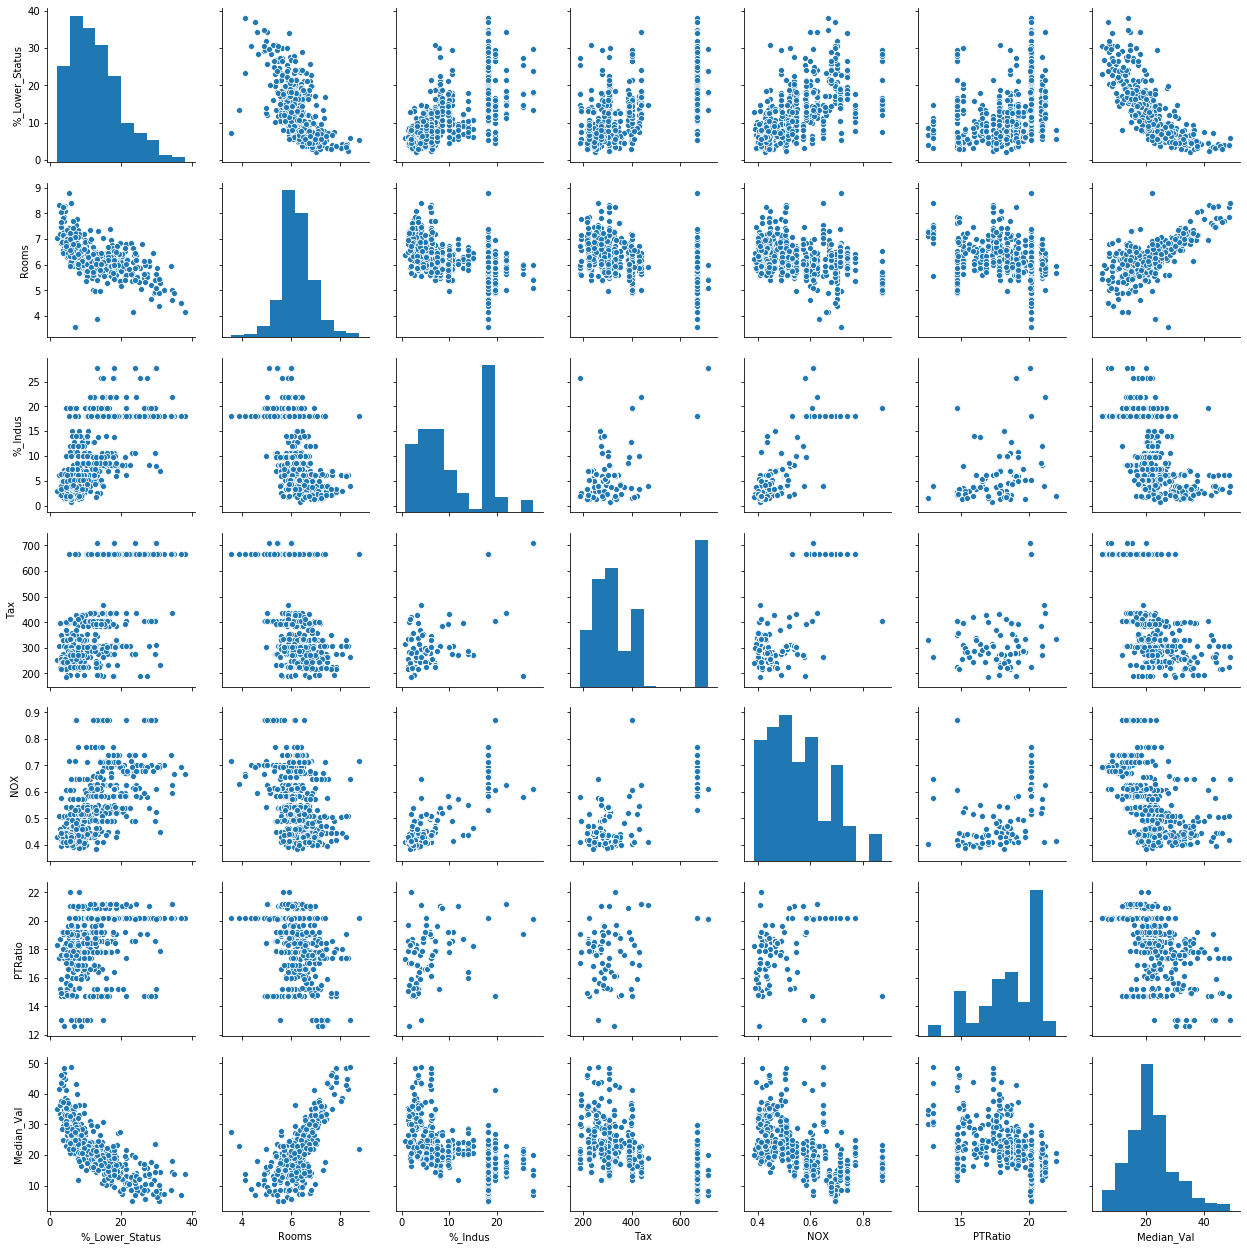

In [125]:
sns.pairplot(high_corr_features)

From looking at the right hand column of the pairplot above, I observed that only % Lower Status and number of Rooms had an obvious relationship with the Median Value. Furthermore, Tax, the % Industrial, and NOX were all corrolated with eachother making them bad features to include in the model.

#### 4.5.2.3 Filtering using F_regression

I also used this test to see if it identified any alternative features vs the corrolation test.

In [126]:
# modification of chi squared test code found here:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
fregX = fifty_plus_removed.iloc[:, 0:13]  
fregy = fifty_plus_removed["Median_Val"]
fregX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [127]:
bestfeatures = SelectKBest(score_func=f_regression, k=10) # show the top 10 best features
fregfit = bestfeatures.fit(fregX,fregy)
dfscores = pd.DataFrame(fregfit.scores_)
dfcolumns = pd.DataFrame(fregX.columns) 
fregfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)
fregfeatureScores.columns = ['Features','Score']  #naming the dataframe columns
print(fregfeatureScores.nlargest(10,'Score'))  #print 10 best features

          Features       Score
12  %_Lower_Status  666.627892
5            Rooms  435.309814
2          %_Indus  274.507475
9              Tax  237.855059
4              NOX  185.148836
10         PTRatio  179.568192
6       %_Pre_1940  156.620474
8   Highway_Access  143.190234
0       Crime_Rate  123.991786
1    %_Large_Plots   95.527784


As with the corrolation test, % Lower Status and Rooms were identified as by far the best predictors.

### 4.5.3 Testing with Filtered Features

In this section I tested to if the performance of the model was improved by using only the two best predictors of the Median Value: % of Lower Status people and the number of Rooms.

In [128]:
# creating a new dataset containing the two inputs and target variable
filtered_features = fifty_plus_removed[["%_Lower_Status","Rooms","Median_Val"]]
filtered_features.head()

,%_Lower_Status,Rooms,Median_Val
0,4.98,6.575,24.0
1,9.14,6.421,21.6
2,4.03,7.185,34.7
3,2.94,6.998,33.4
4,5.33,7.147,36.2


In [129]:
# shuffle again and split into train and test
filtered_features = shuffle(filtered_features)

FFX = filtered_features.drop(labels=['Median_Val'], axis = 1)
FFy = filtered_features['Median_Val']

FFX_train, FFX_test, FFy_train, FFy_test = mod.train_test_split(FFX, FFy, test_size = 0.2)

In [130]:
#check how many datapoints are in the train and test batches
FFX_train.shape, FFX_test.shape

((392, 2), (98, 2))

In [131]:
# new filtered features model
FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 413us/step - loss: 649.9408
Epoch 2/300
392/392 [==============================] - 0s 258us/step - loss: 480.0517
Epoch 3/300
392/392 [==============================] - 0s 303us/step - loss: 290.6254
Epoch 4/300
392/392 [==============================] - 0s 277us/step - loss: 142.9400
Epoch 5/300
392/392 [==============================] - 0s 267us/step - loss: 97.1931
Epoch 6/300
392/392 [==============================] - 0s 268us/step - loss: 80.6695
Epoch 7/300
392/392 [==============================] - 0s 260us/step - loss: 64.9505
Epoch 8/300
392/392 [==============================] - 0s 233us/step - loss: 51.2255
Epoch 9/300
392/392 [==============================] - 0s 318us/step - loss: 40.5547
Epoch 10/300
392/392 [==============================] - 0s 295us/step - loss: 33.0814
Epoch 11/300
392/392 [==============================] - 0s 220us/step - loss: 28.1020
Epoch 12/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 232us/step - loss: 18.2173
Epoch 97/300
392/392 [==============================] - 0s 233us/step - loss: 18.3490
Epoch 98/300
392/392 [==============================] - 0s 257us/step - loss: 18.2037
Epoch 99/300
392/392 [==============================] - 0s 207us/step - loss: 18.1974
Epoch 100/300
392/392 [==============================] - 0s 281us/step - loss: 18.2265
Epoch 101/300
392/392 [==============================] - 0s 266us/step - loss: 18.2323
Epoch 102/300
392/392 [==============================] - 0s 243us/step - loss: 18.2669
Epoch 103/300
392/392 [==============================] - 0s 263us/step - loss: 18.2283
Epoch 104/300
392/392 [==============================] - 0s 280us/step - loss: 18.2951
Epoch 105/300
392/392 [==============================] - 0s 221us/step - loss: 18.2922
Epoch 106/300
392/392 [==============================] - 0s 283us/step - loss: 18.2704
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 253us/step - loss: 18.2804
Epoch 191/300
392/392 [==============================] - 0s 236us/step - loss: 18.3169
Epoch 192/300
392/392 [==============================] - 0s 246us/step - loss: 18.2833
Epoch 193/300
392/392 [==============================] - 0s 253us/step - loss: 18.2208
Epoch 194/300
392/392 [==============================] - 0s 269us/step - loss: 18.3224
Epoch 195/300
392/392 [==============================] - 0s 269us/step - loss: 18.3618
Epoch 196/300
392/392 [==============================] - 0s 225us/step - loss: 18.2655
Epoch 197/300
392/392 [==============================] - 0s 270us/step - loss: 18.2549
Epoch 198/300
392/392 [==============================] - 0s 281us/step - loss: 18.2839
Epoch 199/300
392/392 [==============================] - 0s 233us/step - loss: 18.6823
Epoch 200/300
392/392 [==============================] - 0s 269us/step - loss: 18.2068
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 234us/step - loss: 18.1925
Epoch 285/300
392/392 [==============================] - 0s 239us/step - loss: 18.3164
Epoch 286/300
392/392 [==============================] - 0s 247us/step - loss: 18.2623
Epoch 287/300
392/392 [==============================] - 0s 253us/step - loss: 18.0977
Epoch 288/300
392/392 [==============================] - 0s 231us/step - loss: 18.3384
Epoch 289/300
392/392 [==============================] - 0s 237us/step - loss: 18.1407
Epoch 290/300
392/392 [==============================] - 0s 250us/step - loss: 18.1742
Epoch 291/300
392/392 [==============================] - 0s 250us/step - loss: 18.2367
Epoch 292/300
392/392 [==============================] - 0s 221us/step - loss: 18.2559
Epoch 293/300
392/392 [==============================] - 0s 251us/step - loss: 18.2709
Epoch 294/300
392/392 [==============================] - 0s 246us/step - loss: 18.2016
Epoch 295/300
392/392 [==============================] - 

In [132]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 162us/step


14.034664284209816

**Result:** The result was a MSE of 16.9, drastically worse than the Baseline Test and some of the better performing subsequent models.

#### 4.5.3.1 Filtered Features Standardisation

While initial results for the model using the filtered features were worse than the Baseline, the data had not been standardised yet. The logical next step was to standardise the filtered features and evaluate performance with that data.

In [133]:
#scaling the filtered features
scaler = pre.StandardScaler()
FFX_train = pd.DataFrame(scaler.fit_transform(FFX_train), columns=FFX.columns)
FFX_test = pd.DataFrame(scaler.transform(FFX_test), columns=FFX.columns)

In [134]:
FFX_train.head()

,%_Lower_Status,Rooms
0,1.566824,-1.321930
1,-1.049049,1.083009
2,-0.145695,0.009870
3,1.582522,0.165375
4,-0.498189,0.488703


In [135]:
# model test with normalised input features 

FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 415us/step - loss: 518.3754
Epoch 2/300
392/392 [==============================] - 0s 275us/step - loss: 493.8312
Epoch 3/300
392/392 [==============================] - 0s 265us/step - loss: 461.6920
Epoch 4/300
392/392 [==============================] - 0s 234us/step - loss: 421.2210
Epoch 5/300
392/392 [==============================] - 0s 272us/step - loss: 372.8292
Epoch 6/300
392/392 [==============================] - 0s 247us/step - loss: 319.8013
Epoch 7/300
392/392 [==============================] - 0s 285us/step - loss: 264.8472
Epoch 8/300
392/392 [==============================] - 0s 273us/step - loss: 211.1851
Epoch 9/300
392/392 [==============================] - 0s 251us/step - loss: 162.3888
Epoch 10/300
392/392 [==============================] - 0s 257us/step - loss: 120.5751
Epoch 11/300
392/392 [==============================] - 0s 267us/step - loss: 87.2372
Epoch 12/300
392/392 [==============================]

392/392 [==============================] - 0s 247us/step - loss: 14.1579
Epoch 97/300
392/392 [==============================] - 0s 241us/step - loss: 14.1378
Epoch 98/300
392/392 [==============================] - 0s 235us/step - loss: 14.1552
Epoch 99/300
392/392 [==============================] - 0s 242us/step - loss: 14.1176
Epoch 100/300
392/392 [==============================] - 0s 282us/step - loss: 14.0969
Epoch 101/300
392/392 [==============================] - 0s 239us/step - loss: 14.0915
Epoch 102/300
392/392 [==============================] - 0s 203us/step - loss: 14.1274
Epoch 103/300
392/392 [==============================] - 0s 250us/step - loss: 14.0967
Epoch 104/300
392/392 [==============================] - 0s 231us/step - loss: 14.0539
Epoch 105/300
392/392 [==============================] - 0s 220us/step - loss: 14.0696
Epoch 106/300
392/392 [==============================] - 0s 242us/step - loss: 14.0672
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 223us/step - loss: 13.5310
Epoch 191/300
392/392 [==============================] - 0s 252us/step - loss: 13.5364
Epoch 192/300
392/392 [==============================] - 0s 211us/step - loss: 13.5317
Epoch 193/300
392/392 [==============================] - 0s 268us/step - loss: 13.5502
Epoch 194/300
392/392 [==============================] - 0s 245us/step - loss: 13.5442
Epoch 195/300
392/392 [==============================] - 0s 214us/step - loss: 13.5319
Epoch 196/300
392/392 [==============================] - 0s 257us/step - loss: 13.5383
Epoch 197/300
392/392 [==============================] - 0s 253us/step - loss: 13.5027
Epoch 198/300
392/392 [==============================] - 0s 243us/step - loss: 13.5176
Epoch 199/300
392/392 [==============================] - 0s 227us/step - loss: 13.5050
Epoch 200/300
392/392 [==============================] - 0s 201us/step - loss: 13.4858
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 198us/step - loss: 13.3544
Epoch 284/300
392/392 [==============================] - 0s 239us/step - loss: 13.4214
Epoch 285/300
392/392 [==============================] - 0s 232us/step - loss: 13.3661
Epoch 286/300
392/392 [==============================] - ETA: 0s - loss: 13.44 - 0s 234us/step - loss: 13.3676
Epoch 287/300
392/392 [==============================] - 0s 239us/step - loss: 13.3488
Epoch 288/300
392/392 [==============================] - 0s 235us/step - loss: 13.3689
Epoch 289/300
392/392 [==============================] - 0s 254us/step - loss: 13.3487
Epoch 290/300
392/392 [==============================] - 0s 252us/step - loss: 13.3517
Epoch 291/300
392/392 [==============================] - 0s 271us/step - loss: 13.3493
Epoch 292/300
392/392 [==============================] - 0s 224us/step - loss: 13.3564
Epoch 293/300
392/392 [==============================] - 0s 271us/step - loss: 13.3523
Epoch 294/300
392/392 [==========

In [136]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 102us/step


10.757221221923828

**Result:** MSE was 18.124

Even after the standardisation the performance of the model still failed by a wide marginto beat the Baseline test where all 13 features where included.

#### 4.5.3.2 Filtered Features - Comparing Various Model Configurations

To be sure that not improvements using the filtered set were possible I tested serveral different model configurations. 

In [137]:
# function to test various model configurations on the filter features dataset
def FF_tester(layer_size1, layer_size2, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(layer_size2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [138]:
#big_all_adam = FF_tester(64,64,32,"adam") # large layers, large batches, adam optimizer
#big_all_adam

In [139]:
#bigLayer_mediumbatch_adam = FF_tester(64,64,16,"adam") # large layers, large batches, adam optimizer
#bigLayer_smallbatch_adam = FF_tester(64,64,4,"adam")

In [140]:
#print(bigLayer_mediumbatch_adam)

In [141]:
# print(bigLayer_smallbatch_adam)

In [142]:
# mediumLayer_bigbatch_adam = FF_tester(32,12,32,"adam")
# mediumLayer_mediumbatch_adam  = FF_tester(32,12,16,"adam")
# mediumLayer_smallbatch_adam  = FF_tester(32,12,4,"adam")

In [143]:
# print(mediumLayer_bigbatch_adam)
# print(mediumLayer_mediumbatch_adam)
# print(mediumLayer_smallbatch_adam)

In [144]:
#smallLayer_bigbatch_adam  = FF_tester(12,6,32,"adam")
#smallLayer_mediumbatch_adam  = FF_tester(12,6,16,"adam")
#smallLayer_smallbatch_adam  = FF_tester(12,6,4,"adam")
# tinyLayer_smallbatch_adam = FF_tester(2,2,4,"adam")

In [145]:
# print(smallLayer_bigbatch_adam)
# print(smallLayer_mediumbatch_adam)
# print(smallLayer_smallbatch_adam)
# print(tinyLayer_smallbatch_adam)

**Result:** Medium layer sizes seemed to peform the best, but still did not better the original baseline test. Next I tried removing a layer.

In [146]:
def FF_tester_1layer(layer_size1, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [147]:
# hugelayer = FF_tester_1layer(64, 4, "adam")
# biglayer = FF_tester_1layer(32, 4, "adam")
# mediumlayer = FF_tester_1layer(12, 4, "adam")
# smalllayer = FF_tester_1layer(6, 4, "adam")


In [148]:
# print(hugelayer)
# print(biglayer)
# print(mediumlayer)
# print(smalllayer)

**Result:** Again, there didn't seem to be any drastic improvements and the results were still not beating the initial Baseline Test on all features. 

## 4.6 Conclusion and Final Model

In this final section, I retested the best performing models from above to determine the final model. For the re-test I used the dataset with all variables included, but with the samples that had a Median Value of 50,000 removed. 

In [149]:
final_model_df = fifty_plus_removed
final_model_df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [150]:
# suffling the data 
final_model_df = shuffle(final_model_df)
final_model_df

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
250,0.14030,22.0,5.86,0.0,0.431,6.487,13.0,7.3967,7.0,330.0,19.1,396.28,5.90,24.4
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5.0,296.0,16.6,393.23,10.11,23.2
197,0.04666,80.0,1.52,0.0,0.404,7.107,36.6,7.3090,2.0,329.0,12.6,354.31,8.61,30.3
243,0.12757,30.0,4.93,0.0,0.428,6.393,7.8,7.0355,6.0,300.0,16.6,374.71,5.19,23.7
114,0.14231,0.0,10.01,0.0,0.547,6.254,84.2,2.2565,6.0,432.0,17.8,388.74,10.45,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,37.66190,0.0,18.10,0.0,0.679,6.202,78.7,1.8629,24.0,666.0,20.2,18.82,14.52,10.9
431,10.06230,0.0,18.10,0.0,0.584,6.833,94.3,2.0882,24.0,666.0,20.2,81.33,19.69,14.1
43,0.15936,0.0,6.91,0.0,0.448,6.211,6.5,5.7209,3.0,233.0,17.9,394.46,7.44,24.7
309,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3


In [163]:
# creating the input and out datasets for the final tests
FinalX = final_model_df.drop(labels=['Median_Val'], axis = 1)
Finaly = final_model_df['Median_Val']

FinalX_train, FinalX_test, Finaly_train, Finaly_test = mod.train_test_split(FinalX, Finaly, test_size = 0.2)

In [164]:
FinalX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
250,0.14030,22.0,5.86,0.0,0.431,6.487,13.0,7.3967,7.0,330.0,19.1,396.28,5.90
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5.0,296.0,16.6,393.23,10.11
197,0.04666,80.0,1.52,0.0,0.404,7.107,36.6,7.3090,2.0,329.0,12.6,354.31,8.61
243,0.12757,30.0,4.93,0.0,0.428,6.393,7.8,7.0355,6.0,300.0,16.6,374.71,5.19
114,0.14231,0.0,10.01,0.0,0.547,6.254,84.2,2.2565,6.0,432.0,17.8,388.74,10.45


In [165]:
# scaling the data
scaler = pre.StandardScaler()
FinalX_train = pd.DataFrame(scaler.fit_transform(FinalX_train), columns=FinalX.columns)
FinalX_test = pd.DataFrame(scaler.transform(FinalX_test), columns=FinalX.columns)

In [166]:
FinalX_train.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.400861,-0.480405,-0.409820,-0.243843,-0.300225,-0.595646,1.002915,-0.826516,-0.521692,-0.141913,1.138328,0.413297,0.493942
1,-0.398891,0.604631,-0.913897,-0.243843,-0.871712,-0.764948,-0.052135,1.590933,-0.174880,-0.739504,0.564467,0.425062,0.032198
2,-0.127528,-0.480405,1.209694,-0.243843,0.424797,0.252402,0.951027,-0.753027,-0.521692,-0.028370,-1.826619,-0.297174,-0.222318
3,0.685232,-0.480405,0.992191,-0.243843,1.055992,0.218541,0.964864,-0.892023,1.674783,1.543296,0.803576,-3.286460,1.552337
4,-0.412919,-0.480405,-0.905079,-0.243843,-0.342873,-0.527925,-0.280441,0.830347,-0.521692,-1.098059,0.803576,0.421733,-0.328018


In [167]:
#test final model option 1
def Final_tester(layer_size1, layer_size2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(layer_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(layer_size2, activation="relu"))
        m.add(ks.layers.Dense(1,activation="linear"))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=20, verbose=1)

        m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(FinalX_test, Finaly_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [168]:
final_results = [
    Final_tester(13, 13),
    Final_tester(26, 26),
    Final_tester(26, 13),
    Final_tester(52, 26),
    Final_tester(64, 13)
]

Epoch 1/300
392/392 [==============================] - 0s 467us/step - loss: 524.2616
Epoch 2/300
392/392 [==============================] - 0s 304us/step - loss: 481.1491
Epoch 3/300
392/392 [==============================] - 0s 310us/step - loss: 368.5461
Epoch 4/300
392/392 [==============================] - 0s 260us/step - loss: 167.4498
Epoch 5/300
392/392 [==============================] - 0s 239us/step - loss: 50.0259
Epoch 6/300
392/392 [==============================] - 0s 275us/step - loss: 29.4591
Epoch 7/300
392/392 [==============================] - 0s 223us/step - loss: 23.4368
Epoch 8/300
392/392 [==============================] - 0s 272us/step - loss: 20.4830
Epoch 9/300
392/392 [==============================] - 0s 226us/step - loss: 18.7004
Epoch 10/300
392/392 [==============================] - 0s 308us/step - loss: 17.5128
Epoch 11/300
392/392 [==============================] - 0s 287us/step - loss: 16.5008
Epoch 12/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 280us/step - loss: 4.5708
Epoch 98/300
392/392 [==============================] - 0s 308us/step - loss: 4.5515
Epoch 99/300
392/392 [==============================] - 0s 280us/step - loss: 4.5613
Epoch 100/300
392/392 [==============================] - 0s 238us/step - loss: 4.5383
Epoch 101/300
392/392 [==============================] - 0s 264us/step - loss: 4.4659
Epoch 102/300
392/392 [==============================] - 0s 277us/step - loss: 4.5206
Epoch 103/300
392/392 [==============================] - 0s 233us/step - loss: 4.5028
Epoch 104/300
392/392 [==============================] - 0s 225us/step - loss: 4.4416
Epoch 105/300
392/392 [==============================] - 0s 275us/step - loss: 4.3924
Epoch 106/300
392/392 [==============================] - 0s 259us/step - loss: 4.4099
Epoch 107/300
392/392 [==============================] - 0s 237us/step - loss: 4.3395
Epoch 108/300
392/392 [==============================] - 0s 249us/step

392/392 [==============================] - 0s 244us/step - loss: 3.2546
Epoch 193/300
392/392 [==============================] - 0s 247us/step - loss: 3.1788
Epoch 194/300
392/392 [==============================] - 0s 217us/step - loss: 3.1457
Epoch 195/300
392/392 [==============================] - 0s 254us/step - loss: 3.1625
Epoch 196/300
392/392 [==============================] - 0s 231us/step - loss: 3.1517
Epoch 197/300
392/392 [==============================] - 0s 262us/step - loss: 3.1294
Epoch 198/300
392/392 [==============================] - 0s 260us/step - loss: 3.1322
Epoch 199/300
392/392 [==============================] - 0s 252us/step - loss: 3.0863
Epoch 200/300
392/392 [==============================] - 0s 252us/step - loss: 3.0884
Epoch 201/300
392/392 [==============================] - 0s 263us/step - loss: 3.0965
Epoch 202/300
392/392 [==============================] - 0s 242us/step - loss: 3.1278
Epoch 203/300
392/392 [==============================] - 0s 272us/st

392/392 [==============================] - 0s 265us/step - loss: 2.6616
Epoch 288/300
392/392 [==============================] - 0s 270us/step - loss: 2.5702
Epoch 289/300
392/392 [==============================] - 0s 228us/step - loss: 2.6122
Epoch 290/300
392/392 [==============================] - 0s 253us/step - loss: 2.5800
Epoch 291/300
392/392 [==============================] - 0s 255us/step - loss: 2.5725
Epoch 292/300
392/392 [==============================] - 0s 261us/step - loss: 2.5684
Epoch 293/300
392/392 [==============================] - 0s 251us/step - loss: 2.5338
Epoch 294/300
392/392 [==============================] - 0s 247us/step - loss: 2.6043
Epoch 295/300
392/392 [==============================] - 0s 266us/step - loss: 2.5395
Epoch 296/300
392/392 [==============================] - 0s 261us/step - loss: 2.5575
Epoch 297/300
392/392 [==============================] - 0s 244us/step - loss: 2.5053
Epoch 298/300
392/392 [==============================] - 0s 272us/st

392/392 [==============================] - 0s 230us/step - loss: 4.9307
Epoch 83/300
392/392 [==============================] - 0s 251us/step - loss: 4.7725
Epoch 84/300
392/392 [==============================] - 0s 258us/step - loss: 4.8683
Epoch 85/300
392/392 [==============================] - 0s 277us/step - loss: 4.8531
Epoch 86/300
392/392 [==============================] - 0s 240us/step - loss: 4.7718
Epoch 87/300
392/392 [==============================] - 0s 258us/step - loss: 4.8324
Epoch 88/300
392/392 [==============================] - 0s 256us/step - loss: 4.7208
Epoch 89/300
392/392 [==============================] - 0s 241us/step - loss: 4.7815
Epoch 90/300
392/392 [==============================] - 0s 235us/step - loss: 4.7320
Epoch 91/300
392/392 [==============================] - 0s 277us/step - loss: 4.6370
Epoch 92/300
392/392 [==============================] - 0s 264us/step - loss: 4.7616
Epoch 93/300
392/392 [==============================] - 0s 234us/step - loss: 

392/392 [==============================] - 0s 291us/step - loss: 4.0613
Epoch 178/300
392/392 [==============================] - 0s 280us/step - loss: 3.8923
Epoch 179/300
392/392 [==============================] - 0s 269us/step - loss: 3.8992
Epoch 180/300
392/392 [==============================] - 0s 289us/step - loss: 3.8988
Epoch 181/300
392/392 [==============================] - 0s 239us/step - loss: 3.8672
Epoch 182/300
392/392 [==============================] - 0s 296us/step - loss: 4.0457
Epoch 183/300
392/392 [==============================] - 0s 272us/step - loss: 3.9290
Epoch 184/300
392/392 [==============================] - 0s 243us/step - loss: 3.8511
Epoch 185/300
392/392 [==============================] - 0s 234us/step - loss: 3.9831
Epoch 186/300
392/392 [==============================] - 0s 231us/step - loss: 3.8236
Epoch 187/300
392/392 [==============================] - 0s 305us/step - loss: 3.8409
Epoch 188/300
392/392 [==============================] - 0s 245us/st

392/392 [==============================] - 0s 226us/step - loss: 3.3356
Epoch 273/300
392/392 [==============================] - 0s 246us/step - loss: 3.2890
Epoch 274/300
392/392 [==============================] - 0s 285us/step - loss: 3.2368
Epoch 275/300
392/392 [==============================] - 0s 262us/step - loss: 3.2678
Epoch 276/300
392/392 [==============================] - 0s 268us/step - loss: 3.2523
Epoch 277/300
392/392 [==============================] - 0s 223us/step - loss: 3.2461
Epoch 278/300
392/392 [==============================] - 0s 268us/step - loss: 3.1444
Epoch 279/300
392/392 [==============================] - 0s 280us/step - loss: 3.2494
Epoch 280/300
392/392 [==============================] - 0s 277us/step - loss: 3.2268
Epoch 281/300
392/392 [==============================] - 0s 277us/step - loss: 3.2715
Epoch 282/300
392/392 [==============================] - 0s 218us/step - loss: 3.2133
Epoch 283/300
392/392 [==============================] - 0s 285us/st

392/392 [==============================] - 0s 275us/step - loss: 4.9243
Epoch 68/300
392/392 [==============================] - 0s 274us/step - loss: 4.8410
Epoch 69/300
392/392 [==============================] - 0s 270us/step - loss: 4.8410
Epoch 70/300
392/392 [==============================] - 0s 277us/step - loss: 4.8595
Epoch 71/300
392/392 [==============================] - 0s 257us/step - loss: 4.7432
Epoch 72/300
392/392 [==============================] - 0s 265us/step - loss: 4.7469
Epoch 73/300
392/392 [==============================] - 0s 223us/step - loss: 4.8668
Epoch 74/300
392/392 [==============================] - 0s 269us/step - loss: 4.7994
Epoch 75/300
392/392 [==============================] - 0s 275us/step - loss: 4.6930
Epoch 76/300
392/392 [==============================] - 0s 300us/step - loss: 4.8207
Epoch 77/300
392/392 [==============================] - 0s 249us/step - loss: 4.6087
Epoch 78/300
392/392 [==============================] - 0s 239us/step - loss: 

392/392 [==============================] - 0s 275us/step - loss: 3.6377
Epoch 163/300
392/392 [==============================] - 0s 295us/step - loss: 3.4814
Epoch 164/300
392/392 [==============================] - 0s 265us/step - loss: 3.5345
Epoch 165/300
392/392 [==============================] - 0s 262us/step - loss: 3.5520
Epoch 166/300
392/392 [==============================] - 0s 258us/step - loss: 3.5253
Epoch 167/300
392/392 [==============================] - 0s 268us/step - loss: 3.5676
Epoch 168/300
392/392 [==============================] - 0s 237us/step - loss: 3.4670
Epoch 169/300
392/392 [==============================] - 0s 272us/step - loss: 3.4577
Epoch 170/300
392/392 [==============================] - 0s 256us/step - loss: 3.4575
Epoch 171/300
392/392 [==============================] - 0s 244us/step - loss: 3.5283
Epoch 172/300
392/392 [==============================] - 0s 282us/step - loss: 3.4464
Epoch 173/300
392/392 [==============================] - 0s 274us/st

392/392 [==============================] - 0s 216us/step - loss: 3.0575
Epoch 258/300
392/392 [==============================] - 0s 273us/step - loss: 3.0739
Epoch 259/300
392/392 [==============================] - 0s 257us/step - loss: 3.0847
Epoch 260/300
392/392 [==============================] - 0s 225us/step - loss: 3.0438
Epoch 261/300
392/392 [==============================] - 0s 239us/step - loss: 3.0641
Epoch 262/300
392/392 [==============================] - 0s 262us/step - loss: 3.0179
Epoch 263/300
392/392 [==============================] - 0s 288us/step - loss: 3.0010
Epoch 264/300
392/392 [==============================] - 0s 254us/step - loss: 3.0180
Epoch 265/300
392/392 [==============================] - 0s 249us/step - loss: 3.0317
Epoch 266/300
392/392 [==============================] - 0s 275us/step - loss: 3.0668
Epoch 267/300
392/392 [==============================] - 0s 212us/step - loss: 3.0237
Epoch 268/300
392/392 [==============================] - 0s 255us/st

Epoch 52/300
392/392 [==============================] - 0s 298us/step - loss: 4.8573
Epoch 53/300
392/392 [==============================] - 0s 287us/step - loss: 4.8839
Epoch 54/300
392/392 [==============================] - 0s 283us/step - loss: 4.7715
Epoch 55/300
392/392 [==============================] - 0s 268us/step - loss: 4.7986
Epoch 56/300
392/392 [==============================] - 0s 304us/step - loss: 4.6987
Epoch 57/300
392/392 [==============================] - 0s 272us/step - loss: 4.6564
Epoch 58/300
392/392 [==============================] - 0s 289us/step - loss: 4.5879
Epoch 59/300
392/392 [==============================] - 0s 222us/step - loss: 4.6156
Epoch 60/300
392/392 [==============================] - 0s 295us/step - loss: 4.6241
Epoch 61/300
392/392 [==============================] - 0s 309us/step - loss: 4.5861
Epoch 62/300
392/392 [==============================] - 0s 282us/step - loss: 4.5295
Epoch 63/300
392/392 [==============================] - 0s 246us/

392/392 [==============================] - 0s 270us/step - loss: 3.2137
Epoch 148/300
392/392 [==============================] - 0s 261us/step - loss: 3.2249
Epoch 149/300
392/392 [==============================] - 0s 260us/step - loss: 3.2522
Epoch 150/300
392/392 [==============================] - 0s 232us/step - loss: 3.2639
Epoch 151/300
392/392 [==============================] - 0s 234us/step - loss: 3.2191
Epoch 152/300
392/392 [==============================] - 0s 305us/step - loss: 3.1814
Epoch 153/300
392/392 [==============================] - 0s 271us/step - loss: 3.2727
Epoch 154/300
392/392 [==============================] - 0s 237us/step - loss: 3.1630
Epoch 155/300
392/392 [==============================] - 0s 321us/step - loss: 3.1214
Epoch 156/300
392/392 [==============================] - 0s 270us/step - loss: 3.1693
Epoch 157/300
392/392 [==============================] - 0s 285us/step - loss: 3.2960
Epoch 158/300
392/392 [==============================] - 0s 215us/st

392/392 [==============================] - 0s 240us/step - loss: 2.6236
Epoch 243/300
392/392 [==============================] - 0s 265us/step - loss: 2.6836
Epoch 244/300
392/392 [==============================] - 0s 233us/step - loss: 2.5687
Epoch 245/300
392/392 [==============================] - 0s 283us/step - loss: 2.6095
Epoch 246/300
392/392 [==============================] - 0s 256us/step - loss: 2.6308
Epoch 247/300
392/392 [==============================] - 0s 246us/step - loss: 2.5992
Epoch 248/300
392/392 [==============================] - 0s 295us/step - loss: 2.6075
Epoch 249/300
392/392 [==============================] - 0s 282us/step - loss: 2.6489
Epoch 250/300
392/392 [==============================] - 0s 272us/step - loss: 2.6163
Epoch 251/300
392/392 [==============================] - 0s 286us/step - loss: 2.6694
Epoch 252/300
392/392 [==============================] - 0s 315us/step - loss: 2.6469
Epoch 253/300
392/392 [==============================] - 0s 231us/st

392/392 [==============================] - 0s 254us/step - loss: 7.0619
Epoch 37/300
392/392 [==============================] - 0s 288us/step - loss: 6.9099
Epoch 38/300
392/392 [==============================] - 0s 295us/step - loss: 6.9428
Epoch 39/300
392/392 [==============================] - 0s 239us/step - loss: 6.8100
Epoch 40/300
392/392 [==============================] - 0s 234us/step - loss: 6.6809
Epoch 41/300
392/392 [==============================] - 0s 275us/step - loss: 6.5537
Epoch 42/300
392/392 [==============================] - 0s 239us/step - loss: 6.5124
Epoch 43/300
392/392 [==============================] - 0s 310us/step - loss: 6.3869
Epoch 44/300
392/392 [==============================] - 0s 300us/step - loss: 6.3282
Epoch 45/300
392/392 [==============================] - 0s 295us/step - loss: 6.3004
Epoch 46/300
392/392 [==============================] - 0s 300us/step - loss: 6.1611
Epoch 47/300
392/392 [==============================] - 0s 293us/step - loss: 

392/392 [==============================] - 0s 259us/step - loss: 3.8728
Epoch 132/300
392/392 [==============================] - 0s 239us/step - loss: 3.8783
Epoch 133/300
392/392 [==============================] - 0s 235us/step - loss: 3.8673
Epoch 134/300
392/392 [==============================] - 0s 257us/step - loss: 3.8098
Epoch 135/300
392/392 [==============================] - 0s 257us/step - loss: 3.7911
Epoch 136/300
392/392 [==============================] - 0s 260us/step - loss: 3.8334
Epoch 137/300
392/392 [==============================] - 0s 265us/step - loss: 3.7795
Epoch 138/300
392/392 [==============================] - 0s 232us/step - loss: 3.7202
Epoch 139/300
392/392 [==============================] - 0s 257us/step - loss: 3.8138
Epoch 140/300
392/392 [==============================] - 0s 257us/step - loss: 3.7353
Epoch 141/300
392/392 [==============================] - 0s 272us/step - loss: 3.6790
Epoch 142/300
392/392 [==============================] - 0s 233us/st

392/392 [==============================] - 0s 258us/step - loss: 3.0517
Epoch 227/300
392/392 [==============================] - 0s 244us/step - loss: 3.0084
Epoch 228/300
392/392 [==============================] - 0s 272us/step - loss: 2.9938
Epoch 229/300
392/392 [==============================] - 0s 282us/step - loss: 3.0430
Epoch 230/300
392/392 [==============================] - 0s 219us/step - loss: 2.9598
Epoch 231/300
392/392 [==============================] - 0s 267us/step - loss: 3.0332
Epoch 232/300
392/392 [==============================] - 0s 236us/step - loss: 3.0089
Epoch 233/300
392/392 [==============================] - 0s 235us/step - loss: 2.9176
Epoch 234/300
392/392 [==============================] - 0s 258us/step - loss: 3.0686
Epoch 235/300
392/392 [==============================] - 0s 254us/step - loss: 2.9899
Epoch 236/300
392/392 [==============================] - 0s 263us/step - loss: 3.0076
Epoch 237/300
392/392 [==============================] - 0s 247us/st

Epoch 21/300
392/392 [==============================] - 0s 315us/step - loss: 7.1155
Epoch 22/300
392/392 [==============================] - 0s 280us/step - loss: 6.9660
Epoch 23/300
392/392 [==============================] - 0s 218us/step - loss: 6.9254
Epoch 24/300
392/392 [==============================] - 0s 270us/step - loss: 6.7147
Epoch 25/300
392/392 [==============================] - 0s 277us/step - loss: 6.5487
Epoch 26/300
392/392 [==============================] - 0s 281us/step - loss: 6.3938
Epoch 27/300
392/392 [==============================] - 0s 257us/step - loss: 6.5360
Epoch 28/300
392/392 [==============================] - 0s 227us/step - loss: 6.3679
Epoch 29/300
392/392 [==============================] - 0s 220us/step - loss: 6.2809
Epoch 30/300
392/392 [==============================] - 0s 279us/step - loss: 6.3722
Epoch 31/300
392/392 [==============================] - 0s 245us/step - loss: 6.1645
Epoch 32/300
392/392 [==============================] - 0s 255us/

392/392 [==============================] - 0s 277us/step - loss: 3.2495
Epoch 117/300
392/392 [==============================] - 0s 295us/step - loss: 3.2210
Epoch 118/300
392/392 [==============================] - 0s 257us/step - loss: 3.4123
Epoch 119/300
392/392 [==============================] - 0s 277us/step - loss: 3.2583
Epoch 120/300
392/392 [==============================] - 0s 234us/step - loss: 3.4926
Epoch 121/300
392/392 [==============================] - 0s 286us/step - loss: 3.1925
Epoch 122/300
392/392 [==============================] - 0s 303us/step - loss: 3.2018
Epoch 123/300
392/392 [==============================] - 0s 305us/step - loss: 3.1829
Epoch 124/300
392/392 [==============================] - 0s 258us/step - loss: 3.2365
Epoch 125/300
392/392 [==============================] - 0s 232us/step - loss: 3.1283
Epoch 126/300
392/392 [==============================] - 0s 252us/step - loss: 3.1989
Epoch 127/300
392/392 [==============================] - 0s 244us/st

392/392 [==============================] - 0s 280us/step - loss: 2.0600
Epoch 212/300
392/392 [==============================] - 0s 245us/step - loss: 2.0756
Epoch 213/300
392/392 [==============================] - 0s 239us/step - loss: 2.0203
Epoch 214/300
392/392 [==============================] - 0s 265us/step - loss: 2.0605
Epoch 215/300
392/392 [==============================] - 0s 248us/step - loss: 2.1042
Epoch 216/300
392/392 [==============================] - 0s 251us/step - loss: 2.0875
Epoch 217/300
392/392 [==============================] - 0s 252us/step - loss: 2.0942
Epoch 218/300
392/392 [==============================] - 0s 283us/step - loss: 2.0181
Epoch 219/300
392/392 [==============================] - 0s 255us/step - loss: 2.1727
Epoch 220/300
392/392 [==============================] - 0s 252us/step - loss: 2.0477
Epoch 221/300
392/392 [==============================] - 0s 254us/step - loss: 2.1271
Epoch 222/300
392/392 [==============================] - 0s 258us/st

392/392 [==============================] - 0s 271us/step - loss: 15.5721
Epoch 6/300
392/392 [==============================] - 0s 290us/step - loss: 13.3000
Epoch 7/300
392/392 [==============================] - 0s 270us/step - loss: 11.8839
Epoch 8/300
392/392 [==============================] - 0s 295us/step - loss: 10.8934
Epoch 9/300
392/392 [==============================] - 0s 280us/step - loss: 10.1471
Epoch 10/300
392/392 [==============================] - 0s 277us/step - loss: 9.4773
Epoch 11/300
392/392 [==============================] - 0s 280us/step - loss: 8.9729
Epoch 12/300
392/392 [==============================] - 0s 250us/step - loss: 8.4921
Epoch 13/300
392/392 [==============================] - 0s 241us/step - loss: 8.0868
Epoch 14/300
392/392 [==============================] - 0s 251us/step - loss: 7.7052
Epoch 15/300
392/392 [==============================] - 0s 247us/step - loss: 7.4226
Epoch 16/300
392/392 [==============================] - 0s 270us/step - loss:

392/392 [==============================] - 0s 255us/step - loss: 3.0953
Epoch 102/300
392/392 [==============================] - 0s 269us/step - loss: 3.0277
Epoch 103/300
392/392 [==============================] - 0s 235us/step - loss: 2.9834
Epoch 104/300
392/392 [==============================] - 0s 285us/step - loss: 3.0456
Epoch 105/300
392/392 [==============================] - 0s 241us/step - loss: 2.9064
Epoch 106/300
392/392 [==============================] - 0s 221us/step - loss: 2.9746
Epoch 107/300
392/392 [==============================] - 0s 279us/step - loss: 3.0218
Epoch 108/300
392/392 [==============================] - 0s 297us/step - loss: 2.9285
Epoch 109/300
392/392 [==============================] - 0s 298us/step - loss: 2.9223
Epoch 110/300
392/392 [==============================] - 0s 284us/step - loss: 2.7787
Epoch 111/300
392/392 [==============================] - 0s 272us/step - loss: 2.9320
Epoch 112/300
392/392 [==============================] - 0s 270us/st

392/392 [==============================] - 0s 242us/step - loss: 2.0315
Epoch 197/300
392/392 [==============================] - 0s 290us/step - loss: 1.9997
Epoch 198/300
392/392 [==============================] - 0s 260us/step - loss: 2.1687
Epoch 199/300
392/392 [==============================] - 0s 226us/step - loss: 2.0180
Epoch 200/300
392/392 [==============================] - 0s 275us/step - loss: 2.0265
Epoch 201/300
392/392 [==============================] - 0s 308us/step - loss: 1.9296
Epoch 202/300
392/392 [==============================] - 0s 280us/step - loss: 1.9586
Epoch 203/300
392/392 [==============================] - 0s 285us/step - loss: 1.9346
Epoch 204/300
392/392 [==============================] - 0s 249us/step - loss: 1.8932
Epoch 205/300
392/392 [==============================] - 0s 240us/step - loss: 1.8813
Epoch 206/300
392/392 [==============================] - 0s 260us/step - loss: 2.0799
Epoch 207/300
392/392 [==============================] - 0s 247us/st

392/392 [==============================] - 0s 222us/step - loss: 1.4923
Epoch 292/300
392/392 [==============================] - 0s 298us/step - loss: 1.4942
Epoch 293/300
392/392 [==============================] - 0s 254us/step - loss: 1.4516
Epoch 294/300
392/392 [==============================] - 0s 253us/step - loss: 1.4682
Epoch 295/300
392/392 [==============================] - 0s 237us/step - loss: 1.5459
Epoch 296/300
392/392 [==============================] - 0s 247us/step - loss: 1.4609
Epoch 297/300
392/392 [==============================] - 0s 247us/step - loss: 1.5285
Epoch 298/300
392/392 [==============================] - 0s 252us/step - loss: 1.4740
Epoch 299/300
392/392 [==============================] - 0s 233us/step - loss: 1.5566
Epoch 300/300
98/98 [==============================] - 0s 132us/step
Epoch 1/300
392/392 [==============================] - 0s 456us/step - loss: 470.5914
Epoch 2/300
392/392 [==============================] - 0s 291us/step - loss: 207.3246

392/392 [==============================] - 0s 252us/step - loss: 3.4739
Epoch 87/300
392/392 [==============================] - 0s 260us/step - loss: 3.4385
Epoch 88/300
392/392 [==============================] - 0s 282us/step - loss: 3.5565
Epoch 89/300
392/392 [==============================] - 0s 247us/step - loss: 3.3392
Epoch 90/300
392/392 [==============================] - 0s 225us/step - loss: 3.3388
Epoch 91/300
392/392 [==============================] - 0s 295us/step - loss: 3.2817
Epoch 92/300
392/392 [==============================] - 0s 245us/step - loss: 3.2476
Epoch 93/300
392/392 [==============================] - 0s 270us/step - loss: 3.2628
Epoch 94/300
392/392 [==============================] - 0s 282us/step - loss: 3.3280
Epoch 95/300
392/392 [==============================] - 0s 277us/step - loss: 3.2301
Epoch 96/300
392/392 [==============================] - 0s 275us/step - loss: 3.2754
Epoch 97/300
392/392 [==============================] - 0s 290us/step - loss: 

392/392 [==============================] - 0s 260us/step - loss: 2.0230
Epoch 182/300
392/392 [==============================] - 0s 300us/step - loss: 2.0341
Epoch 183/300
392/392 [==============================] - 0s 293us/step - loss: 2.1354
Epoch 184/300
392/392 [==============================] - 0s 295us/step - loss: 2.0979
Epoch 185/300
392/392 [==============================] - 0s 293us/step - loss: 2.0654
Epoch 186/300
392/392 [==============================] - 0s 298us/step - loss: 2.1730
Epoch 187/300
392/392 [==============================] - 0s 290us/step - loss: 1.9982
Epoch 188/300
392/392 [==============================] - 0s 262us/step - loss: 2.1001
Epoch 189/300
392/392 [==============================] - 0s 257us/step - loss: 2.0929
Epoch 190/300
392/392 [==============================] - 0s 226us/step - loss: 2.1184
Epoch 191/300
392/392 [==============================] - 0s 275us/step - loss: 2.0682
Epoch 192/300
392/392 [==============================] - 0s 278us/st

392/392 [==============================] - 0s 257us/step - loss: 1.5232
Epoch 277/300
392/392 [==============================] - 0s 272us/step - loss: 1.5506
Epoch 278/300
392/392 [==============================] - 0s 267us/step - loss: 1.5233
Epoch 279/300
392/392 [==============================] - 0s 276us/step - loss: 1.5748
Epoch 280/300
392/392 [==============================] - 0s 239us/step - loss: 1.4985
Epoch 281/300
392/392 [==============================] - 0s 290us/step - loss: 1.5698
Epoch 282/300
392/392 [==============================] - 0s 270us/step - loss: 1.5391
Epoch 283/300
392/392 [==============================] - 0s 290us/step - loss: 1.4906
Epoch 284/300
392/392 [==============================] - 0s 260us/step - loss: 1.6472
Epoch 285/300
392/392 [==============================] - 0s 242us/step - loss: 1.5937
Epoch 286/300
392/392 [==============================] - 0s 235us/step - loss: 1.4474
Epoch 287/300
392/392 [==============================] - 0s 243us/st

392/392 [==============================] - 0s 273us/step - loss: 4.1171
Epoch 72/300
392/392 [==============================] - 0s 328us/step - loss: 4.1580
Epoch 73/300
392/392 [==============================] - 0s 341us/step - loss: 4.1381
Epoch 74/300
392/392 [==============================] - 0s 372us/step - loss: 4.1620
Epoch 75/300
392/392 [==============================] - 0s 280us/step - loss: 4.0426
Epoch 76/300
392/392 [==============================] - 0s 233us/step - loss: 4.0344
Epoch 77/300
392/392 [==============================] - 0s 251us/step - loss: 4.0786
Epoch 78/300
392/392 [==============================] - 0s 229us/step - loss: 3.9253
Epoch 79/300
392/392 [==============================] - 0s 282us/step - loss: 3.9478
Epoch 80/300
392/392 [==============================] - 0s 287us/step - loss: 4.0213
Epoch 81/300
392/392 [==============================] - 0s 290us/step - loss: 3.9061
Epoch 82/300
392/392 [==============================] - 0s 222us/step - loss: 

392/392 [==============================] - 0s 253us/step - loss: 2.6928
Epoch 167/300
392/392 [==============================] - 0s 339us/step - loss: 2.7335
Epoch 168/300
392/392 [==============================] - 0s 332us/step - loss: 2.7488
Epoch 169/300
392/392 [==============================] - 0s 340us/step - loss: 2.7051
Epoch 170/300
392/392 [==============================] - 0s 272us/step - loss: 2.6426
Epoch 171/300
392/392 [==============================] - 0s 225us/step - loss: 2.6701
Epoch 172/300
392/392 [==============================] - 0s 265us/step - loss: 2.5498
Epoch 173/300
392/392 [==============================] - 0s 254us/step - loss: 2.7566
Epoch 174/300
392/392 [==============================] - 0s 286us/step - loss: 2.7004
Epoch 175/300
392/392 [==============================] - 0s 225us/step - loss: 2.5578
Epoch 176/300
392/392 [==============================] - 0s 399us/step - loss: 2.6479
Epoch 177/300
392/392 [==============================] - 0s 266us/st

392/392 [==============================] - 0s 399us/step - loss: 1.9423
Epoch 262/300
392/392 [==============================] - 0s 287us/step - loss: 1.9580
Epoch 263/300
392/392 [==============================] - 0s 217us/step - loss: 1.8724
Epoch 264/300
392/392 [==============================] - 0s 270us/step - loss: 1.8731
Epoch 265/300
392/392 [==============================] - 0s 259us/step - loss: 1.8861
Epoch 266/300
392/392 [==============================] - 0s 279us/step - loss: 1.8914
Epoch 267/300
392/392 [==============================] - 0s 328us/step - loss: 1.8718
Epoch 268/300
392/392 [==============================] - 0s 323us/step - loss: 1.8964
Epoch 269/300
392/392 [==============================] - 0s 335us/step - loss: 1.9067
Epoch 270/300
392/392 [==============================] - 0s 270us/step - loss: 2.0517
Epoch 271/300
392/392 [==============================] - 0s 311us/step - loss: 1.9214
Epoch 272/300
392/392 [==============================] - 0s 326us/st

392/392 [==============================] - 0s 389us/step - loss: 4.7950
Epoch 57/300
392/392 [==============================] - 0s 422us/step - loss: 4.5270
Epoch 58/300
392/392 [==============================] - 0s 461us/step - loss: 4.4137
Epoch 59/300
392/392 [==============================] - 0s 349us/step - loss: 4.6517
Epoch 60/300
392/392 [==============================] - 0s 443us/step - loss: 4.2480
Epoch 61/300
392/392 [==============================] - 0s 371us/step - loss: 4.3664
Epoch 62/300
392/392 [==============================] - 0s 394us/step - loss: 4.3178
Epoch 63/300
392/392 [==============================] - 0s 514us/step - loss: 4.1603
Epoch 64/300
392/392 [==============================] - 0s 707us/step - loss: 4.0578
Epoch 65/300
392/392 [==============================] - 0s 468us/step - loss: 4.1231
Epoch 66/300
392/392 [==============================] - 0s 435us/step - loss: 4.0750
Epoch 67/300
392/392 [==============================] - 0s 315us/step - loss: 

Epoch 152/300
392/392 [==============================] - 0s 381us/step - loss: 2.3573
Epoch 153/300
392/392 [==============================] - 0s 257us/step - loss: 2.4453
Epoch 154/300
392/392 [==============================] - 0s 207us/step - loss: 2.4102
Epoch 155/300
392/392 [==============================] - 0s 463us/step - loss: 2.4331
Epoch 156/300
392/392 [==============================] - 0s 463us/step - loss: 2.3292
Epoch 157/300
392/392 [==============================] - 0s 288us/step - loss: 2.3917
Epoch 158/300
392/392 [==============================] - 0s 280us/step - loss: 2.3583
Epoch 159/300
392/392 [==============================] - 0s 445us/step - loss: 2.2684
Epoch 160/300
392/392 [==============================] - 0s 374us/step - loss: 2.3898
Epoch 161/300
392/392 [==============================] - 0s 254us/step - loss: 2.2391
Epoch 162/300
392/392 [==============================] - 0s 284us/step - loss: 2.2116
Epoch 163/300
392/392 [==============================]

392/392 [==============================] - 0s 369us/step - loss: 1.7640
Epoch 248/300
392/392 [==============================] - 0s 293us/step - loss: 1.6938
Epoch 249/300
392/392 [==============================] - 0s 251us/step - loss: 1.7711
Epoch 250/300
392/392 [==============================] - 0s 254us/step - loss: 1.6322
Epoch 251/300
392/392 [==============================] - 0s 293us/step - loss: 1.6590
Epoch 252/300
392/392 [==============================] - 0s 417us/step - loss: 1.6638
Epoch 253/300
392/392 [==============================] - 0s 384us/step - loss: 1.7225
Epoch 254/300
392/392 [==============================] - 0s 310us/step - loss: 1.6937
Epoch 255/300
392/392 [==============================] - 0s 230us/step - loss: 1.6804
Epoch 256/300
392/392 [==============================] - 0s 262us/step - loss: 1.6682
Epoch 257/300
392/392 [==============================] - 0s 255us/step - loss: 1.6963
Epoch 258/300
392/392 [==============================] - 0s 232us/st

392/392 [==============================] - 0s 265us/step - loss: 5.0072
Epoch 43/300
392/392 [==============================] - 0s 295us/step - loss: 4.8978
Epoch 44/300
392/392 [==============================] - 0s 282us/step - loss: 4.8676
Epoch 45/300
392/392 [==============================] - 0s 262us/step - loss: 4.9202
Epoch 46/300
392/392 [==============================] - 0s 262us/step - loss: 4.7471
Epoch 47/300
392/392 [==============================] - 0s 245us/step - loss: 4.6274
Epoch 48/300
392/392 [==============================] - 0s 285us/step - loss: 4.8403
Epoch 49/300
392/392 [==============================] - 0s 270us/step - loss: 4.7018
Epoch 50/300
392/392 [==============================] - 0s 318us/step - loss: 4.6775
Epoch 51/300
392/392 [==============================] - 0s 426us/step - loss: 4.5546
Epoch 52/300
392/392 [==============================] - 0s 407us/step - loss: 4.4699
Epoch 53/300
392/392 [==============================] - 0s 260us/step - loss: 

392/392 [==============================] - 0s 315us/step - loss: 3.0520
Epoch 139/300
392/392 [==============================] - 0s 425us/step - loss: 3.0772
Epoch 140/300
392/392 [==============================] - 0s 346us/step - loss: 3.0877
Epoch 141/300
392/392 [==============================] - 0s 280us/step - loss: 3.1358
Epoch 142/300
392/392 [==============================] - 0s 265us/step - loss: 3.0467
Epoch 143/300
392/392 [==============================] - 0s 261us/step - loss: 3.1102
Epoch 144/300
392/392 [==============================] - 0s 482us/step - loss: 3.0422
Epoch 145/300
392/392 [==============================] - 0s 394us/step - loss: 2.9890
Epoch 146/300
392/392 [==============================] - 0s 285us/step - loss: 3.0717
Epoch 147/300
392/392 [==============================] - 0s 306us/step - loss: 2.9545
Epoch 148/300
392/392 [==============================] - 0s 272us/step - loss: 3.0273
Epoch 149/300
392/392 [==============================] - 0s 435us/st

392/392 [==============================] - 0s 227us/step - loss: 2.3845
Epoch 234/300
392/392 [==============================] - 0s 234us/step - loss: 2.3648
Epoch 235/300
392/392 [==============================] - 0s 285us/step - loss: 2.3707
Epoch 236/300
392/392 [==============================] - 0s 285us/step - loss: 2.4479
Epoch 237/300
392/392 [==============================] - 0s 320us/step - loss: 2.4410
Epoch 238/300
392/392 [==============================] - 0s 539us/step - loss: 2.3473
Epoch 239/300
392/392 [==============================] - 0s 341us/step - loss: 2.4067
Epoch 240/300
392/392 [==============================] - 0s 244us/step - loss: 2.4925
Epoch 241/300
392/392 [==============================] - 0s 227us/step - loss: 2.3321
Epoch 242/300
392/392 [==============================] - 0s 249us/step - loss: 2.4682
Epoch 243/300
392/392 [==============================] - 0s 259us/step - loss: 2.3351
Epoch 244/300
392/392 [==============================] - 0s 239us/st

392/392 [==============================] - 0s 290us/step - loss: 6.0610
Epoch 28/300
392/392 [==============================] - 0s 417us/step - loss: 5.9489
Epoch 29/300
392/392 [==============================] - 0s 371us/step - loss: 5.7896
Epoch 30/300
392/392 [==============================] - 0s 249us/step - loss: 5.6040
Epoch 31/300
392/392 [==============================] - 0s 260us/step - loss: 5.6134
Epoch 32/300
392/392 [==============================] - 0s 290us/step - loss: 5.6295
Epoch 33/300
392/392 [==============================] - 0s 260us/step - loss: 5.5522
Epoch 34/300
392/392 [==============================] - 0s 211us/step - loss: 5.2443
Epoch 35/300
392/392 [==============================] - 0s 298us/step - loss: 5.2962
Epoch 36/300
392/392 [==============================] - 0s 356us/step - loss: 5.1286
Epoch 37/300
392/392 [==============================] - 0s 249us/step - loss: 5.1512
Epoch 38/300
392/392 [==============================] - 0s 247us/step - loss: 

Epoch 123/300
392/392 [==============================] - 0s 219us/step - loss: 3.0255
Epoch 124/300
392/392 [==============================] - 0s 287us/step - loss: 3.1268
Epoch 125/300
392/392 [==============================] - 0s 347us/step - loss: 3.0194
Epoch 126/300
392/392 [==============================] - 0s 280us/step - loss: 2.9371
Epoch 127/300
392/392 [==============================] - 0s 328us/step - loss: 3.0107
Epoch 128/300
392/392 [==============================] - 0s 313us/step - loss: 3.0277
Epoch 129/300
392/392 [==============================] - 0s 438us/step - loss: 2.9855
Epoch 130/300
392/392 [==============================] - 0s 399us/step - loss: 2.9627
Epoch 131/300
392/392 [==============================] - 0s 260us/step - loss: 2.8533
Epoch 132/300
392/392 [==============================] - 0s 261us/step - loss: 2.9182
Epoch 133/300
392/392 [==============================] - 0s 254us/step - loss: 2.9517
Epoch 134/300
392/392 [==============================]

392/392 [==============================] - 0s 285us/step - loss: 2.1781
Epoch 219/300
392/392 [==============================] - 0s 303us/step - loss: 2.1277
Epoch 220/300
392/392 [==============================] - 0s 298us/step - loss: 2.2156
Epoch 221/300
392/392 [==============================] - 0s 252us/step - loss: 2.1743
Epoch 222/300
392/392 [==============================] - 0s 257us/step - loss: 2.2231
Epoch 223/300
392/392 [==============================] - 0s 229us/step - loss: 2.0921
Epoch 224/300
392/392 [==============================] - 0s 280us/step - loss: 2.0974
Epoch 225/300
392/392 [==============================] - 0s 262us/step - loss: 2.2030
Epoch 226/300
392/392 [==============================] - 0s 262us/step - loss: 2.1945
Epoch 227/300
392/392 [==============================] - 0s 235us/step - loss: 2.2226
Epoch 228/300
392/392 [==============================] - 0s 295us/step - loss: 2.1160
Epoch 229/300
392/392 [==============================] - 0s 252us/st

392/392 [==============================] - 0s 361us/step - loss: 10.3175
Epoch 13/300
392/392 [==============================] - 0s 328us/step - loss: 9.8390
Epoch 14/300
392/392 [==============================] - 0s 369us/step - loss: 9.1720
Epoch 15/300
392/392 [==============================] - 0s 341us/step - loss: 8.9883
Epoch 16/300
392/392 [==============================] - 0s 305us/step - loss: 8.5529
Epoch 17/300
392/392 [==============================] - 0s 336us/step - loss: 8.2822
Epoch 18/300
392/392 [==============================] - 0s 361us/step - loss: 8.0431
Epoch 19/300
392/392 [==============================] - 0s 336us/step - loss: 7.6359
Epoch 20/300
392/392 [==============================] - 0s 313us/step - loss: 7.5523
Epoch 21/300
392/392 [==============================] - 0s 300us/step - loss: 7.2020
Epoch 22/300
392/392 [==============================] - 0s 333us/step - loss: 7.2604
Epoch 23/300
392/392 [==============================] - 0s 361us/step - loss:

392/392 [==============================] - 0s 272us/step - loss: 3.1659
Epoch 109/300
392/392 [==============================] - 0s 290us/step - loss: 3.2008
Epoch 110/300
392/392 [==============================] - 0s 251us/step - loss: 3.1445
Epoch 111/300
392/392 [==============================] - 0s 254us/step - loss: 3.1925
Epoch 112/300
392/392 [==============================] - 0s 222us/step - loss: 3.1343
Epoch 113/300
392/392 [==============================] - 0s 254us/step - loss: 3.1053
Epoch 114/300
392/392 [==============================] - 0s 270us/step - loss: 3.0829
Epoch 115/300
392/392 [==============================] - 0s 402us/step - loss: 3.0371
Epoch 116/300
392/392 [==============================] - 0s 272us/step - loss: 3.1167
Epoch 117/300
392/392 [==============================] - 0s 303us/step - loss: 3.1179
Epoch 118/300
392/392 [==============================] - 0s 293us/step - loss: 3.1292
Epoch 119/300
392/392 [==============================] - 0s 308us/st

392/392 [==============================] - 0s 361us/step - loss: 2.2283
Epoch 204/300
392/392 [==============================] - 0s 343us/step - loss: 2.2427
Epoch 205/300
392/392 [==============================] - 0s 308us/step - loss: 2.2767
Epoch 206/300
392/392 [==============================] - 0s 455us/step - loss: 2.2436
Epoch 207/300
392/392 [==============================] - 0s 298us/step - loss: 2.1518
Epoch 208/300
392/392 [==============================] - 0s 392us/step - loss: 2.1762
Epoch 209/300
392/392 [==============================] - 0s 382us/step - loss: 2.2200
Epoch 210/300
392/392 [==============================] - 0s 280us/step - loss: 2.1880
Epoch 211/300
392/392 [==============================] - 0s 328us/step - loss: 2.1902
Epoch 212/300
392/392 [==============================] - 0s 351us/step - loss: 2.1305
Epoch 213/300
392/392 [==============================] - 0s 361us/step - loss: 2.1433
Epoch 214/300
392/392 [==============================] - 0s 445us/st

392/392 [==============================] - 0s 226us/step - loss: 1.7468
Epoch 299/300
392/392 [==============================] - 0s 310us/step - loss: 1.8081
Epoch 300/300
98/98 [==============================] - 0s 122us/step
Epoch 1/300
392/392 [==============================] - 0s 448us/step - loss: 489.3561
Epoch 2/300
392/392 [==============================] - 0s 350us/step - loss: 316.8069
Epoch 3/300
392/392 [==============================] - 0s 356us/step - loss: 85.5090
Epoch 4/300
392/392 [==============================] - 0s 272us/step - loss: 29.7159
Epoch 5/300
392/392 [==============================] - 0s 275us/step - loss: 20.0664
Epoch 6/300
392/392 [==============================] - 0s 243us/step - loss: 16.6908
Epoch 7/300
392/392 [==============================] - 0s 244us/step - loss: 14.9834
Epoch 8/300
392/392 [==============================] - 0s 278us/step - loss: 13.7464
Epoch 9/300
392/392 [==============================] - 0s 328us/step - loss: 12.7812
Epoch 

392/392 [==============================] - 0s 280us/step - loss: 3.4378
Epoch 94/300
392/392 [==============================] - 0s 275us/step - loss: 3.4646
Epoch 95/300
392/392 [==============================] - 0s 275us/step - loss: 3.4926
Epoch 96/300
392/392 [==============================] - 0s 232us/step - loss: 3.4267
Epoch 97/300
392/392 [==============================] - 0s 274us/step - loss: 3.3477
Epoch 98/300
392/392 [==============================] - 0s 245us/step - loss: 3.4874
Epoch 99/300
392/392 [==============================] - 0s 246us/step - loss: 3.3563
Epoch 100/300
392/392 [==============================] - 0s 282us/step - loss: 3.3425
Epoch 101/300
392/392 [==============================] - 0s 237us/step - loss: 3.3149
Epoch 102/300
392/392 [==============================] - 0s 243us/step - loss: 3.2184
Epoch 103/300
392/392 [==============================] - 0s 277us/step - loss: 3.3205
Epoch 104/300
392/392 [==============================] - 0s 243us/step - l

392/392 [==============================] - 0s 221us/step - loss: 2.1903
Epoch 189/300
392/392 [==============================] - 0s 282us/step - loss: 2.1784
Epoch 190/300
392/392 [==============================] - 0s 287us/step - loss: 2.1674
Epoch 191/300
392/392 [==============================] - 0s 290us/step - loss: 2.0963
Epoch 192/300
392/392 [==============================] - 0s 338us/step - loss: 2.1089
Epoch 193/300
392/392 [==============================] - 0s 252us/step - loss: 2.1732
Epoch 194/300
392/392 [==============================] - 0s 219us/step - loss: 2.1491
Epoch 195/300
392/392 [==============================] - 0s 311us/step - loss: 2.1268
Epoch 196/300
392/392 [==============================] - 0s 318us/step - loss: 2.1005
Epoch 197/300
392/392 [==============================] - 0s 315us/step - loss: 2.0398
Epoch 198/300
392/392 [==============================] - 0s 267us/step - loss: 2.1233
Epoch 199/300
392/392 [==============================] - 0s 346us/st

392/392 [==============================] - 0s 315us/step - loss: 1.6539
Epoch 284/300
392/392 [==============================] - 0s 374us/step - loss: 1.7434
Epoch 285/300
392/392 [==============================] - 0s 249us/step - loss: 1.6184
Epoch 286/300
392/392 [==============================] - 0s 305us/step - loss: 1.6408
Epoch 287/300
392/392 [==============================] - 0s 341us/step - loss: 1.6500
Epoch 288/300
392/392 [==============================] - 0s 287us/step - loss: 1.6719
Epoch 289/300
392/392 [==============================] - 0s 333us/step - loss: 1.6275
Epoch 290/300
392/392 [==============================] - 0s 336us/step - loss: 1.6666
Epoch 291/300
392/392 [==============================] - 0s 320us/step - loss: 1.6150
Epoch 292/300
392/392 [==============================] - 0s 392us/step - loss: 1.6901
Epoch 293/300
392/392 [==============================] - 0s 343us/step - loss: 1.5965
Epoch 294/300
392/392 [==============================] - 0s 316us/st

392/392 [==============================] - 0s 244us/step - loss: 3.6371
Epoch 79/300
392/392 [==============================] - 0s 267us/step - loss: 3.6179
Epoch 80/300
392/392 [==============================] - 0s 285us/step - loss: 3.5511
Epoch 81/300
392/392 [==============================] - 0s 243us/step - loss: 3.4999
Epoch 82/300
392/392 [==============================] - 0s 250us/step - loss: 3.4729
Epoch 83/300
392/392 [==============================] - 0s 288us/step - loss: 3.4897
Epoch 84/300
392/392 [==============================] - 0s 199us/step - loss: 3.5261
Epoch 85/300
392/392 [==============================] - 0s 199us/step - loss: 3.6355
Epoch 86/300
392/392 [==============================] - 0s 199us/step - loss: 3.4157
Epoch 87/300
392/392 [==============================] - 0s 199us/step - loss: 3.4691
Epoch 88/300
392/392 [==============================] - 0s 199us/step - loss: 3.4839
Epoch 89/300
392/392 [==============================] - 0s 199us/step - loss: 

392/392 [==============================] - 0s 341us/step - loss: 2.6466
Epoch 174/300
392/392 [==============================] - 0s 273us/step - loss: 2.5730
Epoch 175/300
392/392 [==============================] - 0s 259us/step - loss: 2.5755
Epoch 176/300
392/392 [==============================] - 0s 288us/step - loss: 2.6159
Epoch 177/300
392/392 [==============================] - 0s 301us/step - loss: 2.6926
Epoch 178/300
392/392 [==============================] - 0s 350us/step - loss: 2.5898
Epoch 179/300
392/392 [==============================] - 0s 297us/step - loss: 2.5201
Epoch 180/300
392/392 [==============================] - 0s 247us/step - loss: 2.6459
Epoch 181/300
392/392 [==============================] - 0s 225us/step - loss: 2.5797
Epoch 182/300
392/392 [==============================] - 0s 287us/step - loss: 2.5755
Epoch 183/300
392/392 [==============================] - 0s 282us/step - loss: 2.5986
Epoch 184/300
392/392 [==============================] - 0s 289us/st

392/392 [==============================] - 0s 244us/step - loss: 1.9675
Epoch 269/300
392/392 [==============================] - 0s 269us/step - loss: 2.0391
Epoch 270/300
392/392 [==============================] - 0s 253us/step - loss: 1.9955
Epoch 271/300
392/392 [==============================] - 0s 254us/step - loss: 1.9636
Epoch 272/300
392/392 [==============================] - 0s 264us/step - loss: 1.9802
Epoch 273/300
392/392 [==============================] - 0s 239us/step - loss: 1.9807
Epoch 274/300
392/392 [==============================] - 0s 277us/step - loss: 1.9458
Epoch 275/300
392/392 [==============================] - 0s 275us/step - loss: 1.9599
Epoch 276/300
392/392 [==============================] - 0s 223us/step - loss: 2.1483
Epoch 277/300
392/392 [==============================] - 0s 244us/step - loss: 2.0341
Epoch 278/300
392/392 [==============================] - 0s 285us/step - loss: 1.9433
Epoch 279/300
392/392 [==============================] - 0s 290us/st

392/392 [==============================] - 0s 262us/step - loss: 3.4575
Epoch 64/300
392/392 [==============================] - 0s 262us/step - loss: 3.4286
Epoch 65/300
392/392 [==============================] - 0s 273us/step - loss: 3.2176
Epoch 66/300
392/392 [==============================] - 0s 296us/step - loss: 3.4626
Epoch 67/300
392/392 [==============================] - 0s 287us/step - loss: 3.2235
Epoch 68/300
392/392 [==============================] - 0s 273us/step - loss: 3.2418
Epoch 69/300
392/392 [==============================] - 0s 235us/step - loss: 3.1986
Epoch 70/300
392/392 [==============================] - 0s 250us/step - loss: 3.4219
Epoch 71/300
392/392 [==============================] - 0s 250us/step - loss: 3.1233
Epoch 72/300
392/392 [==============================] - 0s 250us/step - loss: 3.0231
Epoch 73/300
392/392 [==============================] - 0s 274us/step - loss: 3.0174
Epoch 74/300
392/392 [==============================] - 0s 257us/step - loss: 

392/392 [==============================] - 0s 293us/step - loss: 1.7459
Epoch 159/300
392/392 [==============================] - 0s 277us/step - loss: 1.7428
Epoch 160/300
392/392 [==============================] - 0s 298us/step - loss: 1.7948
Epoch 161/300
392/392 [==============================] - 0s 320us/step - loss: 1.6983
Epoch 162/300
392/392 [==============================] - 0s 369us/step - loss: 1.6849
Epoch 163/300
392/392 [==============================] - 0s 264us/step - loss: 1.5631
Epoch 164/300
392/392 [==============================] - 0s 281us/step - loss: 1.6583
Epoch 165/300
392/392 [==============================] - 0s 298us/step - loss: 1.5241
Epoch 166/300
392/392 [==============================] - 0s 316us/step - loss: 1.5701
Epoch 167/300
392/392 [==============================] - 0s 346us/step - loss: 1.6147
Epoch 168/300
392/392 [==============================] - 0s 295us/step - loss: 1.5047
Epoch 169/300
392/392 [==============================] - 0s 265us/st

392/392 [==============================] - 0s 247us/step - loss: 0.9495
Epoch 254/300
392/392 [==============================] - 0s 247us/step - loss: 0.9762
Epoch 255/300
392/392 [==============================] - 0s 287us/step - loss: 1.0120
Epoch 256/300
392/392 [==============================] - 0s 278us/step - loss: 0.8354
Epoch 257/300
392/392 [==============================] - 0s 290us/step - loss: 1.0241
Epoch 258/300
392/392 [==============================] - 0s 273us/step - loss: 0.9613
Epoch 259/300
392/392 [==============================] - 0s 222us/step - loss: 0.9353
Epoch 260/300
392/392 [==============================] - 0s 243us/step - loss: 0.9477
Epoch 261/300
392/392 [==============================] - 0s 275us/step - loss: 1.0167
Epoch 262/300
392/392 [==============================] - 0s 287us/step - loss: 1.0327
Epoch 263/300
392/392 [==============================] - 0s 259us/step - loss: 0.9279
Epoch 264/300
392/392 [==============================] - 0s 238us/st

392/392 [==============================] - 0s 242us/step - loss: 3.0721
Epoch 73/300
392/392 [==============================] - 0s 295us/step - loss: 3.2976
Epoch 74/300
392/392 [==============================] - 0s 262us/step - loss: 3.0514
Epoch 75/300
392/392 [==============================] - 0s 262us/step - loss: 3.0546
Epoch 76/300
392/392 [==============================] - 0s 262us/step - loss: 2.9938
Epoch 77/300
392/392 [==============================] - 0s 257us/step - loss: 3.0956
Epoch 78/300
392/392 [==============================] - 0s 249us/step - loss: 3.0587
Epoch 79/300
392/392 [==============================] - 0s 262us/step - loss: 3.0302
Epoch 80/300
392/392 [==============================] - 0s 269us/step - loss: 2.9422
Epoch 81/300
392/392 [==============================] - 0s 282us/step - loss: 2.9530
Epoch 82/300
392/392 [==============================] - 0s 262us/step - loss: 3.0546
Epoch 83/300
392/392 [==============================] - 0s 252us/step - loss: 

392/392 [==============================] - 0s 274us/step - loss: 1.8748
Epoch 168/300
392/392 [==============================] - 0s 290us/step - loss: 1.7216
Epoch 169/300
392/392 [==============================] - 0s 292us/step - loss: 1.8074
Epoch 170/300
392/392 [==============================] - 0s 282us/step - loss: 1.6980
Epoch 171/300
392/392 [==============================] - 0s 255us/step - loss: 1.8119
Epoch 172/300
392/392 [==============================] - 0s 262us/step - loss: 1.6343
Epoch 173/300
392/392 [==============================] - 0s 240us/step - loss: 1.6677
Epoch 174/300
392/392 [==============================] - 0s 249us/step - loss: 1.7448
Epoch 175/300
392/392 [==============================] - 0s 250us/step - loss: 1.6043
Epoch 176/300
392/392 [==============================] - 0s 265us/step - loss: 1.7322
Epoch 177/300
392/392 [==============================] - 0s 278us/step - loss: 1.6236
Epoch 178/300
392/392 [==============================] - 0s 290us/st

392/392 [==============================] - 0s 267us/step - loss: 1.1827
Epoch 263/300
392/392 [==============================] - 0s 290us/step - loss: 1.0641
Epoch 264/300
392/392 [==============================] - 0s 254us/step - loss: 1.1738
Epoch 265/300
392/392 [==============================] - 0s 304us/step - loss: 1.0345
Epoch 266/300
392/392 [==============================] - 0s 277us/step - loss: 1.0995
Epoch 267/300
392/392 [==============================] - 0s 272us/step - loss: 1.1351
Epoch 268/300
392/392 [==============================] - 0s 298us/step - loss: 1.0228
Epoch 269/300
392/392 [==============================] - 0s 273us/step - loss: 1.1161
Epoch 270/300
392/392 [==============================] - 0s 262us/step - loss: 1.1245
Epoch 271/300
392/392 [==============================] - 0s 273us/step - loss: 1.0779
Epoch 272/300
392/392 [==============================] - 0s 243us/step - loss: 1.0699
Epoch 273/300
392/392 [==============================] - 0s 243us/st

392/392 [==============================] - 0s 290us/step - loss: 3.6467
Epoch 58/300
392/392 [==============================] - 0s 298us/step - loss: 3.4502
Epoch 59/300
392/392 [==============================] - 0s 343us/step - loss: 3.3664
Epoch 60/300
392/392 [==============================] - 0s 354us/step - loss: 3.5237
Epoch 61/300
392/392 [==============================] - 0s 254us/step - loss: 3.3647
Epoch 62/300
392/392 [==============================] - 0s 257us/step - loss: 3.2839
Epoch 63/300
392/392 [==============================] - 0s 274us/step - loss: 3.3910
Epoch 64/300
392/392 [==============================] - 0s 273us/step - loss: 3.2478
Epoch 65/300
392/392 [==============================] - 0s 343us/step - loss: 3.2859
Epoch 66/300
392/392 [==============================] - 0s 286us/step - loss: 3.2254
Epoch 67/300
392/392 [==============================] - 0s 295us/step - loss: 3.3220
Epoch 68/300
392/392 [==============================] - 0s 321us/step - loss: 

392/392 [==============================] - 0s 249us/step - loss: 1.7823
Epoch 153/300
392/392 [==============================] - 0s 308us/step - loss: 1.8581
Epoch 154/300
392/392 [==============================] - 0s 374us/step - loss: 1.8124
Epoch 155/300
392/392 [==============================] - 0s 305us/step - loss: 1.7661
Epoch 156/300
392/392 [==============================] - 0s 299us/step - loss: 1.7702
Epoch 157/300
392/392 [==============================] - 0s 290us/step - loss: 1.7343
Epoch 158/300
392/392 [==============================] - 0s 288us/step - loss: 1.7477
Epoch 159/300
392/392 [==============================] - 0s 282us/step - loss: 1.7141
Epoch 160/300
392/392 [==============================] - 0s 290us/step - loss: 1.6150
Epoch 161/300
392/392 [==============================] - 0s 275us/step - loss: 1.8984
Epoch 162/300
392/392 [==============================] - 0s 260us/step - loss: 1.8272
Epoch 163/300
392/392 [==============================] - 0s 231us/st

392/392 [==============================] - 0s 280us/step - loss: 1.3317
Epoch 248/300
392/392 [==============================] - 0s 310us/step - loss: 1.2342
Epoch 249/300
392/392 [==============================] - 0s 290us/step - loss: 1.4104
Epoch 250/300
392/392 [==============================] - 0s 305us/step - loss: 1.4475
Epoch 251/300
392/392 [==============================] - 0s 288us/step - loss: 1.3250
Epoch 252/300
392/392 [==============================] - 0s 238us/step - loss: 1.2705
Epoch 253/300
392/392 [==============================] - 0s 293us/step - loss: 1.2813
Epoch 254/300
392/392 [==============================] - 0s 299us/step - loss: 1.2362
Epoch 255/300
392/392 [==============================] - 0s 293us/step - loss: 1.1724
Epoch 256/300
392/392 [==============================] - 0s 274us/step - loss: 1.2760
Epoch 257/300
392/392 [==============================] - 0s 293us/step - loss: 1.2652
Epoch 258/300
392/392 [==============================] - 0s 294us/st

392/392 [==============================] - 0s 280us/step - loss: 4.4848
Epoch 43/300
392/392 [==============================] - 0s 272us/step - loss: 4.4112
Epoch 44/300
392/392 [==============================] - 0s 228us/step - loss: 4.3447
Epoch 45/300
392/392 [==============================] - 0s 262us/step - loss: 4.4650
Epoch 46/300
392/392 [==============================] - 0s 255us/step - loss: 4.4648
Epoch 47/300
392/392 [==============================] - 0s 236us/step - loss: 4.3675
Epoch 48/300
392/392 [==============================] - 0s 263us/step - loss: 4.1444
Epoch 49/300
392/392 [==============================] - 0s 280us/step - loss: 4.0954
Epoch 50/300
392/392 [==============================] - 0s 253us/step - loss: 4.1590
Epoch 51/300
392/392 [==============================] - 0s 240us/step - loss: 4.0502
Epoch 52/300
392/392 [==============================] - 0s 242us/step - loss: 3.9368
Epoch 53/300
392/392 [==============================] - 0s 277us/step - loss: 

392/392 [==============================] - 0s 260us/step - loss: 2.0495
Epoch 138/300
392/392 [==============================] - 0s 277us/step - loss: 2.0372
Epoch 139/300
392/392 [==============================] - 0s 223us/step - loss: 2.0552
Epoch 140/300
392/392 [==============================] - 0s 273us/step - loss: 1.9186
Epoch 141/300
392/392 [==============================] - 0s 280us/step - loss: 1.9532
Epoch 142/300
392/392 [==============================] - 0s 275us/step - loss: 2.0699
Epoch 143/300
392/392 [==============================] - 0s 233us/step - loss: 2.0143
Epoch 144/300
392/392 [==============================] - 0s 274us/step - loss: 2.0000
Epoch 145/300
392/392 [==============================] - 0s 247us/step - loss: 1.9819
Epoch 146/300
392/392 [==============================] - 0s 252us/step - loss: 2.0751
Epoch 147/300
392/392 [==============================] - 0s 242us/step - loss: 2.2552
Epoch 148/300
392/392 [==============================] - 0s 252us/st

392/392 [==============================] - 0s 280us/step - loss: 1.3362
Epoch 233/300
392/392 [==============================] - 0s 278us/step - loss: 1.3871
Epoch 234/300
392/392 [==============================] - 0s 280us/step - loss: 1.3973
Epoch 235/300
392/392 [==============================] - 0s 280us/step - loss: 1.3491
Epoch 236/300
392/392 [==============================] - 0s 228us/step - loss: 1.3548
Epoch 237/300
392/392 [==============================] - 0s 272us/step - loss: 1.3173
Epoch 238/300
392/392 [==============================] - 0s 256us/step - loss: 1.6008
Epoch 239/300
392/392 [==============================] - 0s 243us/step - loss: 1.7086
Epoch 240/300
392/392 [==============================] - 0s 236us/step - loss: 1.4766
Epoch 241/300
392/392 [==============================] - 0s 267us/step - loss: 1.3473
Epoch 242/300
392/392 [==============================] - 0s 356us/step - loss: 1.2945
Epoch 243/300
392/392 [==============================] - 0s 265us/st

392/392 [==============================] - 0s 257us/step - loss: 4.1238
Epoch 50/300
392/392 [==============================] - 0s 277us/step - loss: 4.1329
Epoch 51/300
392/392 [==============================] - 0s 270us/step - loss: 4.3830
Epoch 52/300
392/392 [==============================] - 0s 232us/step - loss: 4.1894
Epoch 53/300
392/392 [==============================] - 0s 234us/step - loss: 3.9418
Epoch 54/300
392/392 [==============================] - 0s 280us/step - loss: 3.9230
Epoch 55/300
392/392 [==============================] - 0s 280us/step - loss: 4.1071
Epoch 56/300
392/392 [==============================] - 0s 254us/step - loss: 4.0548
Epoch 57/300
392/392 [==============================] - 0s 224us/step - loss: 3.7824
Epoch 58/300
392/392 [==============================] - 0s 257us/step - loss: 3.7704
Epoch 59/300
392/392 [==============================] - 0s 240us/step - loss: 3.7955
Epoch 60/300
392/392 [==============================] - 0s 259us/step - loss: 

392/392 [==============================] - 0s 239us/step - loss: 1.9854
Epoch 146/300
392/392 [==============================] - 0s 277us/step - loss: 2.0007
Epoch 147/300
392/392 [==============================] - 0s 270us/step - loss: 1.9448
Epoch 148/300
392/392 [==============================] - 0s 229us/step - loss: 1.9091
Epoch 149/300
392/392 [==============================] - 0s 263us/step - loss: 2.0541
Epoch 150/300
392/392 [==============================] - 0s 240us/step - loss: 1.9999
Epoch 151/300
392/392 [==============================] - 0s 280us/step - loss: 1.8848
Epoch 152/300
392/392 [==============================] - 0s 300us/step - loss: 1.8062
Epoch 153/300
392/392 [==============================] - 0s 298us/step - loss: 1.9113
Epoch 154/300
392/392 [==============================] - 0s 287us/step - loss: 1.8096
Epoch 155/300
392/392 [==============================] - 0s 291us/step - loss: 1.8967
Epoch 156/300
392/392 [==============================] - 0s 282us/st

392/392 [==============================] - 0s 300us/step - loss: 1.2107
Epoch 241/300
392/392 [==============================] - 0s 292us/step - loss: 1.2796
Epoch 242/300
392/392 [==============================] - 0s 239us/step - loss: 1.2929
Epoch 243/300
392/392 [==============================] - 0s 283us/step - loss: 1.3437
Epoch 244/300
392/392 [==============================] - 0s 298us/step - loss: 1.2792
Epoch 245/300
392/392 [==============================] - 0s 282us/step - loss: 1.1724
Epoch 246/300
392/392 [==============================] - 0s 272us/step - loss: 1.2426
Epoch 247/300
392/392 [==============================] - 0s 239us/step - loss: 1.1587
Epoch 248/300
392/392 [==============================] - 0s 260us/step - loss: 1.2275
Epoch 249/300
392/392 [==============================] - 0s 246us/step - loss: 1.2753
Epoch 250/300
392/392 [==============================] - 0s 266us/step - loss: 1.4227
Epoch 251/300
392/392 [==============================] - 0s 268us/st

392/392 [==============================] - 0s 259us/step - loss: 4.4729
Epoch 36/300
392/392 [==============================] - 0s 247us/step - loss: 4.5190
Epoch 37/300
392/392 [==============================] - 0s 238us/step - loss: 4.3394
Epoch 38/300
392/392 [==============================] - 0s 258us/step - loss: 4.3079
Epoch 39/300
392/392 [==============================] - 0s 255us/step - loss: 4.2962
Epoch 40/300
392/392 [==============================] - 0s 282us/step - loss: 4.1684
Epoch 41/300
392/392 [==============================] - 0s 284us/step - loss: 4.1553
Epoch 42/300
392/392 [==============================] - 0s 326us/step - loss: 4.0511
Epoch 43/300
392/392 [==============================] - 0s 282us/step - loss: 3.9492
Epoch 44/300
392/392 [==============================] - 0s 233us/step - loss: 3.9538
Epoch 45/300
392/392 [==============================] - 0s 261us/step - loss: 4.0029
Epoch 46/300
392/392 [==============================] - 0s 255us/step - loss: 

392/392 [==============================] - 0s 275us/step - loss: 2.2902
Epoch 132/300
392/392 [==============================] - 0s 267us/step - loss: 2.2314
Epoch 133/300
392/392 [==============================] - 0s 285us/step - loss: 2.2898
Epoch 134/300
392/392 [==============================] - 0s 262us/step - loss: 2.2149
Epoch 135/300
392/392 [==============================] - 0s 237us/step - loss: 2.3024
Epoch 136/300
392/392 [==============================] - 0s 277us/step - loss: 2.1869
Epoch 137/300
392/392 [==============================] - 0s 265us/step - loss: 2.2677
Epoch 138/300
392/392 [==============================] - 0s 229us/step - loss: 2.2029
Epoch 139/300
392/392 [==============================] - 0s 229us/step - loss: 2.1230
Epoch 140/300
392/392 [==============================] - 0s 288us/step - loss: 2.1939
Epoch 141/300
392/392 [==============================] - 0s 287us/step - loss: 2.2136
Epoch 142/300
392/392 [==============================] - 0s 285us/st

392/392 [==============================] - 0s 277us/step - loss: 1.4705
Epoch 227/300
392/392 [==============================] - 0s 299us/step - loss: 1.5569
Epoch 228/300
392/392 [==============================] - 0s 290us/step - loss: 1.5293
Epoch 229/300
392/392 [==============================] - 0s 275us/step - loss: 1.5482
Epoch 230/300
392/392 [==============================] - 0s 293us/step - loss: 1.5136
Epoch 231/300
392/392 [==============================] - 0s 275us/step - loss: 1.5442
Epoch 232/300
392/392 [==============================] - 0s 280us/step - loss: 1.5284
Epoch 233/300
392/392 [==============================] - 0s 282us/step - loss: 1.5287
Epoch 234/300
392/392 [==============================] - 0s 282us/step - loss: 1.4731
Epoch 235/300
392/392 [==============================] - 0s 282us/step - loss: 1.5946
Epoch 236/300
392/392 [==============================] - 0s 275us/step - loss: 1.5423
Epoch 237/300
392/392 [==============================] - 0s 282us/st

392/392 [==============================] - 0s 366us/step - loss: 5.8052
Epoch 22/300
392/392 [==============================] - 0s 374us/step - loss: 5.7621
Epoch 23/300
392/392 [==============================] - 0s 244us/step - loss: 5.5985
Epoch 24/300
392/392 [==============================] - 0s 229us/step - loss: 5.3299
Epoch 25/300
392/392 [==============================] - 0s 305us/step - loss: 5.3237
Epoch 26/300
392/392 [==============================] - 0s 384us/step - loss: 5.2314
Epoch 27/300
392/392 [==============================] - 0s 303us/step - loss: 5.0769
Epoch 28/300
392/392 [==============================] - 0s 316us/step - loss: 5.1005
Epoch 29/300
392/392 [==============================] - 0s 384us/step - loss: 5.0437
Epoch 30/300
392/392 [==============================] - 0s 291us/step - loss: 4.9136
Epoch 31/300
392/392 [==============================] - 0s 224us/step - loss: 4.8123
Epoch 32/300
392/392 [==============================] - 0s 331us/step - loss: 

392/392 [==============================] - 0s 341us/step - loss: 2.4285
Epoch 118/300
392/392 [==============================] - 0s 356us/step - loss: 2.5122
Epoch 119/300
392/392 [==============================] - 0s 326us/step - loss: 2.3559
Epoch 120/300
392/392 [==============================] - 0s 300us/step - loss: 2.4871
Epoch 121/300
392/392 [==============================] - 0s 313us/step - loss: 2.7895
Epoch 122/300
392/392 [==============================] - 0s 405us/step - loss: 2.4158
Epoch 123/300
392/392 [==============================] - 0s 374us/step - loss: 2.6145
Epoch 124/300
392/392 [==============================] - 0s 303us/step - loss: 2.4199
Epoch 125/300
392/392 [==============================] - 0s 290us/step - loss: 2.5285
Epoch 126/300
392/392 [==============================] - 0s 299us/step - loss: 2.4876
Epoch 127/300
392/392 [==============================] - 0s 284us/step - loss: 2.4224
Epoch 128/300
392/392 [==============================] - 0s 245us/st

392/392 [==============================] - 0s 277us/step - loss: 1.5839
Epoch 213/300
392/392 [==============================] - 0s 290us/step - loss: 1.6146
Epoch 214/300
392/392 [==============================] - 0s 287us/step - loss: 1.5690
Epoch 215/300
392/392 [==============================] - 0s 285us/step - loss: 1.7301
Epoch 216/300
392/392 [==============================] - 0s 308us/step - loss: 1.5408
Epoch 217/300
392/392 [==============================] - 0s 323us/step - loss: 1.5940
Epoch 218/300
392/392 [==============================] - 0s 336us/step - loss: 1.5279
Epoch 219/300
392/392 [==============================] - 0s 303us/step - loss: 1.5309
Epoch 220/300
392/392 [==============================] - 0s 298us/step - loss: 1.6956
Epoch 221/300
392/392 [==============================] - ETA: 0s - loss: 1.547 - 0s 278us/step - loss: 1.5820
Epoch 222/300
392/392 [==============================] - 0s 361us/step - loss: 1.6762
Epoch 223/300
392/392 [=====================

392/392 [==============================] - 0s 356us/step - loss: 12.5982
Epoch 7/300
392/392 [==============================] - 0s 310us/step - loss: 10.9318
Epoch 8/300
392/392 [==============================] - 0s 300us/step - loss: 10.0660
Epoch 9/300
392/392 [==============================] - 0s 290us/step - loss: 9.1893
Epoch 10/300
392/392 [==============================] - 0s 272us/step - loss: 8.4742
Epoch 11/300
392/392 [==============================] - 0s 277us/step - loss: 7.9509
Epoch 12/300
392/392 [==============================] - 0s 280us/step - loss: 7.4985
Epoch 13/300
392/392 [==============================] - 0s 262us/step - loss: 7.1435
Epoch 14/300
392/392 [==============================] - 0s 255us/step - loss: 6.8043
Epoch 15/300
392/392 [==============================] - 0s 242us/step - loss: 6.7195
Epoch 16/300
392/392 [==============================] - 0s 277us/step - loss: 6.5576
Epoch 17/300
392/392 [==============================] - 0s 265us/step - loss: 

392/392 [==============================] - 0s 230us/step - loss: 2.5752
Epoch 103/300
392/392 [==============================] - 0s 300us/step - loss: 2.5832
Epoch 104/300
392/392 [==============================] - 0s 303us/step - loss: 2.6026
Epoch 105/300
392/392 [==============================] - 0s 285us/step - loss: 2.4927
Epoch 106/300
392/392 [==============================] - 0s 298us/step - loss: 2.4004
Epoch 107/300
392/392 [==============================] - 0s 260us/step - loss: 2.5445
Epoch 108/300
392/392 [==============================] - 0s 305us/step - loss: 2.3952
Epoch 109/300
392/392 [==============================] - 0s 310us/step - loss: 2.5029
Epoch 110/300
392/392 [==============================] - 0s 305us/step - loss: 2.4576
Epoch 111/300
392/392 [==============================] - 0s 280us/step - loss: 2.4373
Epoch 112/300
392/392 [==============================] - 0s 252us/step - loss: 2.5052
Epoch 113/300
392/392 [==============================] - 0s 275us/st

392/392 [==============================] - 0s 251us/step - loss: 1.5348
Epoch 198/300
392/392 [==============================] - 0s 279us/step - loss: 1.5004
Epoch 199/300
392/392 [==============================] - 0s 300us/step - loss: 1.6064
Epoch 200/300
392/392 [==============================] - 0s 265us/step - loss: 1.3873
Epoch 201/300
392/392 [==============================] - 0s 262us/step - loss: 1.7128
Epoch 202/300
392/392 [==============================] - 0s 239us/step - loss: 1.4725
Epoch 203/300
392/392 [==============================] - 0s 270us/step - loss: 1.3887
Epoch 204/300
392/392 [==============================] - 0s 270us/step - loss: 1.4885
Epoch 205/300
392/392 [==============================] - 0s 270us/step - loss: 1.3949
Epoch 206/300
392/392 [==============================] - 0s 226us/step - loss: 1.4947
Epoch 207/300
392/392 [==============================] - 0s 267us/step - loss: 1.5132
Epoch 208/300
392/392 [==============================] - 0s 249us/st

392/392 [==============================] - 0s 303us/step - loss: 1.0693
Epoch 293/300
392/392 [==============================] - 0s 269us/step - loss: 1.1201
Epoch 294/300
392/392 [==============================] - 0s 260us/step - loss: 1.1908
Epoch 295/300
392/392 [==============================] - 0s 272us/step - loss: 1.0485
Epoch 296/300
392/392 [==============================] - 0s 265us/step - loss: 1.3729
Epoch 297/300
392/392 [==============================] - 0s 249us/step - loss: 1.1222
Epoch 298/300
392/392 [==============================] - 0s 260us/step - loss: 1.1068
Epoch 299/300
392/392 [==============================] - 0s 252us/step - loss: 1.1458
Epoch 300/300
98/98 [==============================] - 0s 143us/step
Epoch 1/300
392/392 [==============================] - 0s 460us/step - loss: 410.4364
Epoch 2/300
392/392 [==============================] - 0s 315us/step - loss: 142.3030
Epoch 3/300
392/392 [==============================] - 0s 318us/step - loss: 33.7238


392/392 [==============================] - 0s 341us/step - loss: 2.9778
Epoch 88/300
392/392 [==============================] - 0s 313us/step - loss: 2.9116
Epoch 89/300
392/392 [==============================] - 0s 298us/step - loss: 2.8340
Epoch 90/300
392/392 [==============================] - 0s 268us/step - loss: 2.8950
Epoch 91/300
392/392 [==============================] - 0s 295us/step - loss: 2.8466
Epoch 92/300
392/392 [==============================] - 0s 272us/step - loss: 3.0105
Epoch 93/300
392/392 [==============================] - 0s 277us/step - loss: 2.7472
Epoch 94/300
392/392 [==============================] - 0s 305us/step - loss: 2.7255
Epoch 95/300
392/392 [==============================] - 0s 300us/step - loss: 2.8212
Epoch 96/300
392/392 [==============================] - 0s 287us/step - loss: 2.8167
Epoch 97/300
392/392 [==============================] - 0s 300us/step - loss: 2.7832
Epoch 98/300
392/392 [==============================] - 0s 313us/step - loss: 

392/392 [==============================] - 0s 280us/step - loss: 1.8514
Epoch 183/300
392/392 [==============================] - 0s 216us/step - loss: 1.7946
Epoch 184/300
392/392 [==============================] - 0s 336us/step - loss: 1.7991
Epoch 185/300
392/392 [==============================] - 0s 293us/step - loss: 1.7400
Epoch 186/300
392/392 [==============================] - 0s 290us/step - loss: 1.7302
Epoch 187/300
392/392 [==============================] - 0s 290us/step - loss: 1.7133
Epoch 188/300
392/392 [==============================] - 0s 308us/step - loss: 1.7578
Epoch 189/300
392/392 [==============================] - 0s 275us/step - loss: 1.6603
Epoch 190/300
392/392 [==============================] - 0s 300us/step - loss: 1.6738
Epoch 191/300
392/392 [==============================] - 0s 287us/step - loss: 1.5786
Epoch 192/300
392/392 [==============================] - 0s 308us/step - loss: 1.7499
Epoch 193/300
392/392 [==============================] - 0s 305us/st

392/392 [==============================] - 0s 228us/step - loss: 1.2780
Epoch 278/300
392/392 [==============================] - 0s 303us/step - loss: 1.3225
Epoch 279/300
392/392 [==============================] - 0s 310us/step - loss: 1.2445
Epoch 280/300
392/392 [==============================] - 0s 296us/step - loss: 1.3226
Epoch 281/300
392/392 [==============================] - 0s 269us/step - loss: 1.2870
Epoch 282/300
392/392 [==============================] - 0s 249us/step - loss: 1.4767
Epoch 283/300
392/392 [==============================] - 0s 264us/step - loss: 1.3840
Epoch 284/300
392/392 [==============================] - 0s 288us/step - loss: 1.2491
Epoch 285/300
392/392 [==============================] - 0s 308us/step - loss: 1.1555
Epoch 286/300
392/392 [==============================] - 0s 275us/step - loss: 1.2207
Epoch 287/300
392/392 [==============================] - 0s 245us/step - loss: 1.2208
Epoch 288/300
392/392 [==============================] - 0s 233us/st

392/392 [==============================] - 0s 288us/step - loss: 3.5689
Epoch 73/300
392/392 [==============================] - 0s 277us/step - loss: 3.4709
Epoch 74/300
392/392 [==============================] - 0s 244us/step - loss: 3.5455
Epoch 75/300
392/392 [==============================] - 0s 257us/step - loss: 3.4459
Epoch 76/300
392/392 [==============================] - 0s 206us/step - loss: 3.4980
Epoch 77/300
392/392 [==============================] - 0s 209us/step - loss: 3.5471
Epoch 78/300
392/392 [==============================] - 0s 226us/step - loss: 3.5934
Epoch 79/300
392/392 [==============================] - 0s 221us/step - loss: 3.4652
Epoch 80/300
392/392 [==============================] - 0s 227us/step - loss: 3.3980
Epoch 81/300
392/392 [==============================] - 0s 219us/step - loss: 3.4215
Epoch 82/300
392/392 [==============================] - 0s 270us/step - loss: 3.4926
Epoch 83/300
392/392 [==============================] - 0s 240us/step - loss: 

392/392 [==============================] - 0s 275us/step - loss: 2.1570
Epoch 168/300
392/392 [==============================] - 0s 286us/step - loss: 2.2734
Epoch 169/300
392/392 [==============================] - 0s 260us/step - loss: 2.3298
Epoch 170/300
392/392 [==============================] - 0s 249us/step - loss: 2.2539
Epoch 171/300
392/392 [==============================] - 0s 270us/step - loss: 2.2257
Epoch 172/300
392/392 [==============================] - 0s 249us/step - loss: 2.1945
Epoch 173/300
392/392 [==============================] - 0s 265us/step - loss: 2.2664
Epoch 174/300
392/392 [==============================] - 0s 232us/step - loss: 2.3940
Epoch 175/300
392/392 [==============================] - 0s 229us/step - loss: 2.2969
Epoch 176/300
392/392 [==============================] - 0s 244us/step - loss: 2.2311
Epoch 177/300
392/392 [==============================] - 0s 285us/step - loss: 2.3976
Epoch 178/300
392/392 [==============================] - 0s 272us/st

392/392 [==============================] - 0s 226us/step - loss: 1.7208
Epoch 263/300
392/392 [==============================] - 0s 216us/step - loss: 1.6587
Epoch 264/300
392/392 [==============================] - 0s 232us/step - loss: 1.5968
Epoch 265/300
392/392 [==============================] - 0s 219us/step - loss: 1.6006
Epoch 266/300
392/392 [==============================] - 0s 219us/step - loss: 1.6808
Epoch 267/300
392/392 [==============================] - 0s 216us/step - loss: 1.6879
Epoch 268/300
392/392 [==============================] - 0s 239us/step - loss: 1.5674
Epoch 269/300
392/392 [==============================] - 0s 219us/step - loss: 1.6695
Epoch 270/300
392/392 [==============================] - 0s 221us/step - loss: 1.6659
Epoch 271/300
392/392 [==============================] - 0s 249us/step - loss: 1.6026
Epoch 272/300
392/392 [==============================] - 0s 221us/step - loss: 1.6576
Epoch 273/300
392/392 [==============================] - 0s 219us/st

In [169]:
final_labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [170]:
final_results_df = pd.DataFrame({'Tests': final_labels, 'Results': final_results})
final_results_df

,Tests,Results
0,13 -> 13,10.388023
1,26 -> 26,11.164398
2,26 -> 13,10.633443
3,52 -> 26,10.383329
4,64 -> 13,10.239126


|Test|Results|
|:------------------------|:---------|
|13 -> 13|10.388023|
|26 -> 26|11.164398|
|26 -> 13|10.633443|
|52 -> 26|10.383329|
|64 -> 13|10.239126|

From the above test results we can see that the two layers of 13 units produced the best results, by a very fine margin vs a layer of 64 units and 13 units. 

### 4.6.1 Plotting the Final Model Predictions vs the Test Data

In [171]:
# final model with two hidden layers of 13
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(13, activation="relu"))
m.add(ks.layers.Dense(1,activation="linear"))

m.compile(loss="mean_squared_error", optimizer="adam")

es = EarlyStopping(monitor='loss', patience=20, verbose=1)

m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])



Epoch 1/300
392/392 [==============================] - 0s 475us/step - loss: 476.8740
Epoch 2/300
392/392 [==============================] - 0s 300us/step - loss: 353.1419
Epoch 3/300
392/392 [==============================] - 0s 288us/step - loss: 188.7628
Epoch 4/300
392/392 [==============================] - 0s 244us/step - loss: 75.5315
Epoch 5/300
392/392 [==============================] - 0s 259us/step - loss: 43.0514
Epoch 6/300
392/392 [==============================] - 0s 305us/step - loss: 28.4308
Epoch 7/300
392/392 [==============================] - 0s 252us/step - loss: 21.7071
Epoch 8/300
392/392 [==============================] - 0s 247us/step - loss: 18.5050
Epoch 9/300
392/392 [==============================] - 0s 243us/step - loss: 16.4241
Epoch 10/300
392/392 [==============================] - 0s 282us/step - loss: 14.7454
Epoch 11/300
392/392 [==============================] - 0s 285us/step - loss: 13.5099
Epoch 12/300
392/392 [==============================] - 0s 2

392/392 [==============================] - 0s 262us/step - loss: 4.2874
Epoch 98/300
392/392 [==============================] - 0s 257us/step - loss: 4.1770
Epoch 99/300
392/392 [==============================] - 0s 229us/step - loss: 4.2972
Epoch 100/300
392/392 [==============================] - 0s 247us/step - loss: 4.3735
Epoch 101/300
392/392 [==============================] - 0s 249us/step - loss: 4.2224
Epoch 102/300
392/392 [==============================] - 0s 254us/step - loss: 4.2131
Epoch 103/300
392/392 [==============================] - 0s 252us/step - loss: 4.1668
Epoch 104/300
392/392 [==============================] - 0s 252us/step - loss: 4.1975
Epoch 105/300
392/392 [==============================] - 0s 261us/step - loss: 4.3069
Epoch 106/300
392/392 [==============================] - 0s 265us/step - loss: 4.1765
Epoch 107/300
392/392 [==============================] - 0s 239us/step - loss: 4.1825
Epoch 108/300
392/392 [==============================] - 0s 252us/step

392/392 [==============================] - 0s 237us/step - loss: 3.3140
Epoch 193/300
392/392 [==============================] - 0s 263us/step - loss: 3.3274
Epoch 194/300
392/392 [==============================] - 0s 270us/step - loss: 3.3449
Epoch 195/300
392/392 [==============================] - 0s 257us/step - loss: 3.3412
Epoch 196/300
392/392 [==============================] - 0s 288us/step - loss: 3.2683
Epoch 197/300
392/392 [==============================] - 0s 262us/step - loss: 3.2985
Epoch 198/300
392/392 [==============================] - 0s 259us/step - loss: 3.2498
Epoch 199/300
392/392 [==============================] - 0s 239us/step - loss: 3.2572
Epoch 200/300
392/392 [==============================] - 0s 274us/step - loss: 3.2697
Epoch 201/300
392/392 [==============================] - 0s 300us/step - loss: 3.2837
Epoch 202/300
392/392 [==============================] - 0s 290us/step - loss: 3.1901
Epoch 203/300
392/392 [==============================] - 0s 277us/st

392/392 [==============================] - 0s 244us/step - loss: 2.7549
Epoch 288/300
392/392 [==============================] - 0s 226us/step - loss: 2.7403
Epoch 289/300
392/392 [==============================] - 0s 267us/step - loss: 2.7375
Epoch 290/300
392/392 [==============================] - 0s 211us/step - loss: 2.6913
Epoch 291/300
392/392 [==============================] - 0s 259us/step - loss: 2.6910
Epoch 292/300
392/392 [==============================] - 0s 277us/step - loss: 2.8051
Epoch 293/300
392/392 [==============================] - 0s 242us/step - loss: 2.7478
Epoch 294/300
392/392 [==============================] - 0s 219us/step - loss: 2.7371
Epoch 295/300
392/392 [==============================] - 0s 275us/step - loss: 2.7376
Epoch 296/300
392/392 [==============================] - 0s 282us/step - loss: 2.6320
Epoch 297/300
392/392 [==============================] - 0s 280us/step - loss: 2.7493
Epoch 298/300
392/392 [==============================] - 0s 303us/st

In [172]:
#creating array of final predictions
Final_prediction = m.predict(FinalX_test).T
Final_prediction

array([[26.546995 , 36.516403 , 20.29059  , 22.532518 , 22.255566 ,
        21.033287 , 21.48007  , 22.38377  , 30.081585 , 32.109097 ,
        34.280003 , 26.113127 , 19.027071 , 24.804405 , 28.855497 ,
        19.402517 , 15.214797 , 18.60296  , 29.074377 , 13.500588 ,
        24.49819  , 34.03586  , 22.375927 , 30.805008 , 24.863213 ,
        20.944872 , 18.581408 , 16.552288 , 21.530321 , 23.631329 ,
        20.336418 , 15.973684 , 43.80841  , 13.958366 , 19.564217 ,
        22.195086 , 27.929173 , 19.060152 , 30.661606 , 17.268734 ,
        23.609896 , 19.900902 , 12.278069 , 14.539972 , 17.276205 ,
        18.260489 , 36.1825   , 38.66637  ,  8.885746 , 23.887548 ,
        24.011395 , 21.565464 ,  6.140305 , 24.351633 , 23.014534 ,
        16.830374 , 26.463152 ,  7.743241 , 47.64559  , 11.338784 ,
        19.994078 , 35.10735  , 31.025562 , 15.76697  , 23.894579 ,
        14.117643 , 32.599525 , 26.618687 , 25.852537 , 17.760254 ,
        16.596104 , 17.137342 , 14.609534 , 20.1

In [174]:
# creating array of final "real" test values
MedianVal_real_Final = Finaly_test.as_matrix().astype(np.float32)
MedianVal_real_Final

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([27.5, 33.8, 19.6, 20.5, 20.1, 24.1, 20.3, 21.2, 32. , 31.5, 37.9,
       26.4, 19.4, 22. , 28.2, 19.5, 12.5, 15.6, 28.7, 14.1, 23.9, 33.1,
       21.5, 37. , 22. , 19.7, 20.4, 16.4, 18.2, 20.7, 20.2, 27.5, 48.3,
        6.3, 13.8, 26.4, 24.5, 19.3, 32. , 18.6, 29.6, 20.4, 12.7, 12.6,
       23.2, 13.1, 31. , 35.2,  8.7, 23. , 15. , 16.5,  5.6, 22.2, 23.2,
       14.5, 25.1, 13.1, 48.5,  8.8, 17.5, 33.2, 29.4, 15.6, 23.8, 11.7,
       32.7, 27.1, 36.2, 20.1, 13.6, 17.5, 18.9, 17.4, 21.2, 16.7, 17.9,
        7.2, 23.9, 28.7, 16.2, 21.4, 48.8, 13.9, 17.6, 21.7, 28.4, 29.1,
       15.6, 10.9, 22.9, 20. , 12.7, 13.3, 23.2, 11.7, 27.5, 20. ],
      dtype=float32)

In [177]:
m.evaluate(FinalX_test, Finaly_test)

98/98 [==============================] - 0s 122us/step


10.30475900611099

In [179]:
final_predicted_V_real_df = pd.DataFrame({'Prediction': Final_prediction.ravel(), 'Real_value': MedianVal_real_Final.ravel()})
final_predicted_V_real_df['%Difference'] = 100*(abs(final_predicted_V_real_df['Prediction'] - final_predicted_V_real_df['Real_value'])/final_predicted_V_real_df['Prediction'])

final_predicted_V_real_df

,Prediction,Real_value,%Difference
0,26.546995,27.500000,3.589878
1,36.516403,33.799999,7.438859
2,20.290590,19.600000,3.403498
3,22.532518,20.500000,9.020378
4,22.255566,20.100000,9.685512
...,...,...,...
93,15.694223,13.300000,15.255443
94,22.663874,23.200001,2.365558
95,15.497746,11.700000,24.505156
96,23.672421,27.500000,16.168940


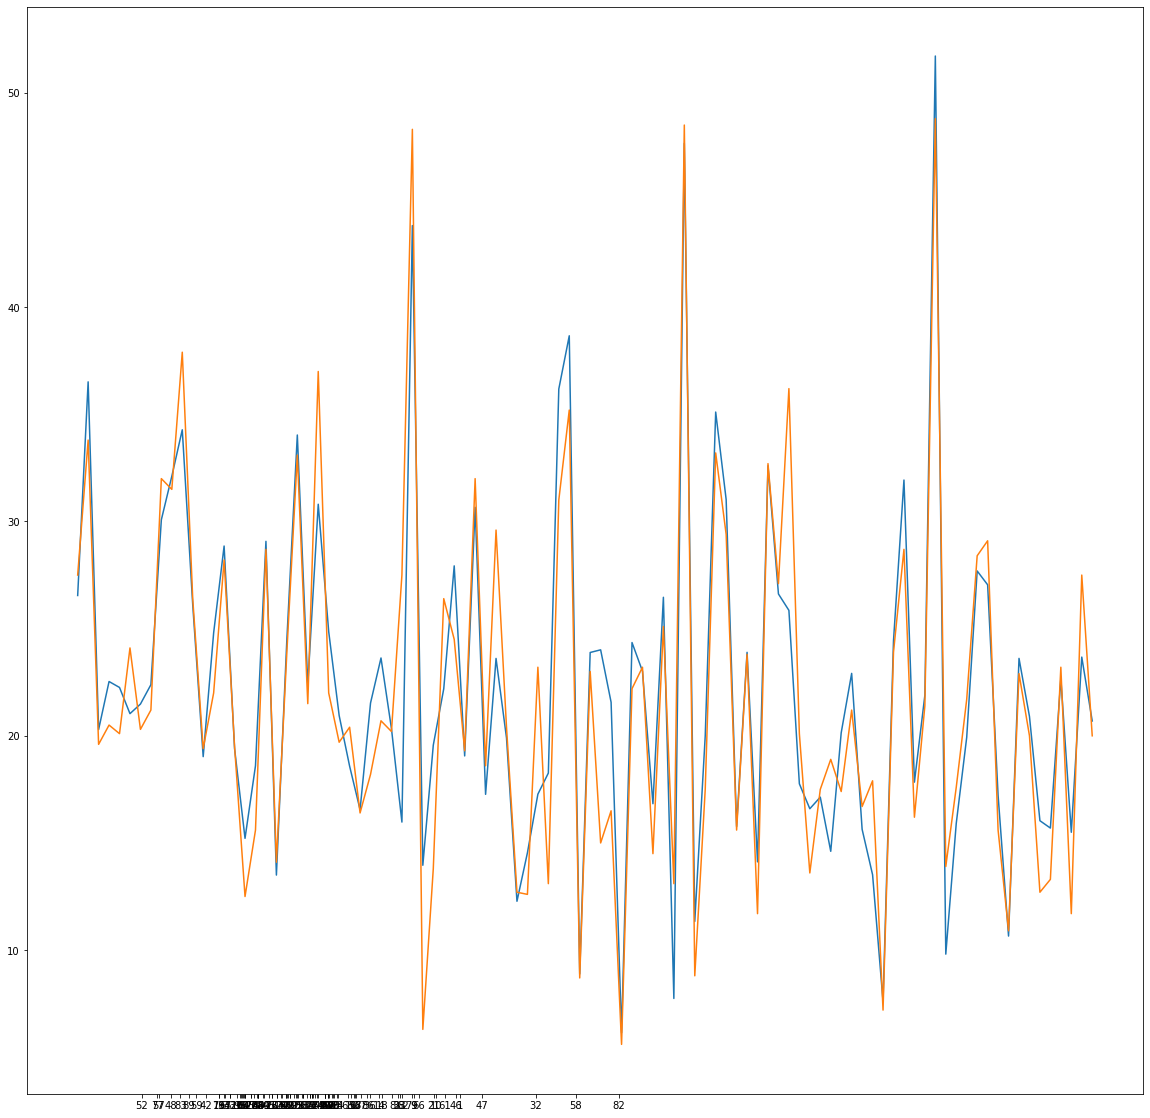

In [182]:
pyplt.xticks(final_predicted_V_real_df['Prediction'], final_predicted_V_real_df.index.values ) # location, labels
ax = pyplt.plot(final_predicted_V_real_df['Prediction'])
ax = pyplt.plot(final_predicted_V_real_df['Real_value'])
pyplt.show()

# 5. References

[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].

[13] Brownlee, J. (2019). An Introduction to Feature Selection. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/an-introduction-to-feature-selection/ [Accessed 4 Dec. 2019].

[14] Chandrayan, P. (2019). Hypothesis Testing Using T Test : Inferential Statistics Part3. [online] Medium. Available at: https://towardsdatascience.com/hypothesis-testing-using-t-test-inferential-statistics-part3-6fb43683bc32 [Accessed 12 Dec. 2019].

[15] Brownlee, J. (2019). A Gentle Introduction to Normality Tests in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ [Accessed 30 Oct. 2019].